<p align="center">
 <img src="http://www.di.uoa.gr/themes/corporate_lite/logo_en.png" title="Department of Informatics and Telecommunications - University of Athens"/> </p>

<br>

---

<h3 align="center" > 
  Bachelor Thesis
</h3>

<h1 align="center" > 
  Entity Resolution in Dissimilarity Spaces <br>
  Implementation notebook
</h1>

---

<h3 align="center"> 
 <b>Konstantinos Nikoletos</b>
</h3>

<h4 align="center"> 
 <b>Supervisors:<br> Dr. Alex Delis</b>,  Professor NKUA <br> <b> Dr. Vassilis Verikios</b>, Professor Hellenic Open University

</h4>
<br>
<h4 align="center"> 
Athens
</h4>
<h4 align="center"> 
January 2021 - Ongoing
</h4>


---

# __Implementation__

## __0.0 Install components__

In [1]:
!pip install editdistance

In [2]:
!pip install pandas
import pandas as pd
print(pd.__version__)

1.0.1


In [3]:
!pip install pandas_read_xml

  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urllib3-1.25.11:
      Successfully uninstalled urllib3-1.25.11


ERROR: requests 2.22.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: botocore 1.12.189 has requirement urllib3<1.26,>=1.20, but you'll have urllib3 1.26.6 which is incompatible.


In [4]:
!pip install requests

  Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.6
    Uninstalling urllib3-1.26.6:
      Successfully uninstalled urllib3-1.26.6


ERROR: pandas-read-xml 0.3.1 has requirement urllib3>=1.26.3, but you'll have urllib3 1.25.11 which is incompatible.


## __0.1 Import libraries__

In [1]:
import pandas as pd
import numpy as np
import collections
import editdistance
import string
import sklearn
import pandas_read_xml as pdx
import time
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import math

from tqdm.notebook import tqdm as tqdm
from scipy.spatial.distance import directed_hausdorff,hamming
from scipy.stats._stats import _kendall_dis
from scipy.stats import spearmanr,kendalltau,pearsonr,kruskal,mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics.distance import jaro_similarity,jaro_winkler_similarity,jaccard_distance
from sklearn.metrics import jaccard_score,accuracy_score,auc,f1_score,recall_score,precision_score,classification_report
from scipy.sparse import csr_matrix
from scipy import sparse
from scipy import stats 
from scipy.spatial.distance import euclidean,hamming
from matplotlib.patches import Rectangle
from sklearn.metrics import ndcg_score

plt.style.use('seaborn-whitegrid') # plot style

## __Final model__









In [86]:
class RankedWTAHash:

  def __init__(self, max_numberOf_clusters, max_editDistance, windowSize, number_of_permutations=1, min_numOfNodes = 2,jaccard_withchars =True,distanceMetricEmbedding = 'l_inf', metric = 'kendal', similarityVectors='ranked', distanceMetric = 'edit', prototypesFilterThr=None, ngramms=3, similarityThreshold=None, maxOnly=None ):
    '''
      Constructor
    '''
    self.max_numberOf_clusters = max_numberOf_clusters
    self.pairDictionary = dict()
    self.max_editDistance = max_editDistance
    self.windowSize = windowSize
    self.S_set = None 
    self.S_index = None 
    self.similarityThreshold = similarityThreshold
    self.maxOnly = maxOnly
    self.metric = metric
    self.min_numOfNodes = min_numOfNodes
    self.similarityVectors = similarityVectors
    self.number_of_permutations = number_of_permutations
    self.distanceMetric = distanceMetric
    self.distanceMetricEmbedding = distanceMetricEmbedding
    self.ngramms = ngramms
    self.jaccard_withchars =  jaccard_withchars
    self.prototypesFilterThr = prototypesFilterThr
    self.earlyStop = False
    self.selectionVariance = None
  
  def fit(self, X):
    """
      Fit the classifier from the training dataset.
      Parameters
      ----------
      X : Training data.
      Returns
      -------
      self : The fitted classifier.
    """
    print("\n#####################################################################\n#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #\n#####################################################################\n")

    if isinstance(X, list):
      input_strings = X
    else:
      input_strings = list(X)

    # print(input_strings)
    self.initialS_set = np.array(input_strings,dtype=object)
    self.S_set = np.array(input_strings,dtype=object)
    if self.distanceMetric == 'jaccard' and self.jaccard_withchars == False:    
      for i in range(0,len(input_strings)):
        self.S_set[i] = set(nltk.ngrams(nltk.word_tokenize(self.S_set[i]), n=self.ngramms))
    elif self.distanceMetric == 'jaccard' and self.jaccard_withchars == True:    
      for i in range(0,len(input_strings)):
        self.S_set[i] = set(nltk.ngrams(self.S_set[i], n=self.ngramms))
    # print(self.S_set)

    self.S_index = np.arange(0,len(input_strings),1)

    # print("\n\nString positions are:")
    # print(self.S_index)
    # print("\n")

    print("###########################################################\n# > 1. Prototype selection phase                          #\n###########################################################\n")
    print("\n-> Finding prototypes and representatives of each cluster:")
    prototypes_time = time.time()
    self.prototypeArray,self.selected_numOfPrototypes = self.Clustering_Prototypes(self.S_index,self.max_numberOf_clusters, self.max_editDistance, self.pairDictionary)
    print("\n- Prototypes selected")
    self.embeddingDim = self.prototypeArray.size
    print(self.prototypeArray)
    heatmapData = []
    for pr in self.prototypeArray:
        print(pr," -> ",self.initialS_set[pr])
        heatmapData.append(self.S_set[pr])
    if self.selected_numOfPrototypes > 2:
        self.selectionVariance = myHeatmap(self.prototypeArray,self.metric,self.EditDistance)
        print("\n- Mean variance in prototype selection: ",self.selectionVariance )
    print("\n- Final number of prototypes: ",self.selected_numOfPrototypes )
    prototypes_time = time.time() - prototypes_time
    print("\n# Finished in %.6s secs" % (prototypes_time))
    print("\n")
    
    self.earlyStop=True
    return self
    
    print("###########################################################\n# > 2. Embeddings based on the Vantage objects            #\n###########################################################\n")
    print("\n-> Creating Embeddings:")
    embeddings_time = time.time()
    self.Embeddings = self.CreateVantageEmbeddings(self.S_index,self.prototypeArray, self.pairDictionary)
    print("- Embeddings created")
    print(self.Embeddings)
    embeddings_time = time.time() - embeddings_time
    print("\n# Finished in %.6s secs" % (embeddings_time))
    print("\n")


    print("###########################################################\n# > 3. WTA Hashing                                        #\n###########################################################\n")
    print("\n-> Creating WTA Buckets:")
    wta_time = time.time()
    self.HashedClusters,self.buckets,self.rankedVectors = self.WTA(self.Embeddings,self.windowSize,self.embeddingDim, self.number_of_permutations)
    print("- WTA buckets: ")
    for key in self.buckets.keys():
      print(key," -> ",self.buckets[key])
    print("\n- WTA number of buckets: ", len(self.buckets.keys()))
    print("\n- WTA RankedVectors after permutation:")
    print(self.rankedVectors)
    wta_time = time.time() - wta_time
    print("\n# Finished in %.6s secs" % (wta_time))
    print("\n")

    print("###########################################################\n# > 4. Similarity checking                                #\n###########################################################\n")
    print("\n-> Similarity checking:")
    if len(self.buckets.keys()) < 8:
        self.earlyStop=True
        return self
    
    similarity_time = time.time()

    if self.similarityVectors == 'ranked':
      self.mapping,self.mapping_matrix = self.SimilarityEvaluation(self.buckets,self.rankedVectors,self.similarityThreshold,maxOnly=self.maxOnly, metric=self.metric)
    elif self.similarityVectors == 'initial':
      self.mapping,self.mapping_matrix = self.SimilarityEvaluation(self.buckets,self.Embeddings,self.similarityThreshold,maxOnly=self.maxOnly, metric=self.metric)      
    else:
      warnings.warn("similarityVectors: Available options are: ranked,initial")
#     print("- Similarity matrix (all values compared):")
#     print(self.similarityProb_matrix)
    print("- Similarity mapping in a matrix")
    print(self.mapping_matrix)
    similarity_time = time.time() - similarity_time
    print("\n# Finished in %.6s secs" % (similarity_time))
    print("\n#####################################################################\n#                    .~ End of training ~.                          #\n#####################################################################\n")

    return self

  def EditDistance(self, str1,str2,verbose=False):
      if verbose:
        if str1 == None:
            print("1")
        elif str2 == None:
            print("2")
        print("-> "+str(str1))
        print("--> "+str(str2))
        print(str(editdistance.eval(self.S_set[str1],self.S_set[str2])))
      
      
      # NOTE: Duplicates inside the dictionary     

      if ((str1,str2) or (str2,str1))  in self.pairDictionary.keys():
        return self.pairDictionary[(str1,str2)]
      else:
        # if verbose:
        # print("++++++++++")
        # print(str1,str2)
        # print(self.S_set[str1],self.S_set[str2])
        # print("++++++++++")
        if self.distanceMetric == 'edit':
            distance = editdistance.eval(self.S_set[str1],self.S_set[str2])
        elif self.distanceMetric == 'jaccard':
#             print("-> "+str(self.initialS_set[str1]))
#             print("--> "+str(self.initialS_set[str2]))
            distance = jaccard_distance(self.S_set[str1],self.S_set[str2])
#             # jaccard because we want DISSIMILARITY 

#             print(distance)
        else:
            warnings.warn("Available metrics for space creation: edit, jaccard ")
        self.pairDictionary[(str2,str1)] = self.pairDictionary[(str1,str2)] = distance
        return distance

  #####################################################################
  # 1. Prototype selection algorithm                                  #
  #####################################################################

  '''
  Clustering_Prototypes(S,k,d,r,C) 
  The String Clustering and Prototype Selection Algorithm
  is the main clustering method, that takes as input the intial strings S, 
  the max number of clusters to be generated in k,
  the maximum allowable distance of a string to join a cluster in var d
  and returns the prototype for each cluster in array Prototype
  '''
  def Clustering_Prototypes(self,S,k,d,pairDictionary,verbose=False):
      
      # ----------------- Initialization phase ----------------- #
      i = 0
      j = 0
      C = np.empty([S.size], dtype=int)
      r = np.empty([2,k],dtype=object)

      Clusters = [ [] for l in range(0,k)]

      for i in tqdm(range(0,S.size,1)):     # String-clustering phase, for all strings
          while j < k :       # iteration through clusters, for all clusters
              if r[0][j] == None:      # case empty first representative for cluster j
                  r[0][j] = S[i]   # init cluster representative with string i
                  C[i] = j         # store in C that i-string belongs to cluster j
                  Clusters[j].append(S[i])
                  break
              elif r[1][j] == None and (self.EditDistance(S[i],r[0][j]) <= d):  # case empty second representative 
                  r[1][j] = S[i]                                             # and ED of representative 1  smaller than i-th string 
                  C[i] = j
                  Clusters[j].append(S[i])
                  break
              elif (r[0][j] != None and r[1][j] != None) and (self.EditDistance(S[i],r[0][j]) + self.EditDistance(S[i],r[1][j])) <= d:
                  C[i] = j
                  Clusters[j].append(S[i])
                  break
              else:
                  j += 1
          i += 1

      # ----------------- Prototype selection phase ----------------- #
          
      Projections = np.empty([k],dtype=object)
      Prototypes = np.empty([k],dtype=int)
      sortedProjections = np.empty([k],dtype=object)

      Projections = []
      Prototypes = []
      sortedProjections = []

      if verbose:
          print("- - - - - - - - -")
          print("Cluster array:")
          print(C)
          print("- - - - - - - - -")
          print("Represantatives array:")
          print(r)
          print("- - - - - - - - -")  
          print("Clusters:")
          print(Clusters)
          print("- - - - - - - - -")  

      new_numofClusters = k

      # print("\n\n\n****** Prototype selection phase *********") 
      prototype_index = 0
      for j in range(0,k,1):
          
          # IF small cluster
          # print("Len ",len(Clusters[j]))
          if len(Clusters[j]) < self.min_numOfNodes or r[1][j] == None or r[0][j]==None:
            new_numofClusters-=1
            continue

          Projections.append(self.Approximated_Projection_Distances_ofCluster(r[1][j], r[0][j], j, Clusters[j],pairDictionary))         
          # print(Projections[prototype_index])
          sortedProjections.append({new_numofClusters: v for new_numofClusters, v in sorted(Projections[prototype_index].items(), key=lambda item: item[1])})
          
          
          Prototypes.append(self.Median(sortedProjections[prototype_index]))
          # print(Prototypes[prototype_index])

          prototype_index += 1

      # print("\n****** END *********\n")
      Prototypes,new_numofClusters = self.optimize_clusterSelection(Prototypes,new_numofClusters)
      
      return np.array(Prototypes),new_numofClusters


  def Approximated_Projection_Distances_ofCluster(self, right_rep, left_rep, cluster_id, clusterSet, pairDictionary):
      # print("here")
      # print(clusterSet)
      # print(right_rep, left_rep)

      distances_vector = dict()

      if len(clusterSet) > 2:
        rep_distance     = self.EditDistance(right_rep,left_rep)
                 
        for str_inCluster in range(0,len(clusterSet)): 
          if clusterSet[str_inCluster] != right_rep and clusterSet[str_inCluster] != left_rep:
            # print(clusterSet[str_inCluster],right_rep,left_rep)
            right_rep_distance = self.EditDistance(right_rep,clusterSet[str_inCluster])
            left_rep_distance  = self.EditDistance(left_rep,clusterSet[str_inCluster])
            
            if rep_distance == 0: 
              distances_vector[clusterSet[str_inCluster]] = 0
            else:
              distance = (right_rep_distance**2-rep_distance**2-left_rep_distance**2 ) / (2*rep_distance)
              distances_vector[clusterSet[str_inCluster]] = distance
      
      else:
#         print("set: ",clusterSet)
#         print("left: ",left_rep)
#         print("right: ",right_rep)
        if left_rep != None and right_rep == None:
          distances_vector[left_rep] = left_rep
          # print("l")
        elif right_rep != None and left_rep == None:
          distances_vector[right_rep] = right_rep
          # print("r")
        elif left_rep == None and right_rep == None:
          return None
        elif left_rep != None and right_rep != None:
          distances_vector[right_rep] = right_rep
          distances_vector[left_rep]  = left_rep
      # print(distances_vector)
      return distances_vector

  def Median(self, distances):    
      '''
      Returns the median value of a vector
      '''
      keys = list(distances.keys())
      if keys == 1:
        return keys[0]

      # print(distances)
      keys = list(distances.keys())
      # print(keys)
      median_position = int(len(keys)/2)
      # print(median_position)
      median_value = keys[median_position]

      return median_value
  
  def optimize_clusterSelection(self,Prototypes,numOfPrototypes):
        
        notwantedPrototypes = []
        print(self.max_editDistance/2)
        for pr_1 in range(0,numOfPrototypes):
            for pr_2 in range(pr_1+1,numOfPrototypes):
                if self.EditDistance(Prototypes[pr_1],Prototypes[pr_2]) < self.prototypesFilterThr:
                    notwantedPrototypes.append(Prototypes[pr_2]) 
#                     print("-> "+str(self.initialS_set[Prototypes[pr_1]]))
#                     print("--> "+str(self.initialS_set[Prototypes[pr_1]]))
#                     print(self.EditDistance(Prototypes[pr_1],Prototypes[pr_2]))

        newPrototypes = list((set(Prototypes)).difference(set(notwantedPrototypes)))           
        
        print("Prototypes before:")
        print(Prototypes)
        print("Not wanted:")
        print(set(notwantedPrototypes) )
        print("Final:")
        print(newPrototypes)
        return newPrototypes,len(newPrototypes)
  #####################################################################
  #       2. Embeddings based on the Vantage objects                  #
  #####################################################################

  '''
  CreateVantageEmbeddings(S,VantageObjects): Main function for creating the string embeddings based on the Vantage Objects
  '''
  def CreateVantageEmbeddings(self, S, VantageObjects, pairDictionary):
      
      # ------- Distance computing ------- #     
      vectors = []
      for s in tqdm(range(0,S.size)):
          string_embedding = []
          for p in range(0,VantageObjects.size): 
              if VantageObjects[p] != None:
#                   print("-",VantageObjects[p])
                  string_embedding.append(self.DistanceMetric(s,p,S,VantageObjects, pairDictionary))
              
          # --- Ranking representation ---- #
          ranked_string_embedding = stats.rankdata(string_embedding, method='dense')
          
          # ------- Vectors dataset ------- #
          vectors.append(ranked_string_embedding)
      
      return np.array(vectors)
      

  '''
  DistanceMetric(s,p,S,Prototypes): Implementation of equation (5)
  '''
  def DistanceMetric(self, s, p, S, VantageObjects, pairDictionary, distanceMetricEmbedding = 'l_inf'):
      
      if distanceMetricEmbedding == 'l_inf':
          max_distance = None

          for pp in range(0,VantageObjects.size):
              if VantageObjects[pp] != None:
                  string_distance = self.EditDistance(S[s],VantageObjects[pp])    # Edit distance String-i -> Vantage Object
                  VO_distance     = self.EditDistance(VantageObjects[p],VantageObjects[pp])    # Edit distance Vantage Object-j -> Vantage Object-i

                  abs_diff = abs(string_distance-VO_distance)

                  # --- Max distance diff --- #        
                  if max_distance == None:
                      max_distance = abs_diff
                  elif abs_diff > max_distance:
                      max_distance = abs_diff
          return max_distance
    
      elif distanceMetricEmbedding == 'edit':
          return self.EditDistance(S[s],VantageObjects[p])
      elif distanceMetricEmbedding == 'jaccard':
          return jaccard_distance(S[s],VantageObjects[p])
      elif distanceMetricEmbedding == 'euclid_jaccard':
          return sqrt(1-jaccard_distance(S[s],VantageObjects[p]))
      elif distanceMetricEmbedding == 'euclidean':
          return euclidean(S[s],VantageObjects[p])
      else:
          warnings.warn("Available metrics: edit,jaccard,l_inf,euclidean")
        

  def dropNone(array):
      array = list(filter(None, list(array)))
      return np.array(array)

  def topKPrototypes():
      return

  #####################################################################
  #                 3. Similarity checking                            # 
  #####################################################################

  def SimilarityEvaluation(self, buckets,vectors,threshold,maxOnly=None,metric=None):
    
#     print(buckets)
#     print(vectors)
    numOfVectors = vectors.shape[0]
    vectorDim    = vectors.shape[1]
    mapping_matrix = np.zeros([numOfVectors,numOfVectors],dtype=np.int8)
    self.similarityProb_matrix = np.empty([numOfVectors,numOfVectors],dtype=np.float)* np.nan
    mapping = {}

    # Loop for every bucket
    for bucketid in tqdm(buckets.keys()):
      bucket_vectors = buckets[bucketid]
      numOfVectors = len(bucket_vectors)
      
      print(bucket_vectors)
      # For every vector inside the bucket
      for v_index in range(0,numOfVectors,1):
        v_vector_id = bucket_vectors[v_index]
        # Loop to all the other
        for i_index in range(v_index+1,numOfVectors,1):
          i_vector_id = bucket_vectors[i_index]
#           print('v_vector_id: ',v_vector_id,'i_vector_id: ',i_vector_id)
#           print(vectors[v_vector_id], " | ",vectors[i_vector_id])

          if vectorDim == 1:
            warnings.warn("Vector dim equal to 1-Setting metric to kendalltau")
            metric = 'kendal'

          if metric == None or metric == 'kendal':  # Simple Kendal tau metric
            similarity_prob, p_value = kendalltau(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'customKendal':  # Custom Kendal tau
            numOf_discordant_pairs = _kendall_dis(vectors[v_vector_id].astype('intp'), vectors[i_vector_id].astype('intp'))
            similarity_prob = (2*numOf_discordant_pairs) / (vectorDim*(vectorDim-1))
          elif metric == 'jaccard':
            similarity_prob = jaccard_score(vectors[v_vector_id], vectors[i_vector_id], average='micro')
          elif metric == 'cosine':
            similarity_prob = cosine_similarity(np.array(vectors[v_vector_id]).reshape(1, -1), np.array(vectors[i_vector_id]).reshape(1, -1))
          elif metric == 'pearson':
            similarity_prob, _ = pearsonr(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'spearman':
            similarity_prob, _ = spearmanr(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'spearmanf':
            similarity_prob = 1-spearman_footrule_distance(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'hamming':
            similarity_prob, _ = hamming(vectors[v_vector_id].astype('intp'), vectors[i_vector_id].astype('intp'))
          elif metric == 'kruskal':
            if np.array_equal(vectors[v_vector_id],vectors[i_vector_id]):
              similarity_prob=1.0
            else:  
              _,similarity_prob = kruskal(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'ndcg_score':
            similarity_prob, _ = ndcg_score(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'rbo':
            similarity_prob = rbo(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'mannwhitneyu':
            if np.array_equal(vectors[v_vector_id],vectors[i_vector_id]):
              similarity_prob=1.0
            else:  
               _,similarity_prob = mannwhitneyu(vectors[v_vector_id], vectors[i_vector_id])
          else:
            warnings.warn("SimilarityEvaluation: Available similarity metrics: kendal,customKendal,jaccard,ndcg_score,cosine,spearman,pearson")
          
#           print("--",rbo(vectors[v_vector_id], vectors[i_vector_id]))
#           print(similarity_prob)
          self.similarityProb_matrix[v_vector_id][i_vector_id] = similarity_prob
#           print("pr: ",self.similarityProb_matrix[v_vector_id][i_vector_id],similarity_prob)
          # if v_vector_id == 0:
#           print(v_vector_id, i_vector_id," : ",similarity_prob )        
          if similarity_prob > threshold:
            if v_vector_id not in mapping.keys():
              mapping[v_vector_id] = []
            mapping[v_vector_id].append(i_vector_id)  # insert into mapping
            mapping_matrix[v_vector_id][i_vector_id] = 1  # inform prediction matrix
            mapping_matrix[i_vector_id][v_vector_id] = 1  # inform prediction matrix

    
    return mapping, np.triu(mapping_matrix)

  #####################################################################
  #                        4. WTA Hashing                             # 
  #####################################################################

  def WTA(self,vectors,K,inputDim, number_of_permutations):
    '''
      Winner Take All hash - Yagnik
      .............................

      K: window size
    '''
    newVectors = []
    buckets = dict()

    numOfVectors = vectors.shape[0]
    vectorDim    = vectors.shape[1]

    if vectorDim < K:
      K = vectorDim
      warnings.warn("Window size greater than vector dimension")
      
    C = np.zeros([numOfVectors,number_of_permutations], dtype=int)
    
#     X_new = np.array(vectors)
    
    permutation_dimension = inputDim
    for permutation_index in range(0,number_of_permutations,1):
        theta = np.random.permutation(permutation_dimension)
        i=0;j=0;
#         print(newVectors)
        for v_index in range(0,numOfVectors,1):
#           print(v_index)
          
          if permutation_index == 0:
#             print("Before: ",vectors[v_index])
            X_new = self.permuted(vectors[v_index],theta)
            newVectors.append(X_new)
          else:
#             print("Before: ",newVectors[v_index])
#             print(theta[:K])
            X_new = self.permuted(newVectors[v_index],theta)
            newVectors[v_index] = X_new
          
              
#           X_new = X_new[:K]
#           print("After: ",X_new)
#           print("X_new: ",X_new)
          C[i][permutation_index] = max(range(len(X_new[:K])), key=X_new[:K].__getitem__)
#           print("- ",index_max)
#           c_i = index_max

#           for j in range(0,K,1):
#             if X_new[j] > X_new[c_i]:
#               c_i = j

#           print("-> ",c_i)
#           C[i][permutation_index] = c_i
#           print(C)
          
          i+=1
        permutation_dimension = K

    for c,i in zip(C,range(0,numOfVectors,1)):
        buckets = self.bucketInsert(buckets,str(c),i)
#     print(C)
#     print(buckets)
    return C,buckets,np.array(newVectors,dtype=np.intp)

  def permuted(self,vector,permutation):
    permuted_vector = [vector[x] for x in permutation]
    return permuted_vector 

  def bucketInsert(self,buckets,bucket_id,item):
    if bucket_id not in buckets.keys():
      buckets[bucket_id] = []
    buckets[bucket_id].append(item)

    return buckets


### Evaluation function

Returns:
- Accuracy
- Precision
- Recall
- F1-score

In [3]:
#####################################################################
#                          Evaluation                               # 
#####################################################################
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

def evaluate_cora(predicted_matrix, true_matrix, with_classification_report=False ):

  print("#####################################################################\n#                          Evaluation                               #\n#####################################################################\n")
  true_matrix = sparse.triu(true_matrix)
  # print(true_matrix)
  predicted_matrix =  sparse.triu(predicted_matrix)
  # print(predicted_matrix)

  acc = 100*accuracy_score(true_matrix, predicted_matrix)
  f1 =  100*f1_score(true_matrix, predicted_matrix, average='micro')
  recall = 100*recall_score(true_matrix, predicted_matrix, average='micro')
  precision = 100*precision_score(true_matrix, predicted_matrix, average='micro')

  print("Accuracy:  %3.2f %%" % (acc))
  print("F1-Score:  %3.2f %%" % (f1))
  print("Recall:    %3.2f %%" % (recall))
  print("Precision: %3.2f %%" % (precision))

  # results_dataframe = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1'])
  # results_dataframe.loc[len(results_dataframe)+1] = [acc,precision,recall,f1]

  if with_classification_report:
    print(classification_report(true_matrix, predicted_matrix))

  print('\n\n')
  return acc,f1,precision,recall


In [4]:
def spearman_footrule_distance(s,t):
    """
    Computes the Spearman footrule distance between two full lists of ranks:
        F(s,t) = sum[ |s(i) - t(i)| ]/S,
    the normalized sum over all elements in a set of the absolute difference between
    the rank according to s and t.  As defined, 0 <= F(s,t) <= 1.
    S is a normalizer which is equal to 0.5*len(s)^2 for even length ranklists and
    0.5*(len(s)^2 - 1) for odd length ranklists.
    If s,t are *not* full, this function should not be used. s,t should be array-like
    (lists are OK).
    """
    # check that size of intersection = size of s,t?
    assert len(s) == len(t)
    sdist = sum(abs(s - t))
    # c will be 1 for odd length lists and 0 for even ones
    c = len(s) % 2
    normalizer = 0.5*(len(s)**2 - c)
    return sdist/normalizer

def WTA_similarity(vector1,vector2):
    
    PO=0
    for i in range(0,len(vector1),1):
        for j in range(0,i,1):
            ij_1 = vector1[i] - vector1[j]
            ij_2 = vector2[i] - vector2[j]
            PO += WTA_Threshold(ij_1*ij_2)
    return PO

def WTA_Threshold(x):    
    if x>0:
        return 1
    else:
        return 0

import scipy.special as special

def kendall_top_k(a,b,k=None,p=0): #zero is equal 1 is max distance, compare with 1-scipy.stats.kendalltau(a,b)/2+1/2
    """
    kendall_top_k(np.array,np.array,k,p)
    This function generalise kendall-tau as defined in [1] Fagin, Ronald, Ravi Kumar, and D. Sivakumar. "Comparing top k lists." SIAM Journal on Discrete Mathematics 17.1 (2003): 134-160.
    It returns a distance: 0 for identical (in the sense of top-k) lists and 1 if completely different.
    Example:
        Simply call it with two same-length arrays of ratings (or also rankings), length of the top elements k (default is the maximum length possible), and p (default is 0, see [1]) as parameters:
            $ a = np.array([1,2,3,4,5])
            $ b = np.array([5,4,3,2,1])
            $ kendall_top_k(a,b,k=4)
    """

    if k is None:
        k = a.size
    if a.size != b.size:
        raise NameError('The two arrays need to have same lengths')
    k = min(k,a.size)
    a_top_k = np.argpartition(a,-k)[-k:]
    b_top_k = np.argpartition(b,-k)[-k:]
    common_items = np.intersect1d(a_top_k,b_top_k)
    only_in_a = np.setdiff1d(a_top_k, common_items)
    only_in_b = np.setdiff1d(b_top_k, common_items)
    kendall = (1 - (stats.kendalltau(a[common_items], b[common_items])[0]/2+0.5)) * (common_items.size**2) #case 1
    if np.isnan(kendall): # degenerate case with only one item (not defined by Kendall)
        kendall = 0
    for i in common_items: #case 2
        for j in only_in_a:
            if a[i] < a[j]:
                kendall += 1
        for j in only_in_b:
            if b[i] < b[j]:
                kendall += 1
    kendall += 2*p * special.binom(k-common_items.size,2)     #case 4
    kendall /= ((only_in_a.size + only_in_b.size + common_items.size)**2 ) #normalization
    return kendall
    
def rbo(list1, list2, p=0.9):
   # tail recursive helper function
   def helper(ret, i, d):
       l1 = set(list1[:i]) if i < len(list1) else set(list1)
       l2 = set(list2[:i]) if i < len(list2) else set(list2)
       a_d = len(l1.intersection(l2))/i
       term = math.pow(p, i) * a_d
       if d == i:
           return ret + term
       return helper(ret + term, i + 1, d)
   k = max(len(list1), len(list2))
   x_k = len(set(list1).intersection(set(list2)))
   summation = helper(0, 1, k)
   return ((float(x_k)/k) * math.pow(p, k)) + ((1-p)/p * summation)

# Example usage
print(rbo([4,10,20], [1,2,3]))

p = 0.9
d = 3

def sum_series(p, d):
   # tail recursive helper function
   def helper(ret, p, d, i):
       term = math.pow(p, i)/i
       if d == i:
           return ret + term
       return helper(ret + term, p, d, i+1)
   return helper(0, p, d, 1)

wrbo1_d = 1 - math.pow(p, d-1) + (((1-p)/p) * d *(np.log(1/(1-p)) - sum_series(p, d-1)))

print(wrbo1_d) 

0.0
0.5225283643313485



# __Evaluation__

## __CoRA__ - New

### Load from Drive

In [5]:
# # Opening data file
# import io
# from google.colab import drive

# drive.mount('/content/drive',force_remount=True)

# fpcora = r"/content/drive/My Drive/ERinDS/CORA.xml"
# fpcora_gold = r"/content/drive/My Drive/ERinDS/cora_gold.csv"

### Jupyter load

In [6]:
import os
fpcora = os.path.abspath("CORA.xml")
fpcora_gold = os.path.abspath("cora_gold.csv")

In [7]:
cora = pdx.read_xml(fpcora,['CORA', 'NEWREFERENCE'],root_is_rows=False)
xml_dataframe = cora
xml_dataframe['@id'] = pd.to_numeric(xml_dataframe['@id']).subtract(1)

### Import true values

In [8]:
cora_gold = pd.read_csv(fpcora_gold,sep=';')
true_values = cora_gold
cora_gold['id1'] = pd.to_numeric(cora_gold['id1']).subtract(1)
cora_gold['id2'] = pd.to_numeric(cora_gold['id2']).subtract(1)

### Preprocess

In [9]:
def preprocess(row):

    paper_str = " ".join(row)
    paper_str = paper_str.lower()
    paper_str = paper_str.replace("\n", " ").replace("/z", " ").replace("[","").replace("]","").replace(",", " ")

    return str(paper_str)

### Shuffle data

In [10]:
shuffled_df = xml_dataframe.sample(frac=1).reset_index(drop=True)
# shuffled_df

### Creating dataset 

In [72]:
def cora_createDataset(xml_dataframe, true_values, fields, keepNone = False):

    rawStr_col = []
    index_to_id_dict = {}
    sameEntities_dictionary = {}

    i=0
    for _, row in tqdm(xml_dataframe.iterrows()):
        index_to_id_dict[int(row['@id'])] = i

        rawStr = []
        for field in fields:    # NAN
            if row[field] == None and keepNone == True:
                rawStr.append(str(row[field]))
            elif keepNone == False and row[field] != None:
                rawStr.append(str(row[field]))
        i+=1
        rawStr_col.append(preprocess(rawStr))

    num_of_records = len(xml_dataframe)
    trueValues_matrix = np.zeros([num_of_records,num_of_records],dtype=np.int8)

    cluster_dict = {0:set()}
    cluster_dict[0].add(0)
    clusters = []
    key = 0

    for _, row in tqdm(true_values.iterrows()):  
        # print(index_to_id_dict[row['id1']],index_to_id_dict[row['id2']])
        trueValues_matrix[index_to_id_dict[row['id1']]][index_to_id_dict[row['id2']]] = 1
        trueValues_matrix[index_to_id_dict[row['id2']]][index_to_id_dict[row['id1']]] = 1


        if index_to_id_dict[row['id1']] in cluster_dict[key] or index_to_id_dict[row['id2']] in cluster_dict[key]:
            cluster_dict[key].add(index_to_id_dict[row['id1']])
            cluster_dict[key].add(index_to_id_dict[row['id2']])
        elif index_to_id_dict[row['id1']] in cluster_dict[key] and index_to_id_dict[row['id2']] not in cluster_dict[key]: 
            cluster_dict[key].add(index_to_id_dict[row['id2']])
        elif index_to_id_dict[row['id2']] in cluster_dict[key] and index_to_id_dict[row['id1']] not in cluster_dict[key]: 
            cluster_dict[key].add(index_to_id_dict[row['id1']])
        elif index_to_id_dict[row['id2']] not in cluster_dict[key] and index_to_id_dict[row['id1']] not in cluster_dict[key]: 
            key+=1
            cluster_dict[key] = set()
            cluster_dict[key].add(index_to_id_dict[row['id1']])
            cluster_dict[key].add(index_to_id_dict[row['id2']])    
#             print('here')
        clusters.append(key)

        if index_to_id_dict[row['id1']] not in sameEntities_dictionary.keys():
             sameEntities_dictionary[index_to_id_dict[row['id1']]] = []
        sameEntities_dictionary[ index_to_id_dict[row['id1']]].append( index_to_id_dict[row['id2']])

#     print(cluster_dict)
#     print(clusters)
    return rawStr_col,sameEntities_dictionary, np.triu(trueValues_matrix), clusters


# fields = ['author', 'title', 'journal', 'volume', 'pages', 'date', '#text',
#        'publisher', 'address', 'note', 'booktitle', 'editor', 'booktile',
#        'tech', 'institution', 'Pages', 'year', 'type', 'month']

fields = ['author', 'title', 'journal']

data, true_labels, true_matrix, clusters = cora_createDataset(xml_dataframe, cora_gold, fields)

## Dataset inspection

#### String length

In [12]:
data_length = [ len(x) for x in data ]
print("Dataset size: ",len(data)," strings-papers")
print("Average length: %d" % (np.mean(data_length)))
print("Min length: %d" % (min(data_length)))
print("Max length: %d" % (max(data_length)))
print("Median length: %d" % (np.median(data_length)))

Dataset size:  1879  strings-papers
Average length: 95
Min length: 18
Max length: 466
Median length: 86


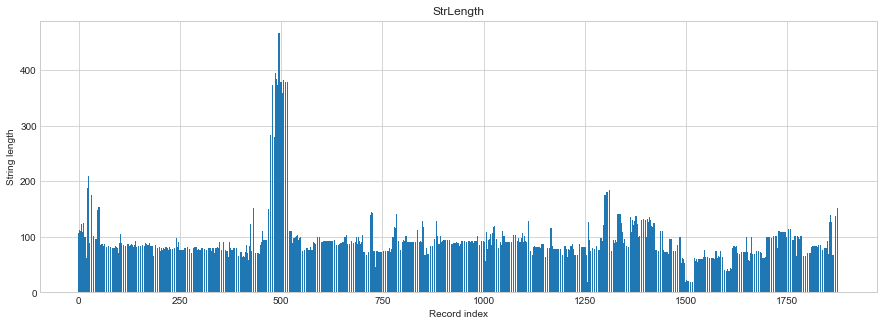

In [13]:
plt.figure(figsize=(15,5))
plt.bar(range(0,len(data_length),1),data_length)
plt.xlabel("Record index")
plt.ylabel("String length")
plt.title("StrLength")
plt.show()

## Jaccard VS Edit distance variance

In [14]:
from sklearn.decomposition import PCA 
from numpy.linalg import svd

def PCA_SpaceVisualization(X,title='PCA plot'):
    '''
    PCA to given array X and creating a plot
    Returns PCA components array after fit_transform
    '''
    
    # PCA code
    pca = PCA(n_components=2)
    pca.fit(X)
    pcaComponents = pca.fit_transform(X) # pcaComponents is the data that I'll use from PCA
    
    # Seperating components
    first_component = [x[0] for x in pcaComponents]
    second_component = [x[1] for x in pcaComponents]
    
    # Plotting code
    fig, ax = plt.subplots(figsize=(25,10))
    ax.scatter(first_component, second_component,alpha=0) 
    fig.suptitle(title,fontsize=40,fontweight='bold')
    ax.set_xlabel('X Component',fontsize=30,fontweight='bold')
    ax.set_ylabel('Y Component',fontsize=30,fontweight='bold')
    
    for x0, y0, i in zip(first_component, second_component,range(0,len(first_component),1)):
        plt.text(x0,y0,i, ha="center", va="center",fontsize=20,color='b')
        
    return pcaComponents


In [15]:
sent = 'This is an example of bigramms and trigramms!'
print(set(nltk.ngrams(sent, n=3)))
print(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)))
print(nltk.jaccard_distance(set(nltk.ngrams(sent, n=3)),set(nltk.ngrams(sent, n=3))))
print(nltk.jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)),set(nltk.ngrams(nltk.word_tokenize(sent), n=3))))

{('i', 'g', 'r'), ('l', 'e', ' '), ('a', 'm', 'p'), ('r', 'i', 'g'), ('m', 's', '!'), ('o', 'f', ' '), ('a', 'n', ' '), ('m', 'm', 's'), ('n', 'd', ' '), ('b', 'i', 'g'), ('f', ' ', 'b'), ('g', 'r', 'a'), ('m', 'p', 'l'), ('m', 's', ' '), ('d', ' ', 't'), ('i', 's', ' '), ('e', ' ', 'o'), ('s', ' ', 'i'), ('p', 'l', 'e'), ('t', 'r', 'i'), (' ', 't', 'r'), ('T', 'h', 'i'), ('r', 'a', 'm'), ('a', 'm', 'm'), (' ', 'e', 'x'), ('s', ' ', 'a'), (' ', 'a', 'n'), (' ', 'o', 'f'), ('e', 'x', 'a'), (' ', 'b', 'i'), ('n', ' ', 'e'), ('x', 'a', 'm'), ('h', 'i', 's'), (' ', 'i', 's'), ('a', 'n', 'd')}
{('and', 'trigramms', '!'), ('This', 'is', 'an'), ('example', 'of', 'bigramms'), ('of', 'bigramms', 'and'), ('is', 'an', 'example'), ('bigramms', 'and', 'trigramms'), ('an', 'example', 'of')}
0.0
0.0


In [49]:
def myHeatmap(data,metric,distance):
    if metric == 'edit':    
        matrix  = np.zeros((len(data),len(data)), dtype=np.int)
    else:
        matrix = np.zeros((len(data),len(data)), dtype=np.float)
    
    for i in range(0,len(data),1):
        for j in range(0,len(data),1):
            if i != j:            
                matrix[i][j]  = distance(data[i],data[j])

                
    fif,ax = plt.subplots(1,figsize=(10,10))
    corr = np.corrcoef(matrix)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(matrix, linewidth=0.5,annot=False,cmap="Blues_r",mask=mask,fmt='.3g',ax=ax)
    plt.show()
    return matrix.mean()

### Evaluation

In [17]:
def similarityProbsHeatMap(similarityProb_matrix,clusters,title):
    fif,ax = plt.subplots(1,figsize=(20,20))
    colors = ['red','green','blue','yellow','orange']
    c=0
    for cl in clusters:
        for i  in range(0,len(cl)):
            for j in range(i+1,len(cl)):
                ax.add_patch(Rectangle((cl[j],cl[i]), 1, 1, fill=False, edgecolor=colors[c], lw=3))
        c+=1
#     corr = np.corrcoef(ed_matrix)
#     mask = np.zeros_like(corr)
#     mask[np.tril_indices_from(mask)] = True
    ax.set_title(title,fontsize=20,fontweight='bold')
    ax = sns.heatmap(similarityProb_matrix, linewidth=0.5,annot=True,cmap="Blues",fmt='.3g',ax=ax)
    plt.show()

In [18]:
s1 = "m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r.   andersson  nan j appl. phys."
s2 = "m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  j appl. phys. "

jc3 = jaccard_distance(set(nltk.ngrams(s1, n=3)),set(nltk.ngrams(s2, n=3)))
js3 = jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(s1), n=3)),set(nltk.ngrams(nltk.word_tokenize(s2), n=3)))
jc2 = jaccard_distance(set(nltk.ngrams(s1, n=2)),set(nltk.ngrams(s2, n=2)))
js2 = jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(s1), n=2)),set(nltk.ngrams(nltk.word_tokenize(s2), n=2)))

print(jc3,js3,jc2,js2)
print(editdistance.eval(s1,s2))

0.0784313725490196 0.22727272727272727 0.012987012987012988 0.13636363636363635
7


In [19]:
results_dataframe = pd.DataFrame(columns=['max_numberOf_clusters','max_editDistance','similarityThreshold','windowSize','metric','similarityVectors',"distanceMetricEmbedding","distanceMetric","number_of_permutations","ngramms","jaccard_with_chars",'Accuracy','Precision','Recall','F1','Time'])

In [73]:
%%time

ngramms= 3                                  # If jaccard used, n-gramms are used
jaccard_withchars = True                    # n-gramms either of chars and either of words

# Prototype selection
max_numberOf_clusters= 500                  # Νumber of loops for finding representatives, it is an upper bound of clusters.
max_editDistance= 0.5                       # The threshold for the triangle inequality
distanceMetric= 'jaccard'                   # Distance metric between the vectors when creating the space
prototypesFilterThr = 0.3                 # Prototypes must differ more that threshold

# Embedding phase
distanceMetricEmbedding = 'euclid_jaccard'  # Embedding metric

# WTA algorithm
windowSize= 100                             # Vector size for WTA algo
number_of_permutations = 30                 # WTA number of permutations


# Similarity evaluation
similarityVectors='ranked'                  # which vectors will be passed to WTA step
similarityThreshold= 0.7                    # Similarity threshold for the final step
metric='kendal'                             # Similarity metric between vectors




start = time.time()
model = RankedWTAHash(max_numberOf_clusters= max_numberOf_clusters,    max_editDistance= max_editDistance,    windowSize= windowSize,    similarityThreshold= similarityThreshold,    metric=metric,    similarityVectors=similarityVectors,    number_of_permutations = number_of_permutations,
distanceMetric= distanceMetric,distanceMetricEmbedding = distanceMetricEmbedding,ngramms= ngramms,jaccard_withchars = jaccard_withchars)
model = model.fit(data)
acc,f1,precision,recall = evaluate_cora(model.mapping_matrix,true_matrix, False)
exec_time = time.time() - start
results_dataframe.loc[len(results_dataframe)+1] = [max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,jaccard_withchars,acc,precision,recall,f1,exec_time]


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.25


TypeError: '<' not supported between instances of 'float' and 'NoneType'

In [81]:
%%time

ngramms= 3                                  # If jaccard used, n-gramms are used
jaccard_withchars = False                    # n-gramms either of chars and either of words

# Prototype selection
max_numberOf_clusters= 500                  # Νumber of loops for finding representatives, it is an upper bound of clusters.
max_editDistance= 50                       # The threshold for the triangle inequality
distanceMetric= 'edit'                   # Distance metric between the vectors when creating the space
prototypesFilterThr = 10                # Prototypes must differ more that threshold

# Embedding phase
distanceMetricEmbedding = 'euclid'  # Embedding metric

# WTA algorithm
windowSize= 100                             # Vector size for WTA algo
number_of_permutations = 30                 # WTA number of permutations


# Similarity evaluation
similarityVectors='ranked'                  # which vectors will be passed to WTA step
similarityThreshold= 0.7                    # Similarity threshold for the final step
metric='kendal'                             # Similarity metric between vectors




start = time.time()
model = RankedWTAHash(max_numberOf_clusters= max_numberOf_clusters,    max_editDistance= max_editDistance,    windowSize= windowSize,    similarityThreshold= similarityThreshold,    metric=metric,    similarityVectors=similarityVectors,    number_of_permutations = number_of_permutations,
distanceMetric= distanceMetric,distanceMetricEmbedding = distanceMetricEmbedding,ngramms= ngramms,jaccard_withchars = jaccard_withchars)
model = model.fit(data)
acc,f1,precision,recall = evaluate_cora(model.mapping_matrix,true_matrix, False)
exec_time = time.time() - start
results_dataframe.loc[len(results_dataframe)+1] = [max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,jaccard_withchars,acc,precision,recall,f1,exec_time]


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0


TypeError: '<' not supported between instances of 'int' and 'NoneType'

## Grid search each section

### GridSearch function

In [83]:
def GridSearch_cora(data,true_matrix,max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,withchars,prototypeFilter):
    results_dataframe = pd.DataFrame(columns=['max_numberOf_clusters','max_editDistance','similarityThreshold','windowSize','metric','similarityVectors',"distanceMetricEmbedding","distanceMetric","number_of_permutations",'prototypesFilterThr',"protSelectionVariance",'numOfPrototypes','numOfBuckets','averageBucketSize','Accuracy','Precision','Recall','F1','Time'])
    i=1
    for n1 in tqdm(max_numberOf_clusters):
        for n2 in (max_editDistance):
            for n3 in (similarityThreshold):
                for n4 in (windowSize):
                    for n5 in (metric):
                        for n6 in (similarityVectors):
                            for n7 in (distanceMetricEmbedding):
                                for n8 in (distanceMetric):
                                    for n9 in (number_of_permutations):
                                        for n10 in (withchars):
                                            for n11 in (withchars):
                                                for n12 in (prototypeFilter):
                                                    
                                                    print("+ ------------  ",i,"   ------------- +")
                                                    print('max_numberOf_clusters: ',n1)
                                                    print('max_editDistancez: ',n2)
                                                    print('similarityThreshold: ',n3)
                                                    print('windowSize: ',n4)
                                                    print('metric: ',n5)
                                                    print('similarityVectors: ',n6)
                                                    print('distanceMetricEmbedding: ',n7)
                                                    print('distanceMetric: ',n8)
                                                    print('number_of_permutations: ',n9)
                                                    print('withchars: ',n10)
                                                    print('ngramms: ',n11)
                                                    print('prototypeFilter: ',n12)
                                                    print("+ ----------------------------------- +")
                                                    start = time.time()
                                                    model = RankedWTAHash(
                                                      max_numberOf_clusters= n1,
                                                      max_editDistance= n2,
                                                      windowSize= n4,
                                                      similarityThreshold= n3,
                                                      maxOnly= False,
                                                      metric=n5,
                                                      similarityVectors=n6,
                                                      number_of_permutations = n9,
                                                      distanceMetric= n8,
                                                      distanceMetricEmbedding = n7,
                                                      jaccard_withchars = n10,
                                                      ngramms= n11,                                                      
                                                      prototypesFilterThr = n12
                                                    )
                                                    model = model.fit(data)
                                                    exec_time = time.time() - start
                                                    if not model.earlyStop:                                            
                                                        acc,f1,precision,recall = evaluate_cora(model.mapping_matrix,true_matrix)
                                                        for key in model.buckets.keys():
                                                            tempListmodel.buckets[key]
                                                        averageBucketSize = np.mean([len(model.buckets[x]) for x in model.buckets.keys() ])
                                                        numOfBuckets=len(model.buckets.keys())
                                                    else:
                                                        numOfBuckets = averageBucketSize = acc = f1 = precision = recall = 'Not counted'
                                                    i+=1
                                                    results_dataframe.loc[len(results_dataframe)+1] = [n1,n2,n3,n4,n5,n6,n7,n8,n9,n12,model.selectionVariance,model.selected_numOfPrototypes,numOfBuckets,averageBucketSize,acc,precision,recall,f1,exec_time]
    return results_dataframe

In [23]:
def highlight_columns(df, rows=20, color='lightyellow', columns_to_shadow=[], columns_to_show=[]):
    highlight = lambda slice_of_df: 'background-color: %s' % color
    sample_df = df.head(rows)
    if len(columns_to_show) != 0:
        sample_df = sample_df[columns_to_show]
    highlighted_df = sample_df.style.applymap(highlight, subset=pd.IndexSlice[:, columns_to_shadow])
    return highlighted_df

### [i.] Fine tunning  __Prototype selection__


Goals:

- __Variance__: We want prototypes to be as much different as possible. This way, embeddings will be more characteristic.
- __Number__: We need a large amount of prototypes.

Parameters to fine tunne:

- ```max_numberOf_clusters```: Νumber of loops for finding representatives, it is an upper bound of clusters.
- ```max_editDistance```:  The threshold for the triangle inequality
- ```distanceMetric```:  Distance metric between the vectors when creating the space
- ```prototypesFilterThr```: Prototypes must differ more that threshold

All these parameters will be tested both for edit distance and jaccard with 3-grams.

------------   1    -------------
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
set()
Final:
[17, 21, 3, 13]

- Prototypes selected
[17 21  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


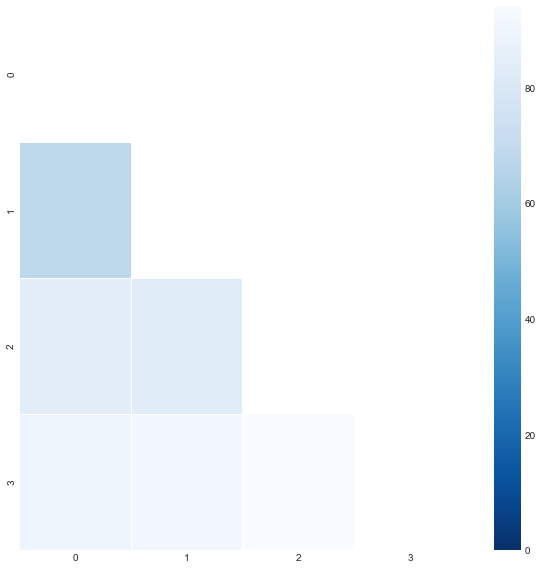


- Mean variance in prototype selection:  63.625

- Final number of prototypes:  4

# Finished in 0.2340 secs


------------   2    -------------
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
set()
Final:
[17, 21, 3, 13]

- Prototypes selected
[17 21  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


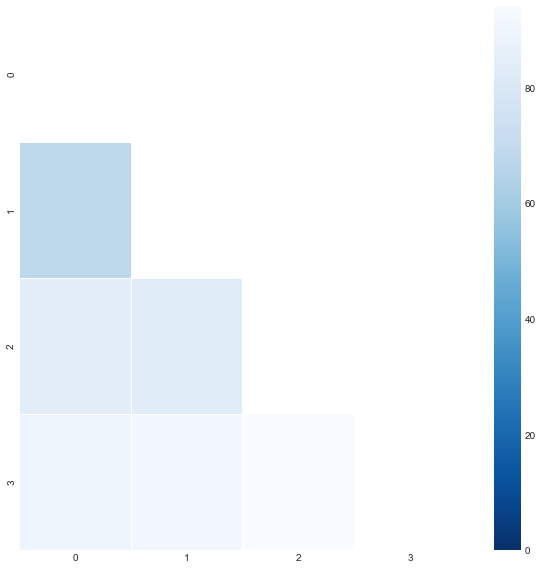


- Mean variance in prototype selection:  63.625

- Final number of prototypes:  4

# Finished in 0.1869 secs


------------   3    -------------
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
set()
Final:
[17, 21, 3, 13]

- Prototypes selected
[17 21  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


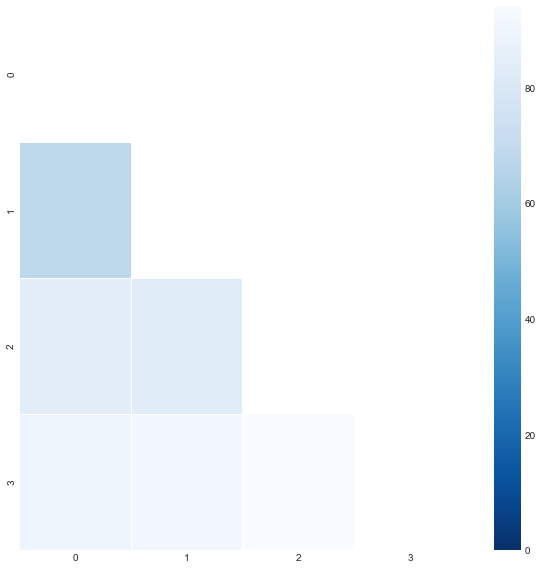


- Mean variance in prototype selection:  63.625

- Final number of prototypes:  4

# Finished in 0.1560 secs


------------   4    -------------
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
{21}
Final:
[17, 3, 13]

- Prototypes selected
[17  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


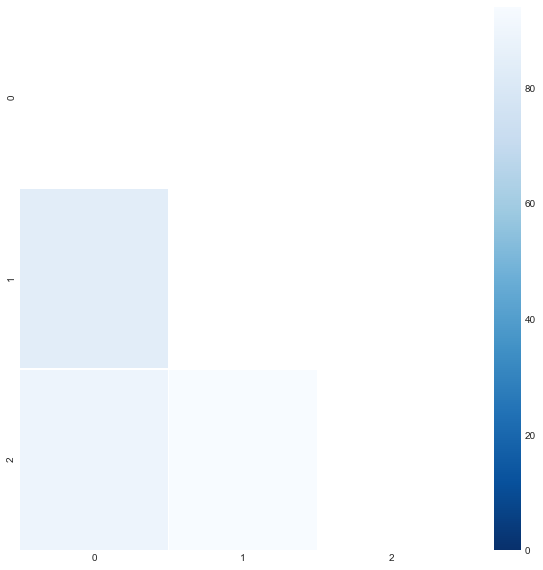


- Mean variance in prototype selection:  59.333333333333336

- Final number of prototypes:  3

# Finished in 0.1408 secs


------------   5    -------------
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
{17, 21, 13}
Final:
[3]

- Prototypes selected
[3]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 

- Final number of prototypes:  1

# Finished in 0.0325 secs


------------   6    -------------
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###############################################


50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
set()
Final:
[17, 3, 21, 9, 13]

- Prototypes selected
[17  3 21  9 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
21  ->  b. buth et. al.  provably correct compiler implementation  nan
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


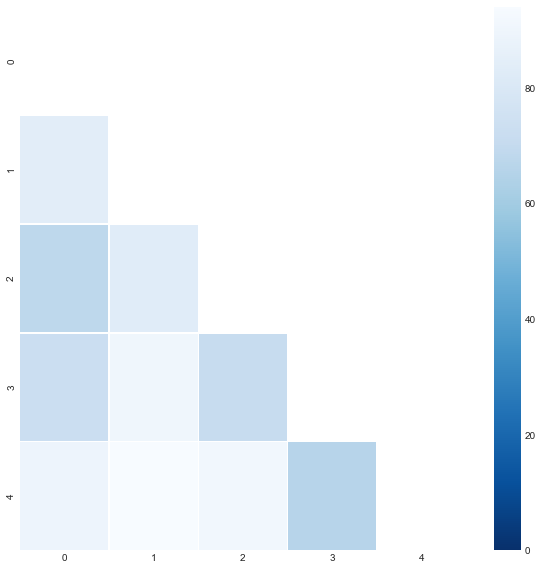


- Mean variance in prototype selection:  64.72

- Final number of prototypes:  5

# Finished in 0.1643 secs


------------   7    -------------
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
set()
Final:
[17, 3, 21, 9, 13]

- Prototypes selected
[17  3 21  9 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
21  ->  b. buth et. al.  provably correct compiler implementation  nan
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


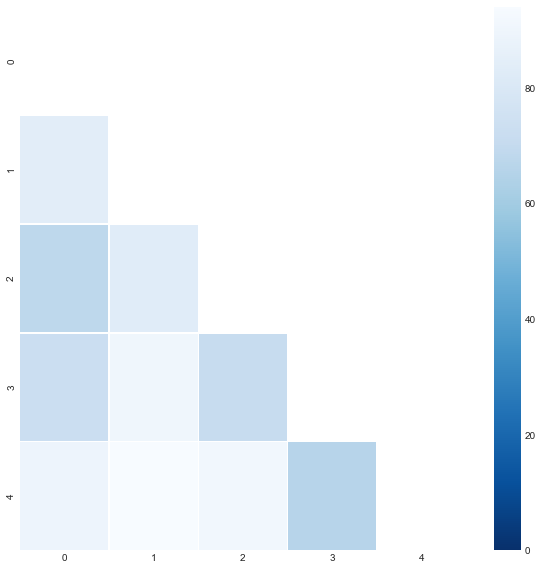


- Mean variance in prototype selection:  64.72

- Final number of prototypes:  5

# Finished in 0.1535 secs


------------   8    -------------
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
set()
Final:
[17, 3, 21, 9, 13]

- Prototypes selected
[17  3 21  9 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
21  ->  b. buth et. al.  provably correct compiler implementation  nan
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


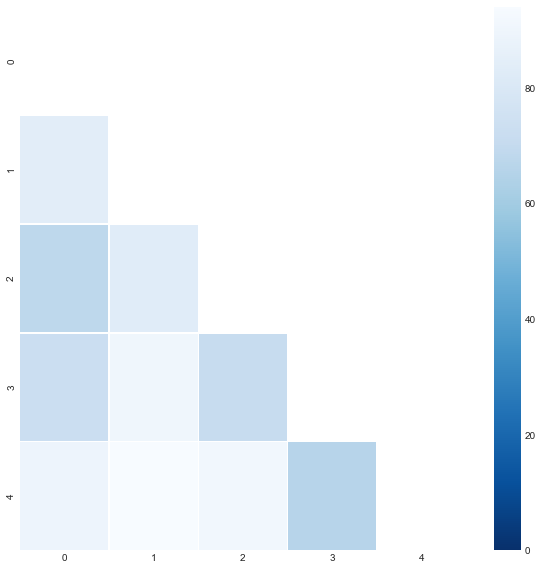


- Mean variance in prototype selection:  64.72

- Final number of prototypes:  5

# Finished in 0.1654 secs


------------   9    -------------
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
{21, 13}
Final:
[9, 3, 17]

- Prototypes selected
[ 9  3 17]
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan


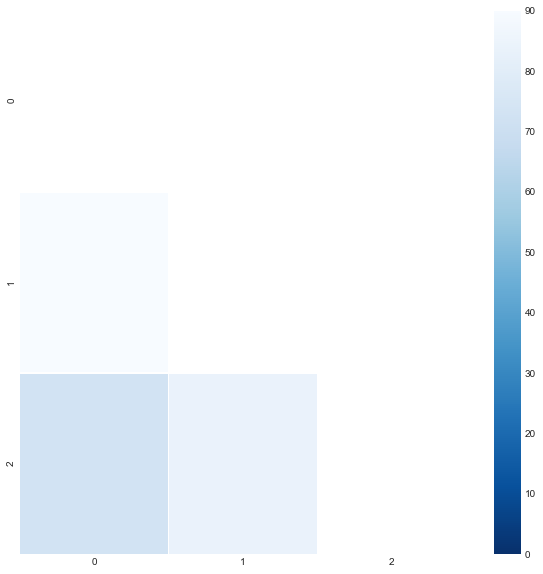


- Mean variance in prototype selection:  54.888888888888886

- Final number of prototypes:  3

# Finished in 0.1644 secs


------------   10    -------------
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
{9, 21, 13, 17}
Final:
[3]

- Prototypes selected
[3]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 

- Final number of prototypes:  1

# Finished in 0.0190 secs


------------   11    -------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
########################################


100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
set()
Final:
[34, 3, 38, 46, 17, 51, 21, 24, 28, 30]

- Prototypes selected
[34  3 38 46 17 51 21 24 28 30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
38  ->  fahle  m. w. and edelman  s. learning in hyperacuity: influence of stimulus range and of feedback. vision research.
46  ->  fahle  m. specificity of learning curvature  orientation  and vernier discriminations. vision research 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
21  ->  b. buth et. al.  provably corr

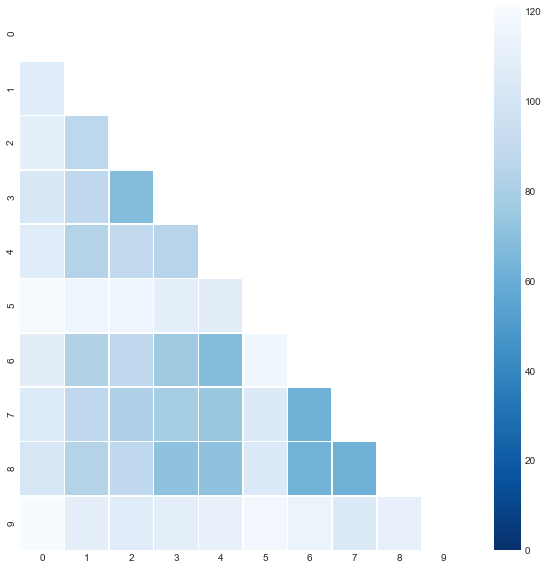


- Mean variance in prototype selection:  85.52

- Final number of prototypes:  10

# Finished in 0.1979 secs


------------   12    -------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
set()
Final:
[34, 3, 38, 46, 17, 51, 21, 24, 28, 30]

- Prototypes selected
[34  3 38 46 17 51 21 24 28 30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
38  ->  fahle  m. w. and edelman  s. learning in hyperacuity: influence of stimulus range and of feedback. vision research.
46  ->  fahle  m. specificity of learning curvature  orientation  and vernier discriminations. vision research 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
21  ->  b. buth et. al.  provably corr

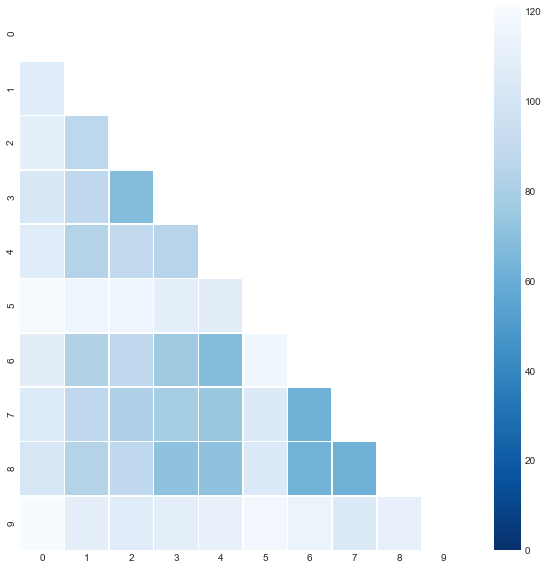


- Mean variance in prototype selection:  85.52

- Final number of prototypes:  10

# Finished in 0.4090 secs


------------   13    -------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
set()
Final:
[34, 3, 38, 46, 17, 51, 21, 24, 28, 30]

- Prototypes selected
[34  3 38 46 17 51 21 24 28 30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
38  ->  fahle  m. w. and edelman  s. learning in hyperacuity: influence of stimulus range and of feedback. vision research.
46  ->  fahle  m. specificity of learning curvature  orientation  and vernier discriminations. vision research 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
21  ->  b. buth et. al.  provably corr

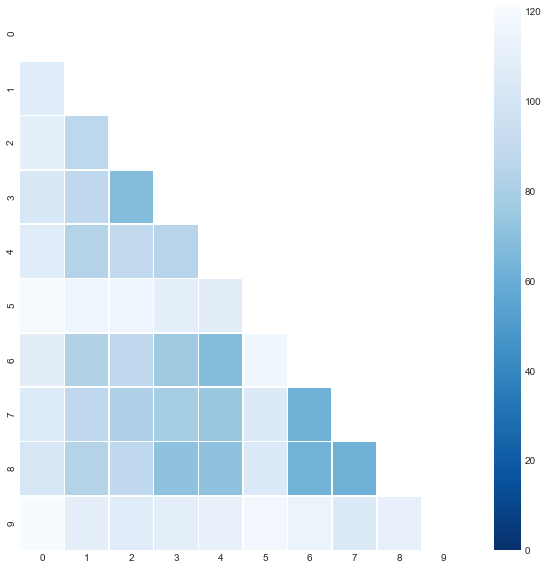


- Mean variance in prototype selection:  85.52

- Final number of prototypes:  10

# Finished in 0.2009 secs


------------   14    -------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
{24, 28, 21, 46}
Final:
[34, 3, 38, 17, 51, 30]

- Prototypes selected
[34  3 38 17 51 30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
38  ->  fahle  m. w. and edelman  s. learning in hyperacuity: influence of stimulus range and of feedback. vision research.
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
30  ->  dempster  a.  laird  n.  and rubin  d. maximum likelihood from incomplete data via the em algorithm. journal of the royal statistical society b 


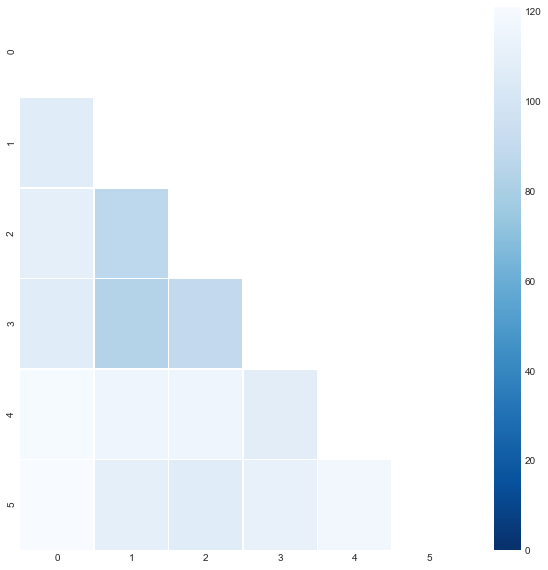


- Mean variance in prototype selection:  89.38888888888889

- Final number of prototypes:  6

# Finished in 0.1750 secs


------------   15    -------------
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
{38, 46, 17, 21, 24, 28}
Final:
[51, 34, 3, 30]

- Prototypes selected
[51 34  3 30]
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
30  ->  dempster  a.  laird  n.  and rubin  d. maximum likelihood from incomplete data via the em algorithm. journal of the royal statistical society b 


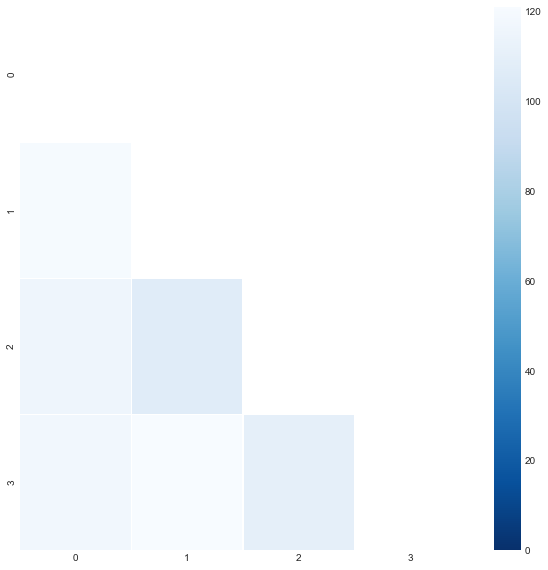


- Mean variance in prototype selection:  86.25

- Final number of prototypes:  4

# Finished in 0.1490 secs


------------   16    -------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

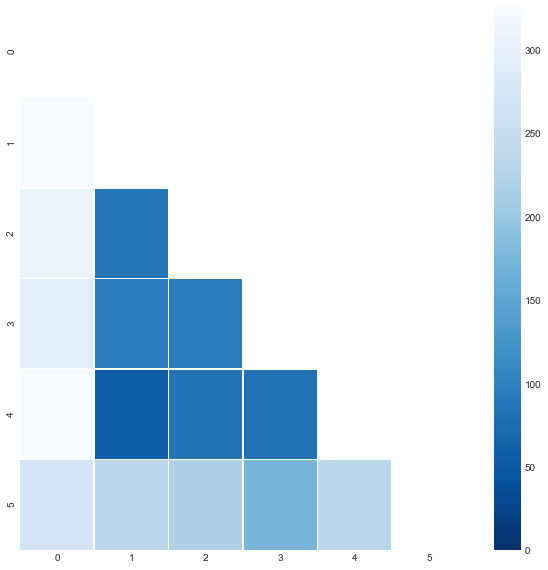


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2086 secs


------------   17    -------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

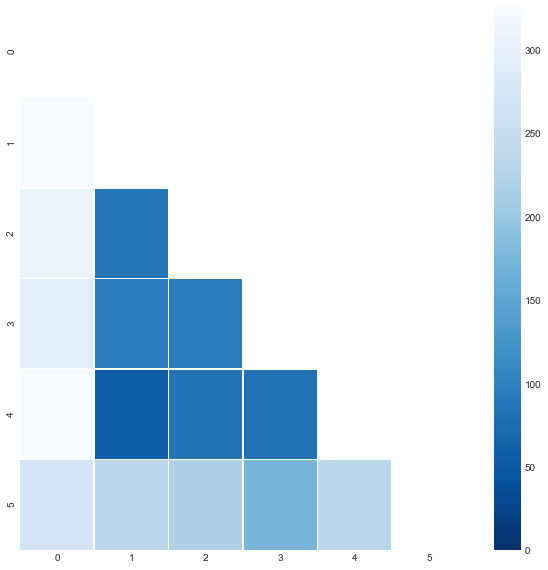


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2391 secs


------------   18    -------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

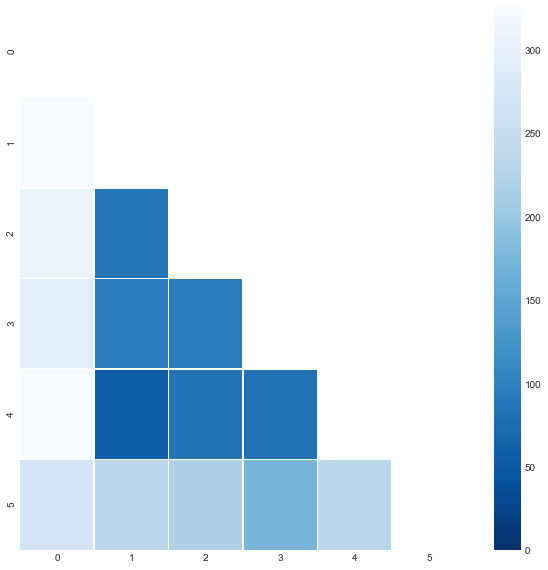


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2184 secs


------------   19    -------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

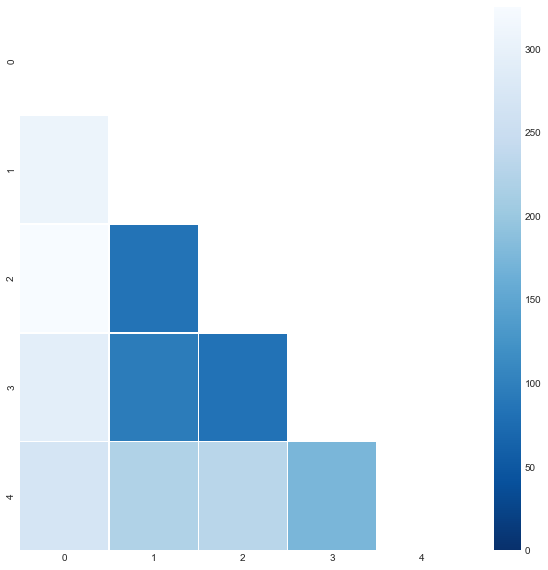


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.2417 secs


------------   20    -------------
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


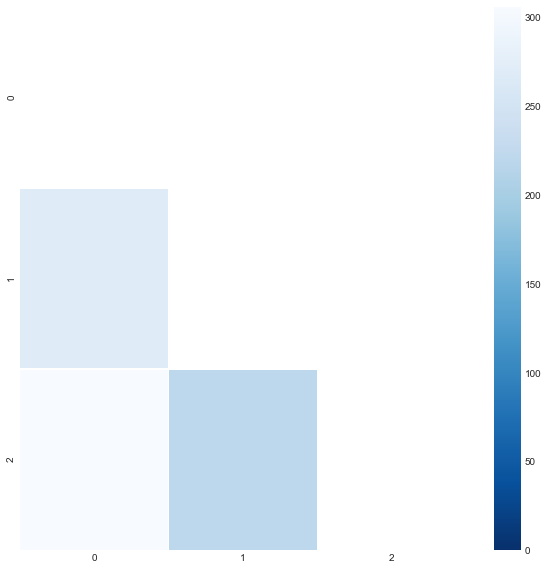


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.2311 secs


------------   21    -------------
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{160, 136, 110, 244, 309, 250, 284, 190}
Final:
[384, 3, 13, 17, 21, 405, 152, 28, 30, 415, 32, 34, 419, 39, 41, 44, 47, 178, 51, 59, 65, 203, 97, 100, 105, 107]

- Prototypes selected
[384   3  13  17  21 405 152  28  30 415  32  34 419  39  41  44  47 178
  51  59  65 203  97 100 105 107]
384  ->  s.e. fahlman and c. lebiere  the cascade-correlation learning architecture  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  

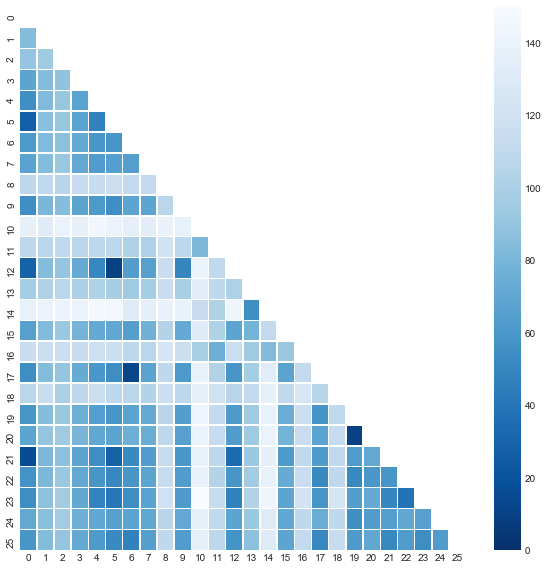


- Mean variance in prototype selection:  86.1508875739645

- Final number of prototypes:  26

# Finished in 0.3907 secs


------------   22    -------------
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{160, 65, 384, 419, 136, 110, 178, 244, 309, 250, 284, 190}
Final:
[3, 13, 17, 21, 405, 152, 28, 30, 415, 32, 34, 39, 41, 44, 47, 51, 59, 203, 97, 100, 105, 107]

- Prototypes selected
[  3  13  17  21 405 152  28  30 415  32  34  39  41  44  47  51  59 203
  97 100 105 107]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
405  ->  s. fahlman. the recurrent cascade-correlation architecture. nan
152  ->  fahlman  s. e. an e

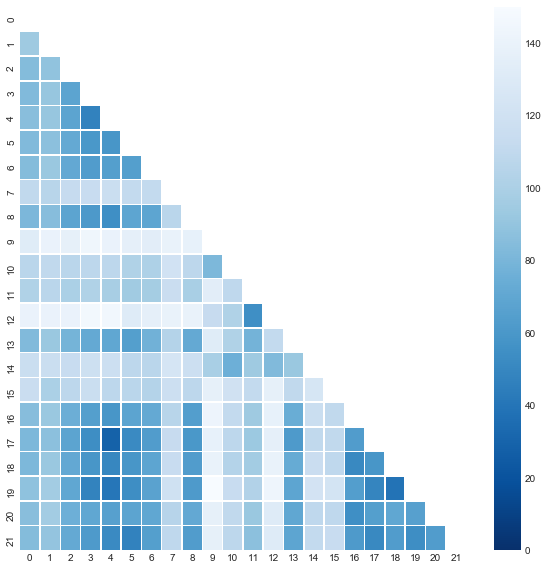


- Mean variance in prototype selection:  89.98347107438016

- Final number of prototypes:  22

# Finished in 0.3407 secs


------------   23    -------------
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{160, 65, 384, 419, 100, 136, 110, 178, 244, 309, 405, 250, 284, 190}
Final:
[3, 13, 17, 21, 152, 28, 30, 415, 32, 34, 39, 41, 44, 47, 51, 59, 203, 97, 105, 107]

- Prototypes selected
[  3  13  17  21 152  28  30 415  32  34  39  41  44  47  51  59 203  97
 105 107]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
152  ->  fahlman  s. e. an empirical study of learning speed in backpropagation networks. nan
28  ->  nan an 

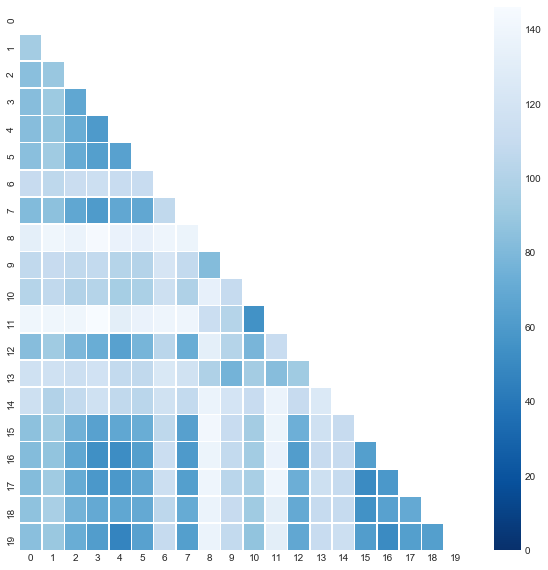


- Mean variance in prototype selection:  92.03

- Final number of prototypes:  20

# Finished in 0.2957 secs


------------   24    -------------
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{384, 136, 21, 405, 152, 28, 284, 415, 160, 419, 41, 178, 309, 59, 190, 65, 203, 97, 100, 105, 107, 110, 244, 250}
Final:
[32, 34, 3, 39, 44, 13, 47, 17, 51, 30]

- Prototypes selected
[32 34  3 39 44 13 47 17 51 30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
39  ->  m fahle and s edelman. long-term learning in vernier acuity: effects of stimulus orientation  range and of feedback. vision resear

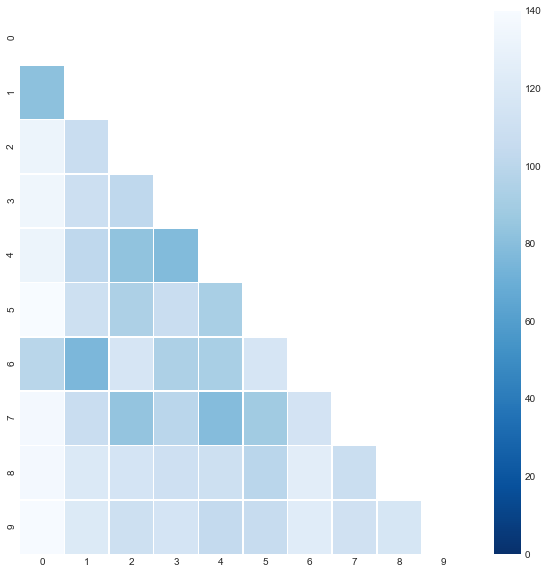


- Mean variance in prototype selection:  97.62

- Final number of prototypes:  10

# Finished in 0.2239 secs


------------   25    -------------
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{384, 136, 13, 17, 21, 405, 152, 28, 284, 415, 160, 34, 419, 39, 41, 44, 47, 178, 309, 59, 190, 65, 203, 97, 100, 105, 107, 110, 244, 250}
Final:
[32, 51, 3, 30]

- Prototypes selected
[32 51  3 30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
30  ->  dempster  a.  laird  n.  and rubin  d. maximum likelihood from incomplete data via the em algorithm. journal of the royal statistical soc

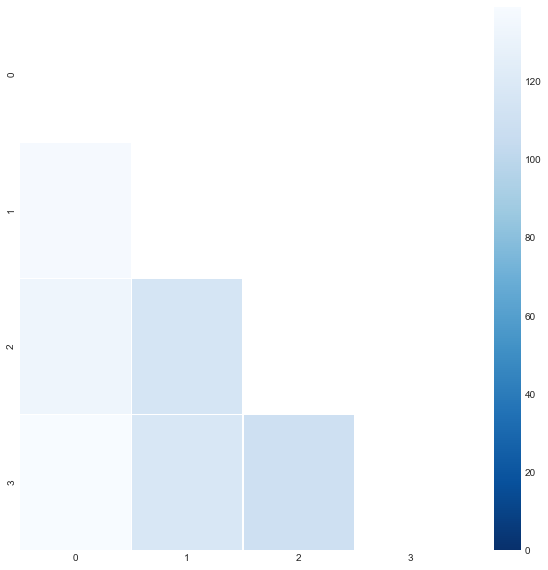


- Mean variance in prototype selection:  93.75

- Final number of prototypes:  4

# Finished in 0.1840 secs


------------   26    -------------
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
set()
Final:
[3, 9, 13, 17, 21, 28, 30, 415, 32, 34, 418, 36, 38, 40, 424, 426, 428, 45, 430, 47, 432, 51, 180, 442, 60, 451, 453, 456, 462, 467, 472, 477, 480, 97, 482, 100, 102, 105, 117, 253]

- Prototypes selected
[  3   9  13  17  21  28  30 415  32  34 418  36  38  40 424 426 428  45
 430  47 432  51 180 442  60 451 453 456 462 467 472 477 480  97 482 100
 102 105 117 253]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d.

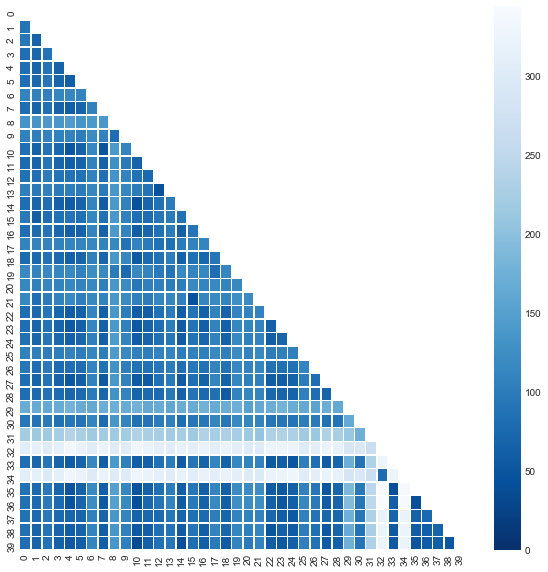


- Mean variance in prototype selection:  118.82125

- Final number of prototypes:  40

# Finished in 0.5528 secs


------------   27    -------------
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
set()
Final:
[3, 9, 13, 17, 21, 28, 30, 415, 32, 34, 418, 36, 38, 40, 424, 426, 428, 45, 430, 47, 432, 51, 180, 442, 60, 451, 453, 456, 462, 467, 472, 477, 480, 97, 482, 100, 102, 105, 117, 253]

- Prototypes selected
[  3   9  13  17  21  28  30 415  32  34 418  36  38  40 424 426 428  45
 430  47 432  51 180 442  60 451 453 456 462 467 472 477 480  97 482 100
 102 105 117 253]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d.

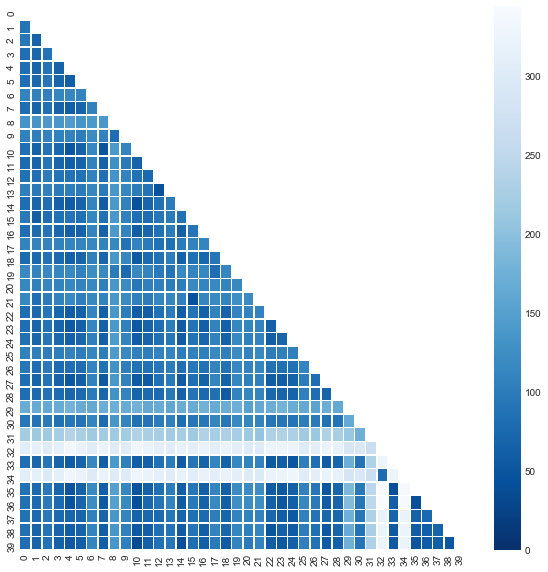


- Mean variance in prototype selection:  118.82125

- Final number of prototypes:  40

# Finished in 0.5821 secs


------------   28    -------------
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
{418, 100}
Final:
[3, 9, 13, 17, 21, 28, 30, 415, 32, 34, 36, 38, 40, 424, 426, 428, 45, 430, 47, 432, 51, 180, 442, 60, 451, 453, 456, 462, 467, 472, 477, 480, 97, 482, 102, 105, 117, 253]

- Prototypes selected
[  3   9  13  17  21  28  30 415  32  34  36  38  40 424 426 428  45 430
  47 432  51 180 442  60 451 453 456 462 467 472 477 480  97 482 102 105
 117 253]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d. a. watt. act

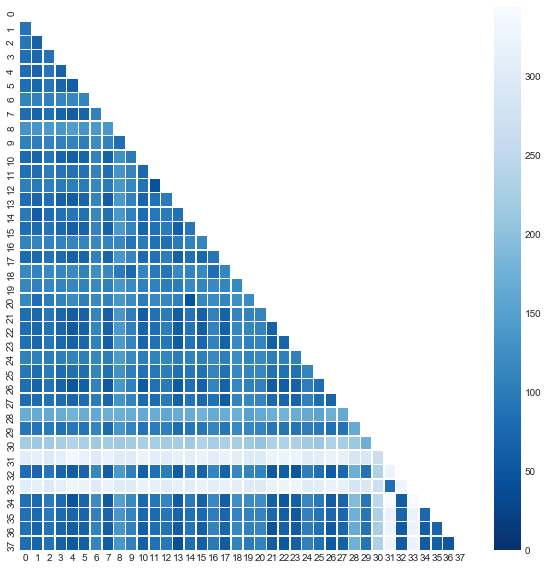


- Mean variance in prototype selection:  121.15789473684211

- Final number of prototypes:  38

# Finished in 0.5360 secs


------------   29    -------------
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
{13, 21, 28, 415, 418, 36, 424, 40, 426, 428, 430, 180, 442, 60, 456, 462, 97, 100, 102, 105, 117, 253}
Final:
[32, 480, 34, 3, 451, 453, 38, 482, 9, 45, 47, 432, 17, 51, 467, 472, 477, 30]

- Prototypes selected
[ 32 480  34   3 451 453  38 482   9  45  47 432  17  51 467 472 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
480  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski ands.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de weldel  w. wenzel  j. wnek  and j. zhang. the

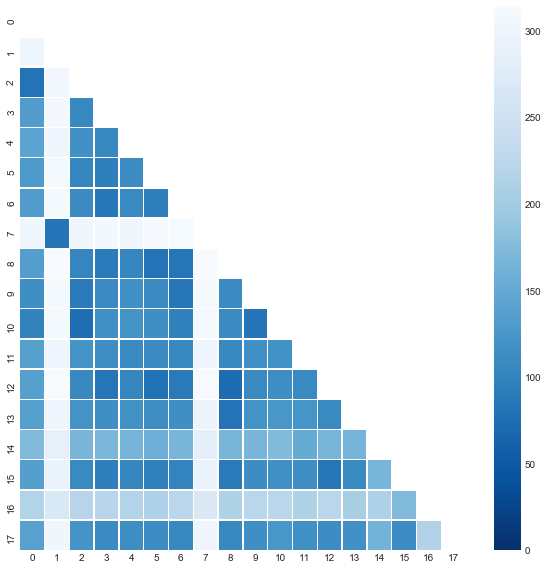


- Mean variance in prototype selection:  155.25925925925927

- Final number of prototypes:  18

# Finished in 0.2800 secs


------------   30    -------------
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
{9, 13, 17, 21, 28, 415, 418, 34, 36, 38, 424, 40, 426, 428, 45, 430, 47, 432, 51, 180, 442, 60, 453, 456, 462, 472, 97, 482, 100, 102, 105, 117, 253}
Final:
[32, 480, 3, 451, 467, 477, 30]

- Prototypes selected
[ 32 480   3 451 467 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
480  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski ands.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de weldel  w. wenzel  j. wnek  and j. zhang. the monk's problems: a performance comparison o

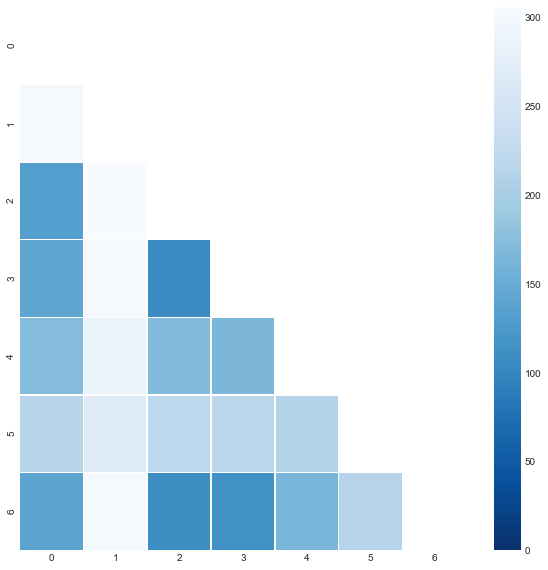


- Mean variance in prototype selection:  173.87755102040816

- Final number of prototypes:  7

# Finished in 0.2069 secs


------------   31    -------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

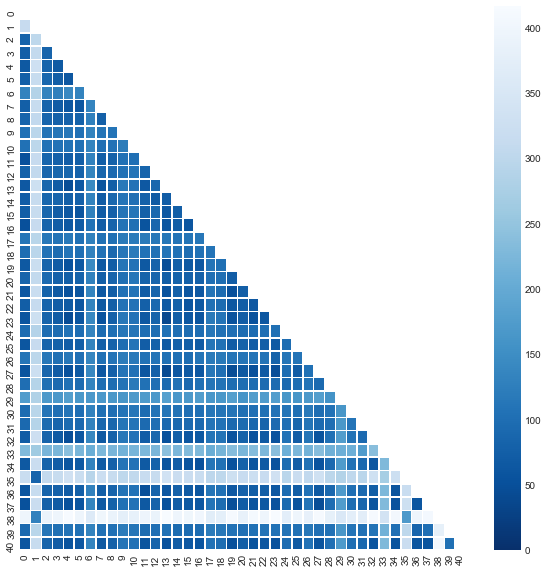


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.7895 secs


------------   32    -------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

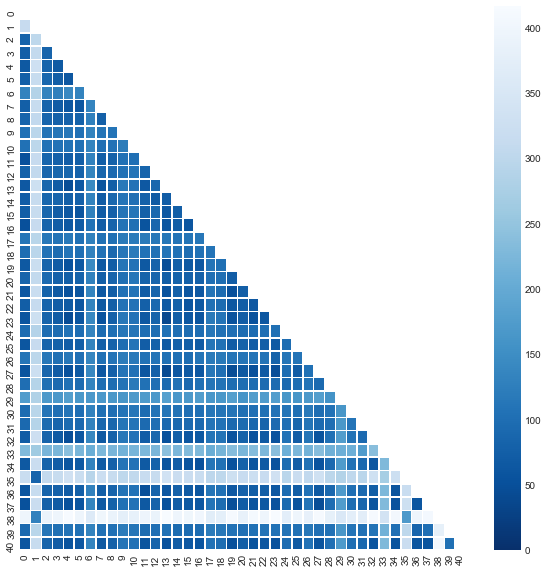


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.5954 secs


------------   33    -------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{1861}
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1478  457 1867  718 1870
  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitc

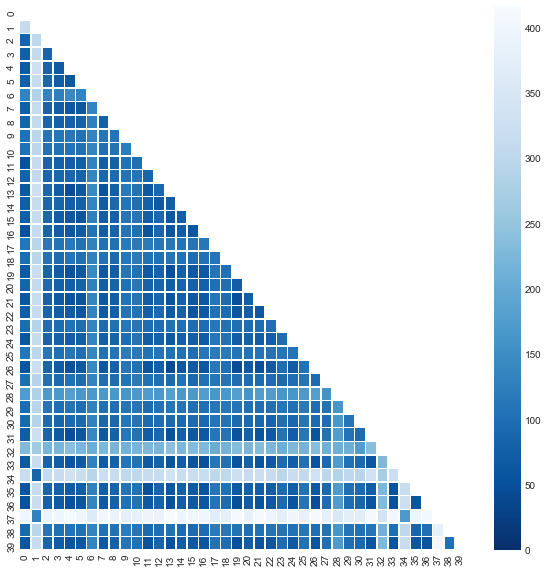


- Mean variance in prototype selection:  131.6675

- Final number of prototypes:  40

# Finished in 0.5759 secs


------------   34    -------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 21, 24, 28, 804, 1577, 46, 1327, 1202, 442, 1343, 707, 452, 1861, 457, 718, 1878, 1123, 1261, 751, 243}
Final:
[514, 3, 17, 1306, 1437, 30, 34, 38, 51, 1336, 1478, 1867, 1870, 467, 726, 471, 476, 488, 496, 1392]

- Prototypes selected
[ 514    3   17 1306 1437   30   34   38   51 1336 1478 1867 1870  467
  726  471  476  488  496 1392]
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de welde  w. wenzel  j. wnek  and j. zhang  the monk's problems a performance comparison of different learning algorithms. nan
3  ->  m. ahlskog  j. 

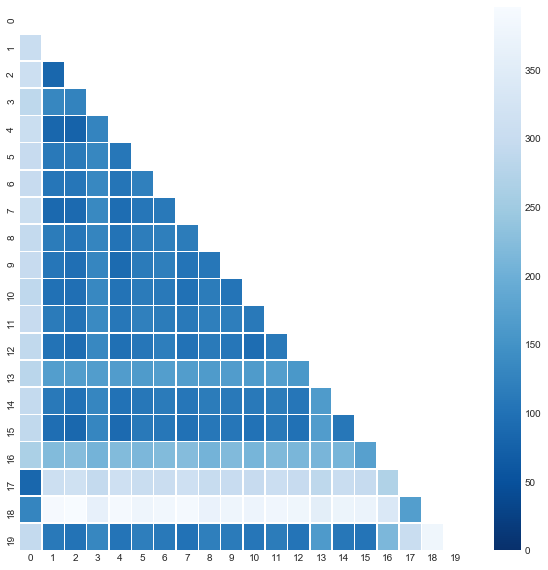


- Mean variance in prototype selection:  171.56

- Final number of prototypes:  20

# Finished in 0.3512 secs


------------   35    -------------
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 514, 17, 21, 24, 28, 1437, 804, 38, 1577, 46, 1327, 1202, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 1878, 471, 726, 1123, 1261, 751, 1392, 243}
Final:
[34, 3, 488, 496, 51, 467, 1306, 476, 30]

- Prototypes selected
[  34    3  488  496   51  467 1306  476   30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
488  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnink  b.  cheng  j.  dejong  k.a.  dzeroski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  mi

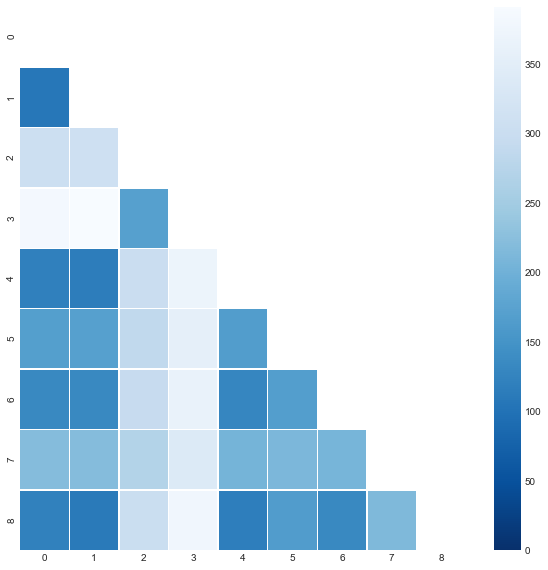


- Mean variance in prototype selection:  201.11111111111111

- Final number of prototypes:  9

# Finished in 0.2659 secs


------------   36    -------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

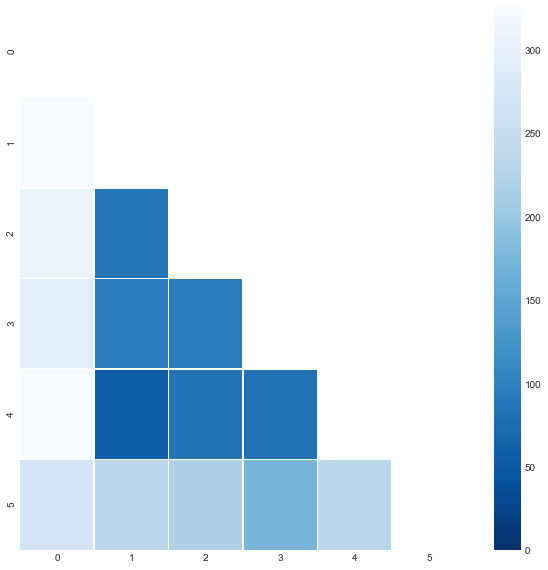


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2373 secs


------------   37    -------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

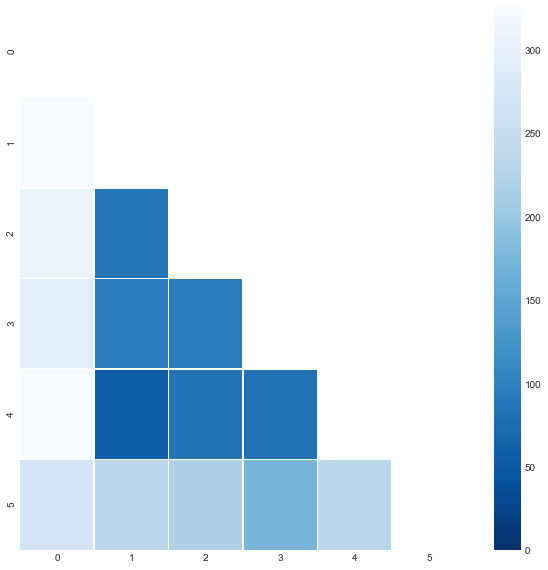


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2409 secs


------------   38    -------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

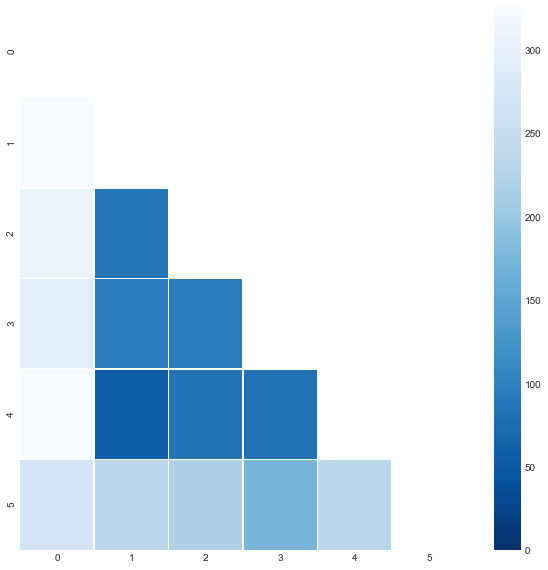


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2520 secs


------------   39    -------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

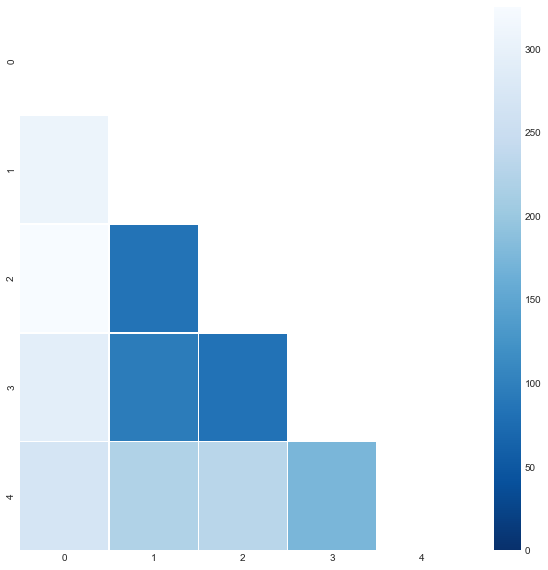


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.2280 secs


------------   40    -------------
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


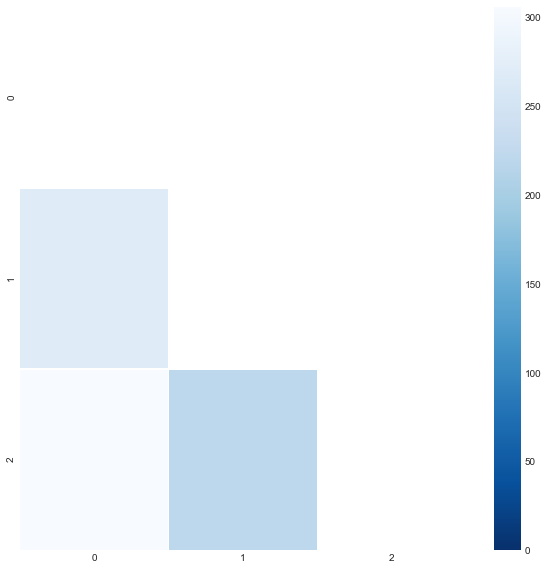


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.2040 secs


------------   41    -------------
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{160, 515, 136, 488, 492, 110, 244, 309, 250, 284, 190, 511}
Final:
[384, 3, 518, 13, 525, 17, 531, 21, 405, 152, 28, 30, 415, 32, 34, 419, 39, 424, 41, 426, 44, 47, 178, 51, 562, 442, 59, 65, 451, 453, 456, 203, 462, 472, 477, 480, 97, 482, 100, 484, 486, 105, 107, 496, 501, 504, 507]

- Prototypes selected
[384   3 518  13 525  17 531  21 405 152  28  30 415  32  34 419  39 424
  41 426  44  47 178  51 562 442  59  65 451 453 456 203 462 472 477 480
  97 482 100 484 486 105 107 496 501 504 507]
384  ->  s.e. fahlman and c. lebiere  the cascade-correlation learning architecture  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. ander

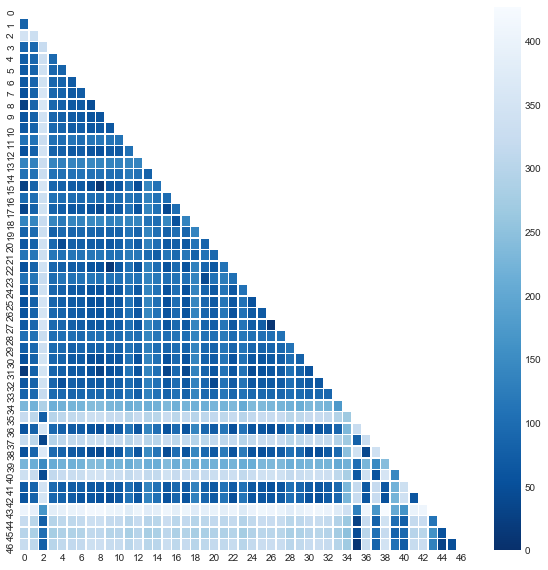


- Mean variance in prototype selection:  161.22951561792667

- Final number of prototypes:  47

# Finished in 0.5249 secs


------------   42    -------------
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{160, 65, 384, 419, 515, 136, 488, 492, 110, 178, 244, 309, 250, 507, 284, 190, 511}
Final:
[3, 518, 525, 13, 17, 531, 21, 405, 152, 28, 30, 415, 32, 34, 39, 424, 41, 426, 44, 47, 562, 51, 442, 59, 451, 453, 456, 203, 462, 472, 477, 480, 97, 482, 100, 484, 486, 105, 107, 496, 501, 504]

- Prototypes selected
[  3 518 525  13  17 531  21 405 152  28  30 415  32  34  39 424  41 426
  44  47 562  51 442  59 451 453 456 203 462 472 477 480  97 482 100 484
 486 105 107 496 501 504]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
518  ->  thurn  s. b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  d

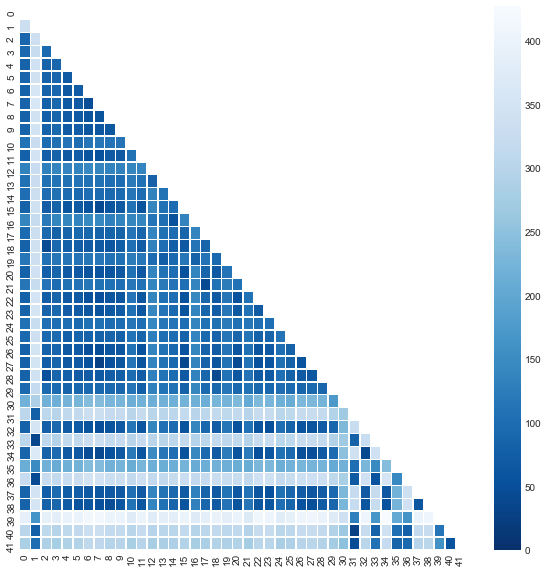


- Mean variance in prototype selection:  162.77324263038548

- Final number of prototypes:  42

# Finished in 0.5896 secs


------------   43    -------------
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{384, 515, 518, 136, 405, 284, 160, 419, 424, 178, 309, 190, 65, 100, 488, 492, 110, 244, 501, 250, 507, 511}
Final:
[3, 525, 13, 17, 531, 21, 152, 28, 30, 415, 32, 34, 39, 41, 426, 44, 47, 562, 51, 442, 59, 451, 453, 456, 203, 462, 472, 477, 480, 97, 482, 484, 486, 105, 107, 496, 504]

- Prototypes selected
[  3 525  13  17 531  21 152  28  30 415  32  34  39  41 426  44  47 562
  51 442  59 451 453 456 203 462 472 477 480  97 482 484 486 105 107 496
 504]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
525  ->  weiss  y.  edelman  s.  and fahle  m. models of perceptual learning in vernier hyperacuity. neu

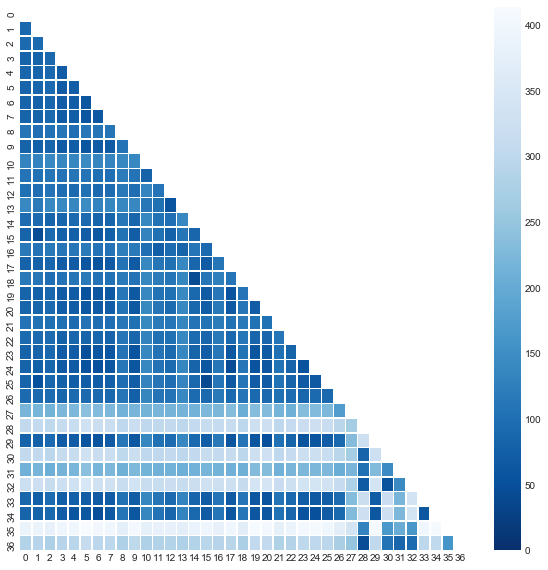


- Mean variance in prototype selection:  155.40102264426588

- Final number of prototypes:  37

# Finished in 0.5399 secs


------------   44    -------------
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{384, 515, 518, 136, 525, 531, 21, 405, 152, 28, 284, 415, 160, 419, 424, 41, 426, 178, 562, 309, 442, 59, 190, 65, 456, 203, 462, 97, 100, 486, 488, 105, 107, 492, 110, 244, 501, 504, 250, 507, 511}
Final:
[32, 480, 34, 3, 451, 453, 482, 39, 484, 44, 13, 47, 496, 17, 51, 472, 477, 30]

- Prototypes selected
[ 32 480  34   3 451 453 482  39 484  44  13  47 496  17  51 472 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
480  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski ands.e. fahlman

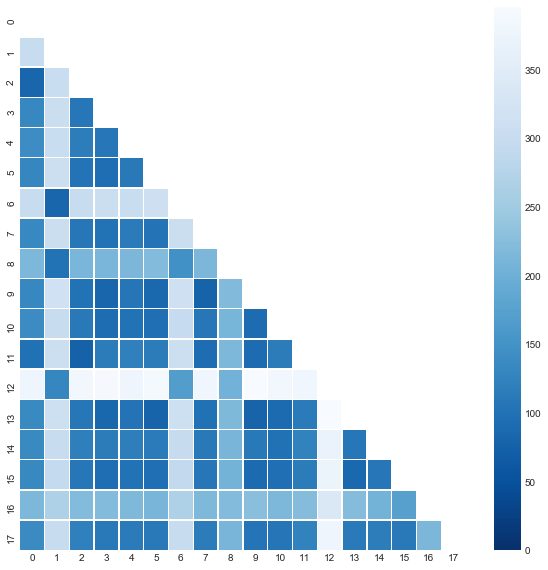


- Mean variance in prototype selection:  177.7716049382716

- Final number of prototypes:  18

# Finished in 0.3130 secs


------------   45    -------------
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{384, 515, 518, 136, 13, 525, 17, 531, 21, 405, 152, 28, 284, 415, 160, 34, 419, 39, 424, 41, 426, 44, 47, 178, 562, 309, 442, 59, 190, 65, 451, 453, 456, 203, 462, 472, 97, 482, 100, 486, 488, 105, 107, 492, 110, 244, 501, 504, 250, 507, 511}
Final:
[32, 480, 3, 484, 496, 51, 477, 30]

- Prototypes selected
[ 32 480   3 484 496  51 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
480  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski ands.e. fahlman  d. fisher  r. hamann  k. kaufman  s. k

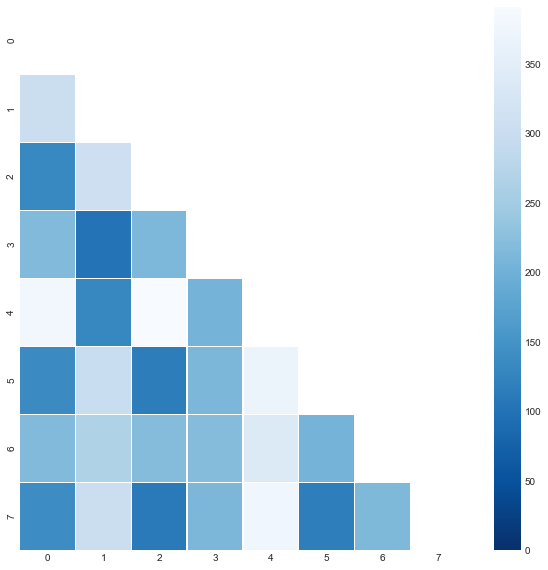


- Mean variance in prototype selection:  201.34375

- Final number of prototypes:  8

# Finished in 0.2505 secs


------------   46    -------------
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 488, 713, 492, 1015, 755, 503, 1021, 510}
Final:
[3, 518, 774, 520, 9, 778, 13, 525, 783, 528, 17, 785, 531, 788, 21, 792, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 821, 60, 842, 852, 857, 603, 97, 867, 100, 102, 105, 874, 883, 117, 888, 415, 418, 424, 426, 428, 430, 432, 180, 948, 442, 702, 451, 708, 453, 711, 456, 462, 720, 467, 725, 472, 729, 731, 477, 734, 480, 482, 484, 745, 1006, 496, 1009, 1011, 500, 1013, 1017, 253]

- Prototypes selected
[   3  518  774  520    9  778   13  525  783  528   17  785  531  788
   21  792   

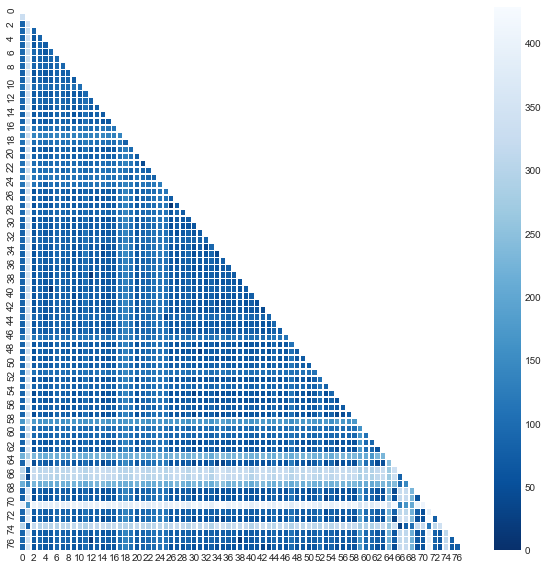


- Mean variance in prototype selection:  121.16995397764629

- Final number of prototypes:  78

# Finished in 0.6590 secs


------------   47    -------------
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 488, 713, 842, 492, 883, 1015, 755, 503, 888, 1017, 1021, 510}
Final:
[3, 518, 774, 520, 9, 778, 13, 525, 783, 528, 17, 785, 531, 788, 21, 792, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 821, 60, 852, 857, 603, 97, 867, 100, 102, 105, 874, 117, 415, 418, 424, 426, 428, 430, 432, 180, 948, 442, 702, 451, 708, 453, 711, 456, 462, 720, 467, 725, 472, 729, 731, 477, 734, 480, 482, 484, 745, 1006, 496, 1009, 1011, 500, 1013, 253]

- Prototypes selected
[   3  518  774  520    9  778   13  525  783  528   17  785  531  788
   21  792   

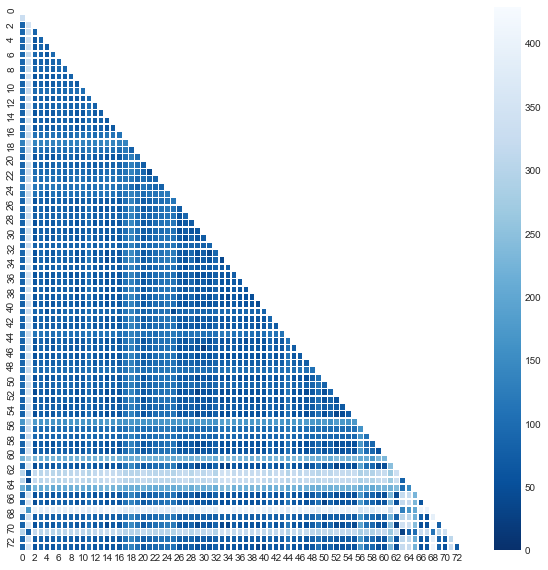


- Mean variance in prototype selection:  123.53287070854638

- Final number of prototypes:  74

# Finished in 0.6405 secs


------------   48    -------------
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 518, 418, 948, 713, 842, 720, 857, 734, 503, 100, 488, 492, 1006, 1011, 500, 883, 755, 1015, 888, 1017, 1021, 510}
Final:
[3, 774, 520, 9, 778, 525, 13, 783, 528, 17, 785, 531, 788, 21, 792, 28, 30, 415, 32, 34, 36, 38, 40, 424, 426, 428, 45, 430, 47, 432, 51, 180, 821, 442, 60, 702, 451, 708, 453, 711, 456, 462, 467, 852, 725, 472, 729, 603, 731, 477, 480, 97, 482, 867, 484, 102, 105, 745, 874, 496, 1009, 117, 1013, 253]

- Prototypes selected
[   3  774  520    9  778  525   13  783  528   17  785  531  788   21
  792   28   

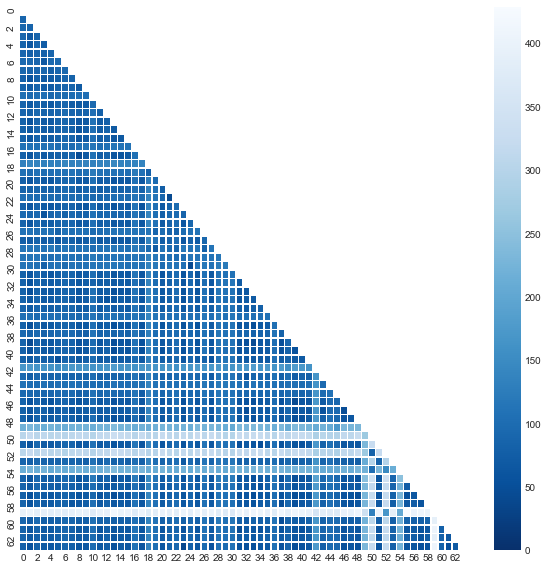


- Mean variance in prototype selection:  118.31640625

- Final number of prototypes:  64

# Finished in 0.5790 secs


------------   49    -------------
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 774, 518, 778, 13, 525, 783, 528, 531, 788, 21, 792, 28, 415, 418, 36, 424, 40, 426, 428, 430, 948, 180, 821, 442, 60, 702, 708, 711, 456, 713, 842, 462, 720, 852, 729, 857, 731, 603, 734, 97, 867, 100, 503, 102, 488, 745, 874, 105, 492, 1006, 1009, 1017, 755, 883, 117, 1011, 1013, 1015, 253, 888, 500, 1021, 510}
Final:
[3, 520, 9, 17, 785, 30, 32, 34, 38, 45, 47, 432, 51, 451, 453, 467, 725, 472, 477, 480, 482, 484, 496]

- Prototypes selected
[  3 520   9  17 785  30  32  34  38  45  47 432  51 451 453 467 725 472
 477 480 48

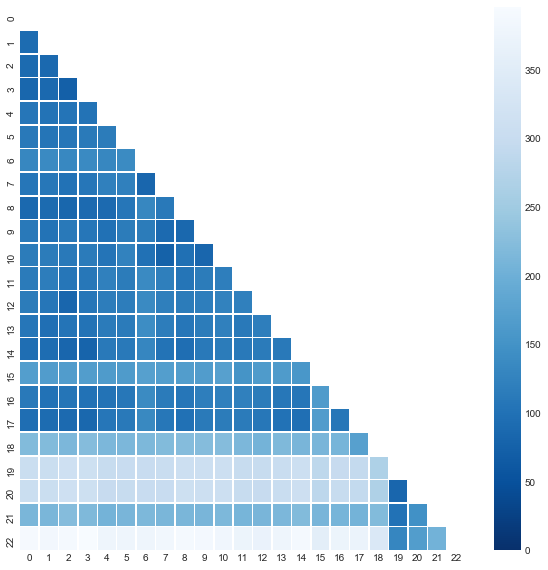


- Mean variance in prototype selection:  169.99243856332703

- Final number of prototypes:  23

# Finished in 0.6870 secs


------------   50    -------------
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 518, 520, 9, 13, 525, 528, 17, 531, 21, 28, 34, 36, 38, 40, 45, 47, 51, 60, 603, 97, 100, 102, 105, 117, 180, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 253, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 415, 418, 424, 426, 428, 430, 432, 948, 442, 453, 456, 462, 472, 482, 488, 492, 1006, 1009, 1011, 1015, 1013, 500, 503, 1017, 1021, 510}
Final:
[32, 480, 3, 451, 484, 496, 467, 477, 30]

- Prototypes selected
[ 32 480   3 451 484 496 467 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(

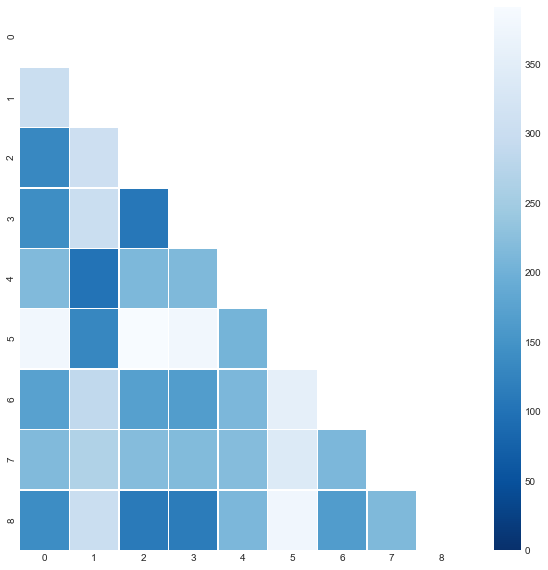


- Mean variance in prototype selection:  202.46913580246914

- Final number of prototypes:  9

# Finished in 0.2730 secs


------------   51    -------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

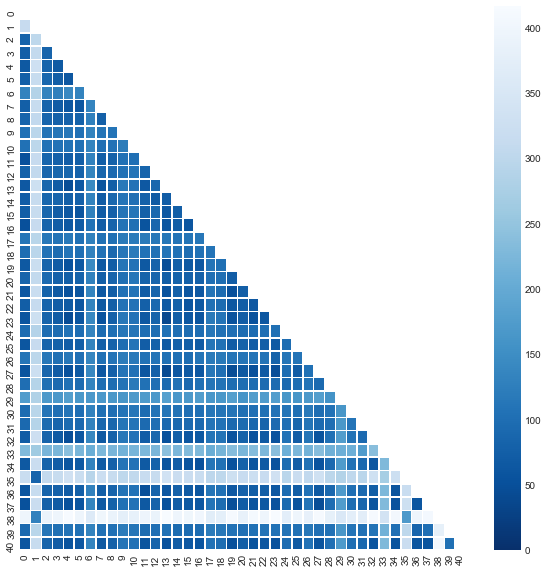


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.5946 secs


------------   52    -------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

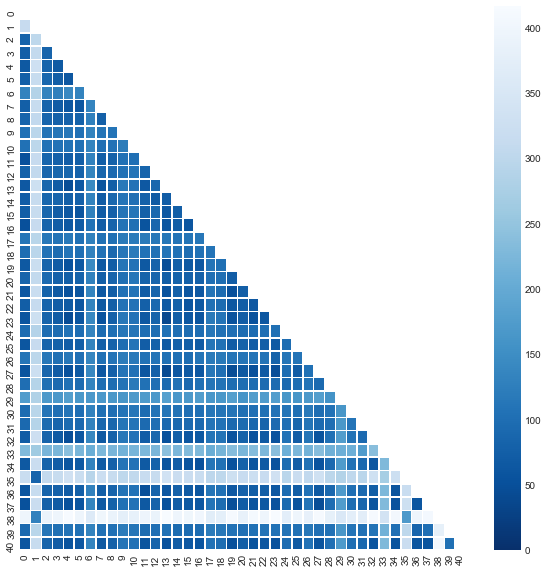


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.5999 secs


------------   53    -------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{1861}
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1478  457 1867  718 1870
  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitc

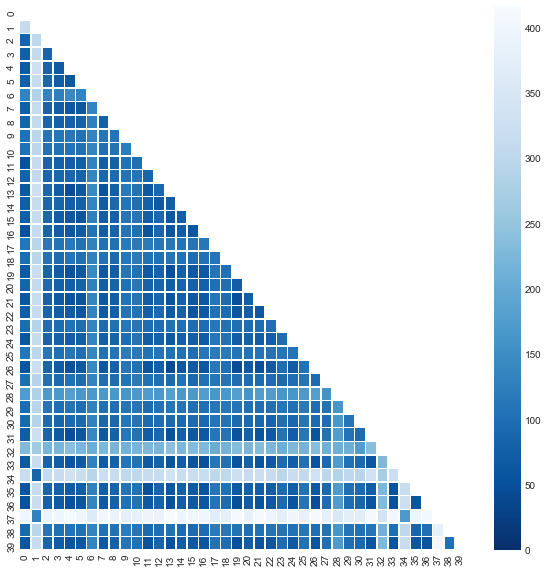


- Mean variance in prototype selection:  131.6675

- Final number of prototypes:  40

# Finished in 0.5870 secs


------------   54    -------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 21, 24, 28, 804, 1577, 46, 1327, 1202, 442, 1343, 707, 452, 1861, 457, 718, 1878, 1123, 1261, 751, 243}
Final:
[514, 3, 17, 1306, 1437, 30, 34, 38, 51, 1336, 1478, 1867, 1870, 467, 726, 471, 476, 488, 496, 1392]

- Prototypes selected
[ 514    3   17 1306 1437   30   34   38   51 1336 1478 1867 1870  467
  726  471  476  488  496 1392]
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de welde  w. wenzel  j. wnek  and j. zhang  the monk's problems a performance comparison of different learning algorithms. nan
3  ->  m. ahlskog  j. 

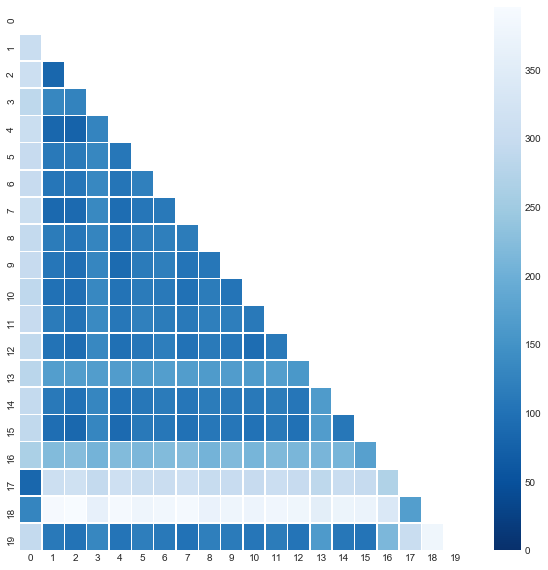


- Mean variance in prototype selection:  171.56

- Final number of prototypes:  20

# Finished in 0.3150 secs


------------   55    -------------
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 514, 17, 21, 24, 28, 1437, 804, 38, 1577, 46, 1327, 1202, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 1878, 471, 726, 1123, 1261, 751, 1392, 243}
Final:
[34, 3, 488, 496, 51, 467, 1306, 476, 30]

- Prototypes selected
[  34    3  488  496   51  467 1306  476   30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
488  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnink  b.  cheng  j.  dejong  k.a.  dzeroski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  mi

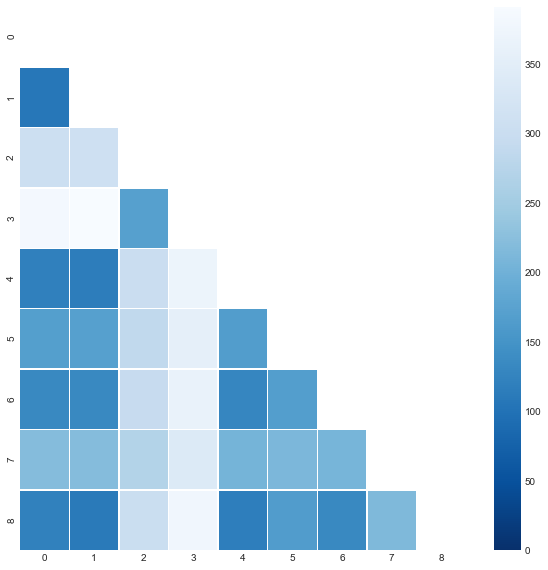


- Mean variance in prototype selection:  201.11111111111111

- Final number of prototypes:  9

# Finished in 0.2620 secs


------------   56    -------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

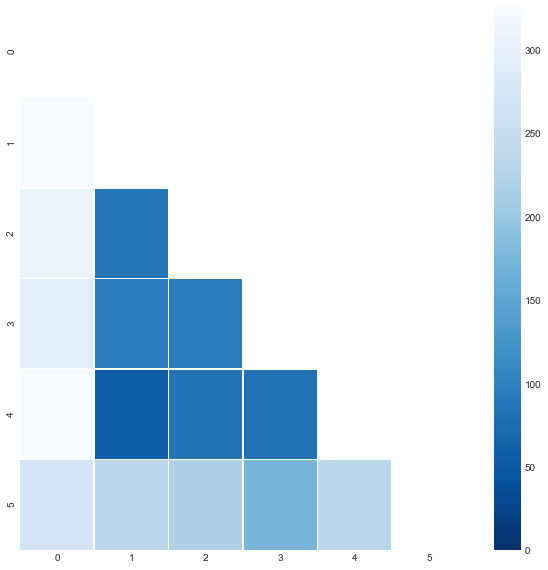


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2429 secs


------------   57    -------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

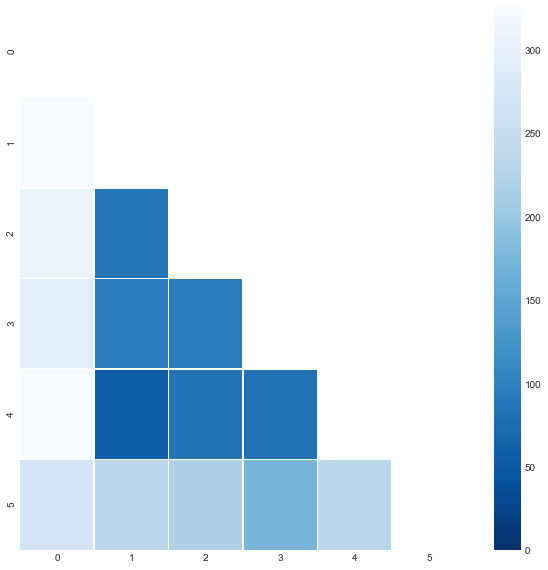


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.3129 secs


------------   58    -------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

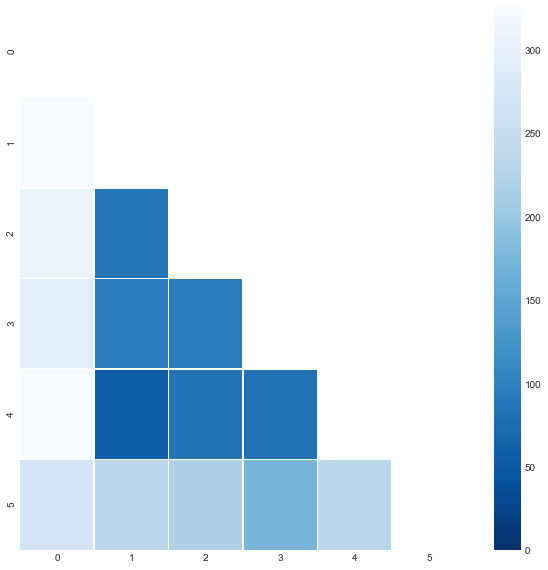


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.3470 secs


------------   59    -------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

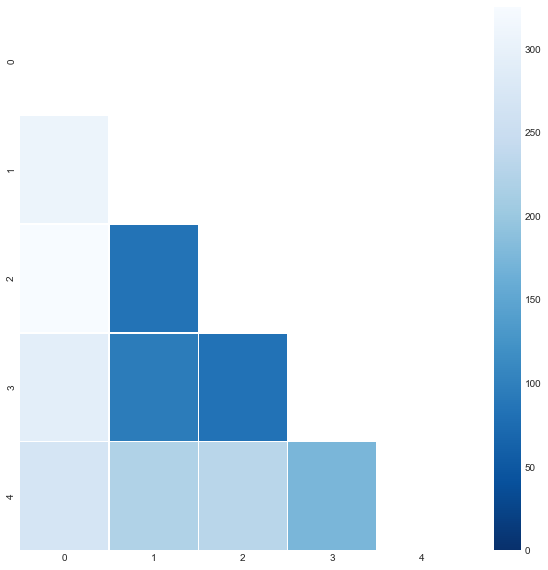


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.3509 secs


------------   60    -------------
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


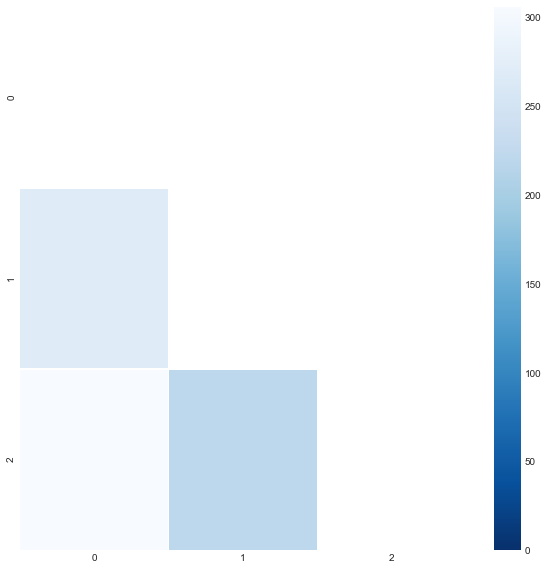


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.3200 secs


------------   61    -------------
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

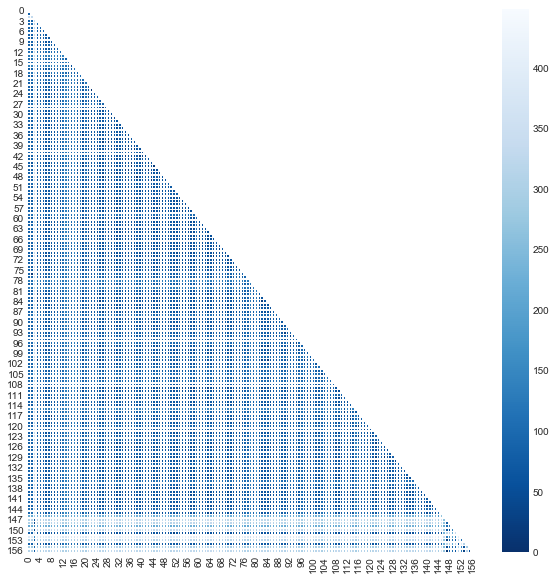


- Mean variance in prototype selection:  108.36626232301514

- Final number of prototypes:  157

# Finished in 1.2605 secs


------------   62    -------------
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

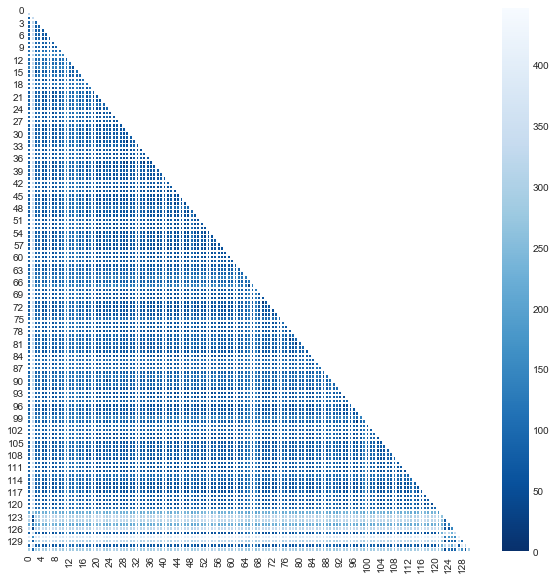


- Mean variance in prototype selection:  110.96292470156106

- Final number of prototypes:  132

# Finished in 0.9815 secs


------------   63    -------------
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

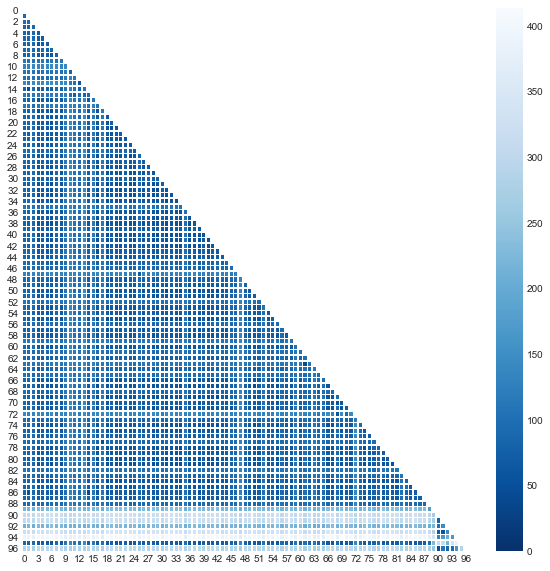


- Mean variance in prototype selection:  114.56562865341694

- Final number of prototypes:  97

# Finished in 0.9240 secs


------------   64    -------------
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

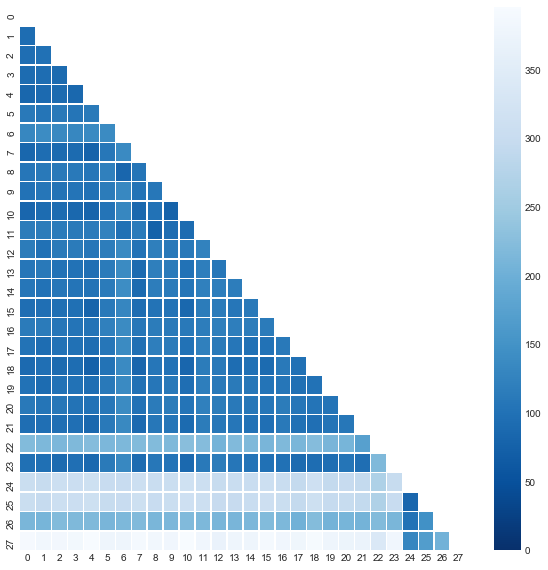


- Mean variance in prototype selection:  156.60714285714286

- Final number of prototypes:  28

# Finished in 0.6667 secs


------------   65    -------------
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

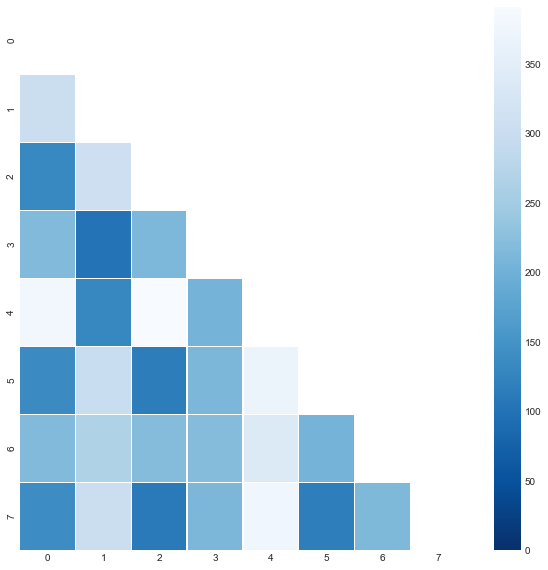


- Mean variance in prototype selection:  201.34375

- Final number of prototypes:  8

# Finished in 0.6662 secs


------------   66    -------------
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 488, 713, 492, 1168, 1015, 755, 1044, 503, 1401, 1021, 510}
Final:
[3, 1027, 518, 1542, 5

1779  ->  p.e. utgoff and j.a. clouse. two kinds of training information for evaluation function learning. nan
253  ->  fahlman  s. & lebiere  c. the cascade-correlation learning architecture. nan
1283  ->  connell  m. e.  & utgoff  p. e. learning to control a dynamic physical system. nan
774  ->  pat langley and dennis kibler. the experimental study of machine learning. nan
778  ->  d. kibler and d. aha. comparing instance-averaging with instance-filtering learn ing algorithms. nan
1292  ->  m. w. craven and j. w. shavlik. learning symbolic rules using artificial neural networks. nan
783  ->  kibler  d. aha  d. w. & albert  m. instance-based prediction of real-valued attributes. computational intelligence 
1296  ->  danyluk  a. & provost  f. small disjuncts in action: learning to diagnose errors in the telephone network local loop  nan
785  ->  langley  p.  kibler  d. & granger  r. components of learning in a reactive environment. in t.m. machine learning: a guide to current research


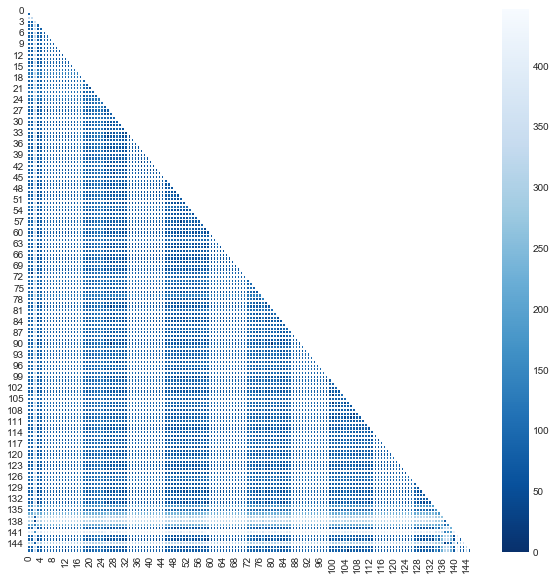


- Mean variance in prototype selection:  103.39256791151836

- Final number of prototypes:  147

# Finished in 1.0116 secs


------------   67    -------------
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 1027, 1401, 1168, 1683, 1044, 1093, 713, 842, 1373, 1120, 503, 488, 492, 883, 755, 1779, 

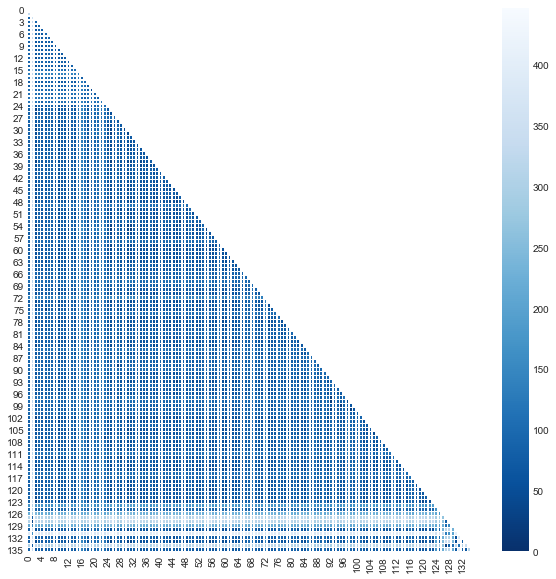


- Mean variance in prototype selection:  105.50637975778547

- Final number of prototypes:  136

# Finished in 1.0991 secs


------------   68    -------------
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 1027, 518, 1542, 1416, 1401, 1034, 1168, 1683, 1044, 1403, 1816, 1694, 418, 1192, 1320, 1

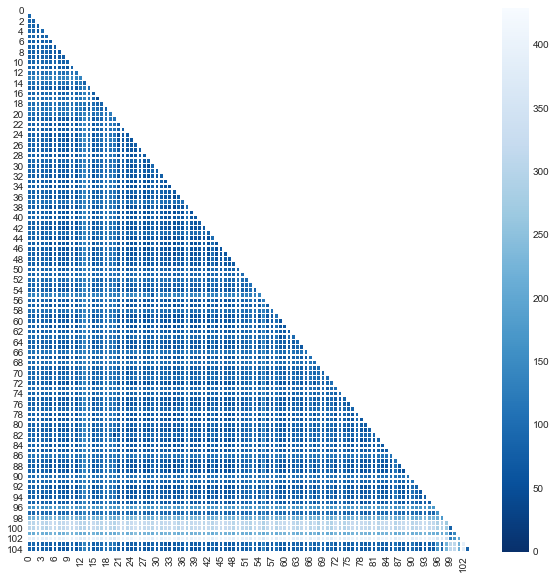


- Mean variance in prototype selection:  105.76580498866213

- Final number of prototypes:  105

# Finished in 1.0675 secs


------------   69    -------------
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{514, 1027, 1542, 518, 1034, 13, 525, 1039, 528, 531, 1044, 21, 1048, 28, 36, 40, 60, 1598, 1093, 162

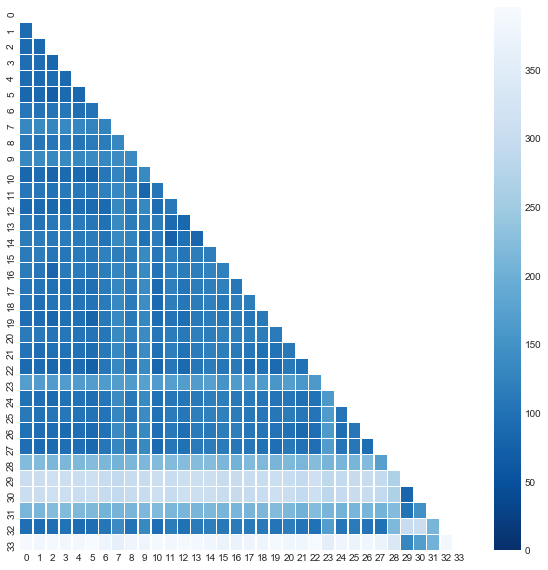


- Mean variance in prototype selection:  153.26643598615917

- Final number of prototypes:  34

# Finished in 0.6549 secs


------------   70    -------------
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{514, 1027, 1542, 518, 520, 9, 1034, 13, 525, 1039, 528, 17, 531, 1044, 21, 1048, 28, 34, 36, 38, 40,

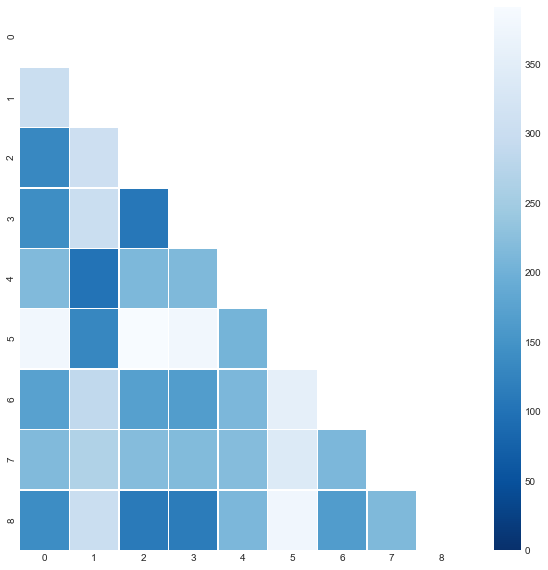


- Mean variance in prototype selection:  202.46913580246914

- Final number of prototypes:  9

# Finished in 0.5105 secs


------------   71    -------------
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

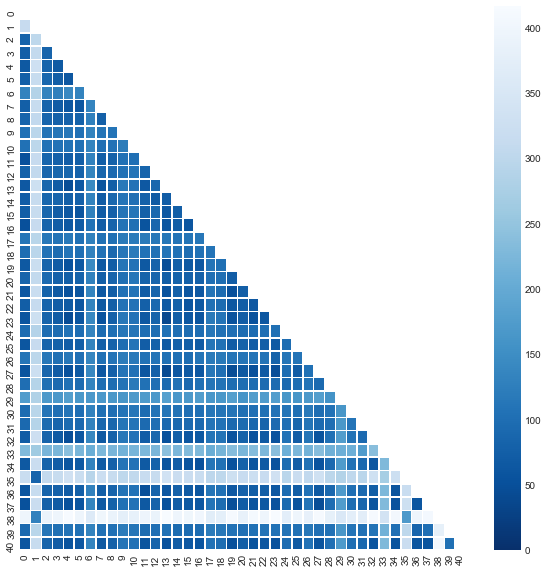


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.7050 secs


------------   72    -------------
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

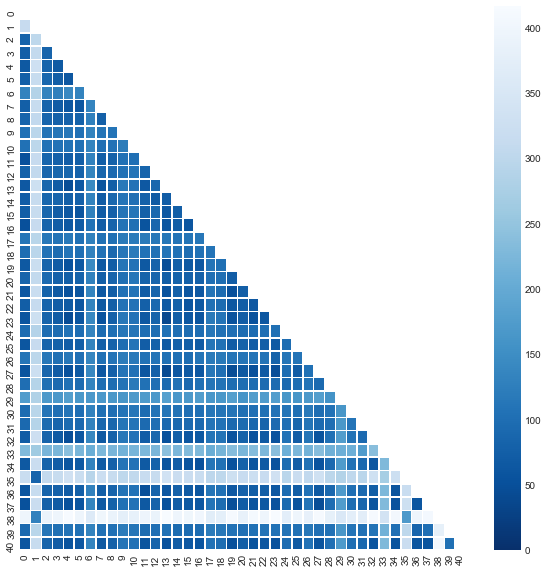


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.7026 secs


------------   73    -------------
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{1861}
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1478  457 1867  718 1870
  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitc

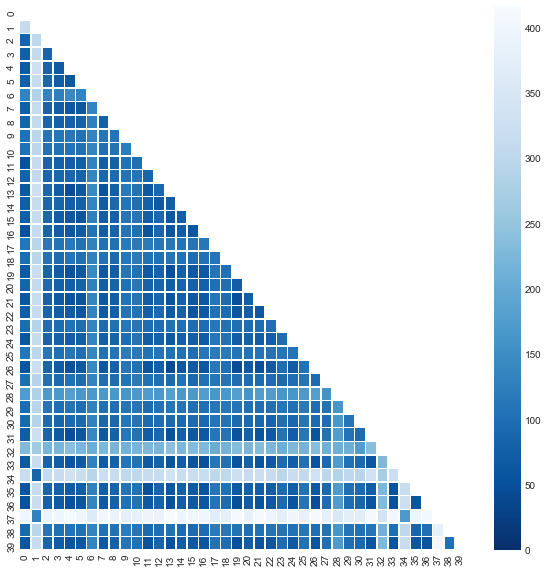


- Mean variance in prototype selection:  131.6675

- Final number of prototypes:  40

# Finished in 0.6290 secs


------------   74    -------------
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 21, 24, 28, 804, 1577, 46, 1327, 1202, 442, 1343, 707, 452, 1861, 457, 718, 1878, 1123, 1261, 751, 243}
Final:
[514, 3, 17, 1306, 1437, 30, 34, 38, 51, 1336, 1478, 1867, 1870, 467, 726, 471, 476, 488, 496, 1392]

- Prototypes selected
[ 514    3   17 1306 1437   30   34   38   51 1336 1478 1867 1870  467
  726  471  476  488  496 1392]
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de welde  w. wenzel  j. wnek  and j. zhang  the monk's problems a performance comparison of different learning algorithms. nan
3  ->  m. ahlskog  j. 

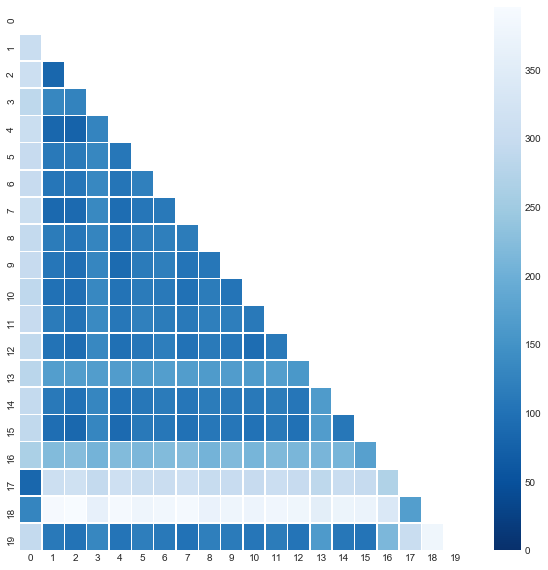


- Mean variance in prototype selection:  171.56

- Final number of prototypes:  20

# Finished in 0.3740 secs


------------   75    -------------
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 514, 17, 21, 24, 28, 1437, 804, 38, 1577, 46, 1327, 1202, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 1878, 471, 726, 1123, 1261, 751, 1392, 243}
Final:
[34, 3, 488, 496, 51, 467, 1306, 476, 30]

- Prototypes selected
[  34    3  488  496   51  467 1306  476   30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
488  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnink  b.  cheng  j.  dejong  k.a.  dzeroski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  mi

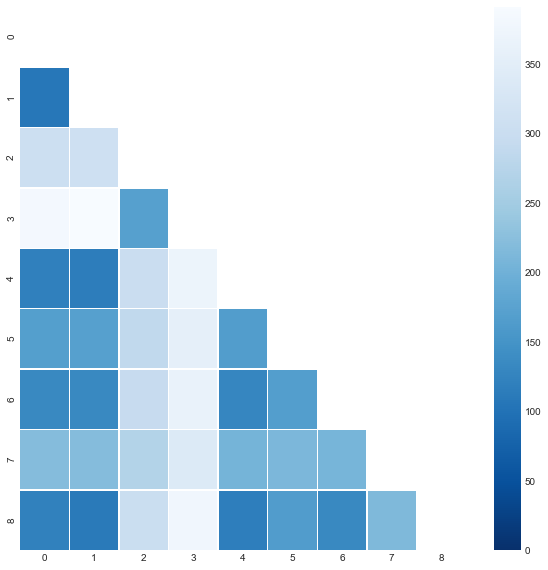


- Mean variance in prototype selection:  201.11111111111111

- Final number of prototypes:  9

# Finished in 0.2867 secs


------------   76    -------------
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

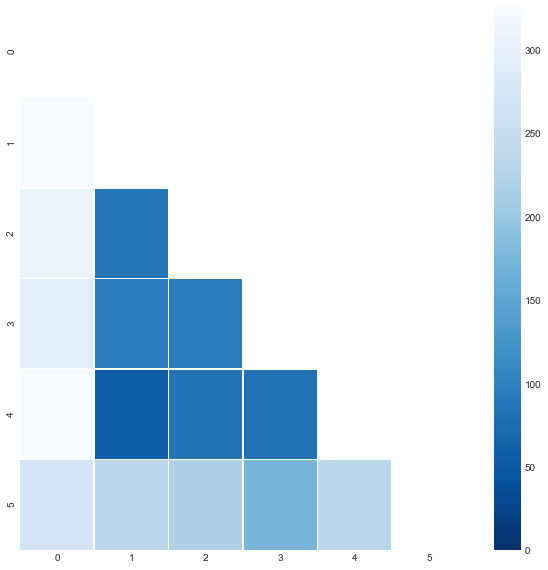


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2510 secs


------------   77    -------------
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

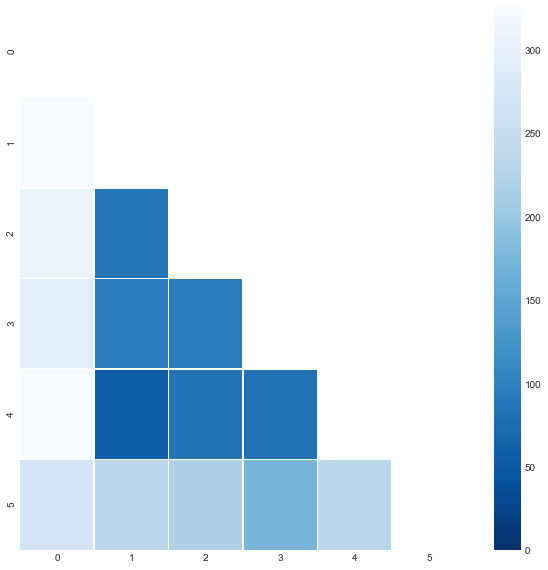


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2469 secs


------------   78    -------------
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

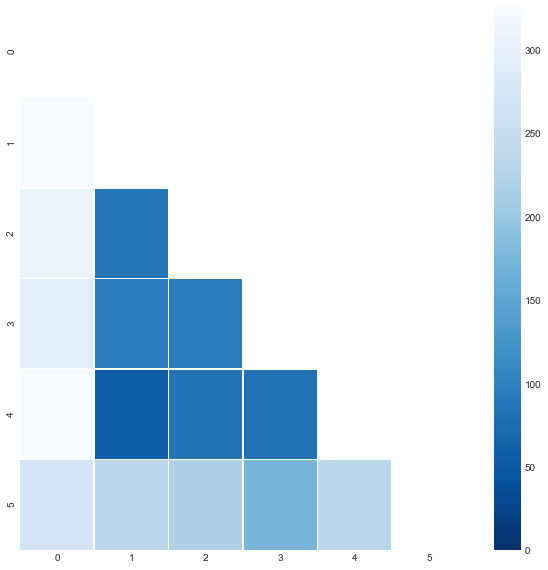


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2500 secs


------------   79    -------------
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

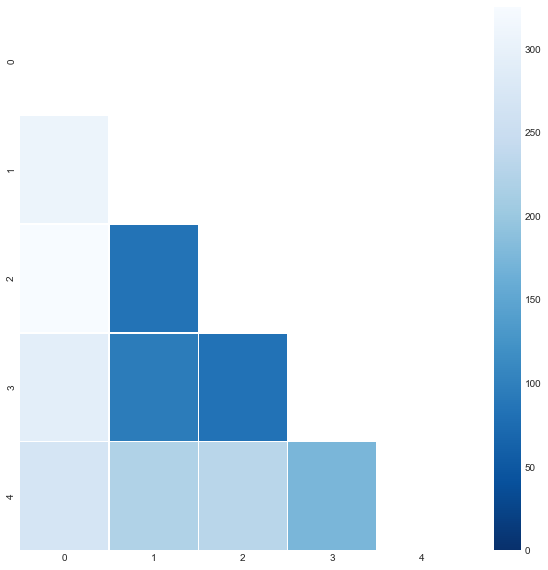


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.2459 secs


------------   80    -------------
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


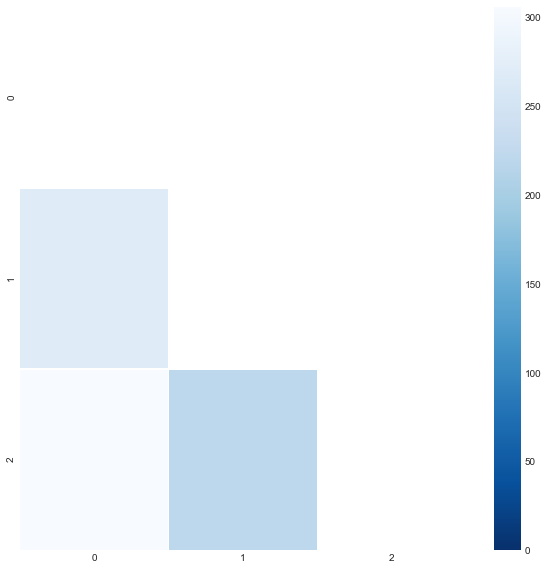


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.2409 secs


------------   81    -------------
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

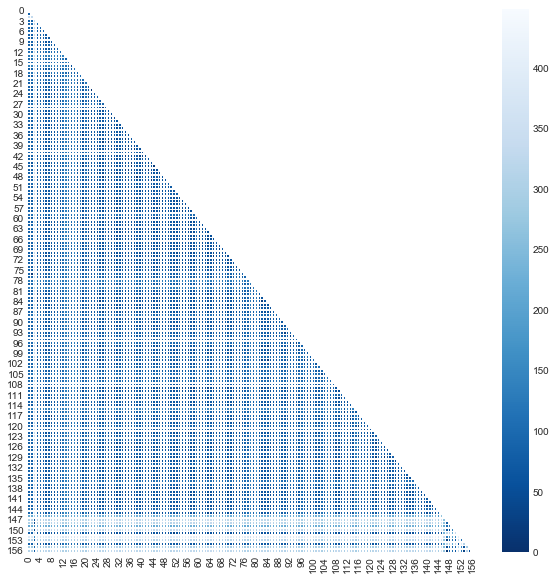


- Mean variance in prototype selection:  108.36626232301514

- Final number of prototypes:  157

# Finished in 1.4182 secs


------------   82    -------------
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

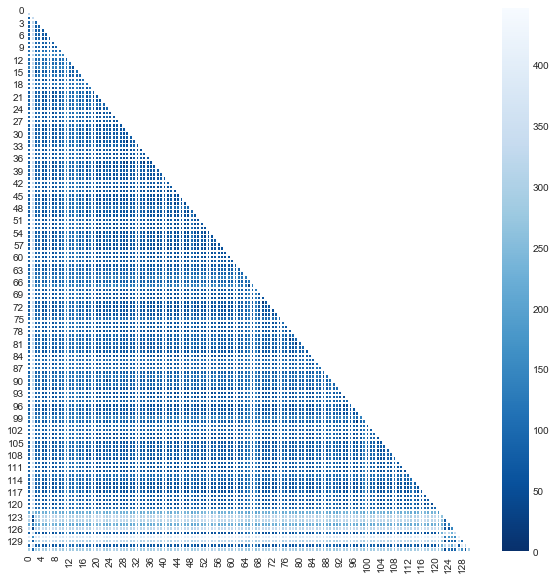


- Mean variance in prototype selection:  110.96292470156106

- Final number of prototypes:  132

# Finished in 1.1666 secs


------------   83    -------------
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

1851  ->  utgoff  p.e. and clouse j.a. a kolmogorov-smirnoff metric for decision tree induction  nan
1340  ->  huffman  s. b.  & laird  j. e. learning procedures from interactive natural language instructions. nan
1853  ->  paul e. utgoff. feature function learning for value approximation. nan
1855  ->  utgoff  p. e.; berkman  n. c.; and clouse  j. a. decision tree induction based on efficient tree restructuring. machine learning
1348  ->  m. jordan and r. jacobs. supervised learning and divide-and-conquer: a statistical approach. nan
1352  ->  l. p. kaelbling. hierarchical learning in stochastic domains: preliminary results. nan
1867  ->  utgoff  p. e. & precup  d. 'constructive function approximation.'  'feature extraction  construction  and selection: a data-mining perspective.' nan
1357  ->  r.a. mccallum. overcoming incomplete perception with utile distinction memory. nan
1870  ->  yee  r. c.  saxena  s.  utgoff  p. e.  & barto  a. g. explaining temporal differences to create usef

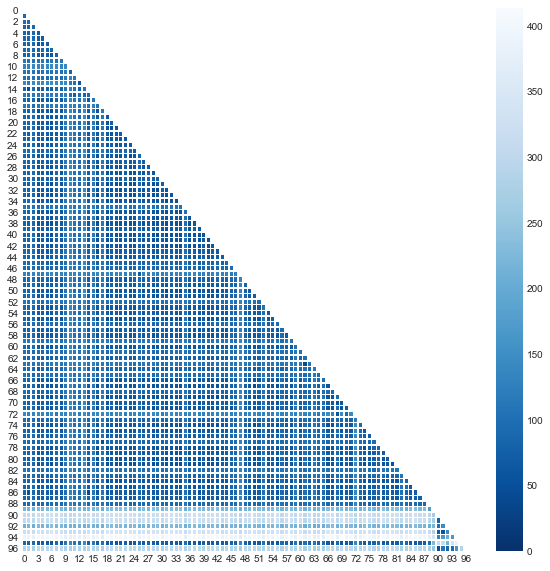


- Mean variance in prototype selection:  114.56562865341694

- Final number of prototypes:  97

# Finished in 1.0149 secs


------------   84    -------------
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

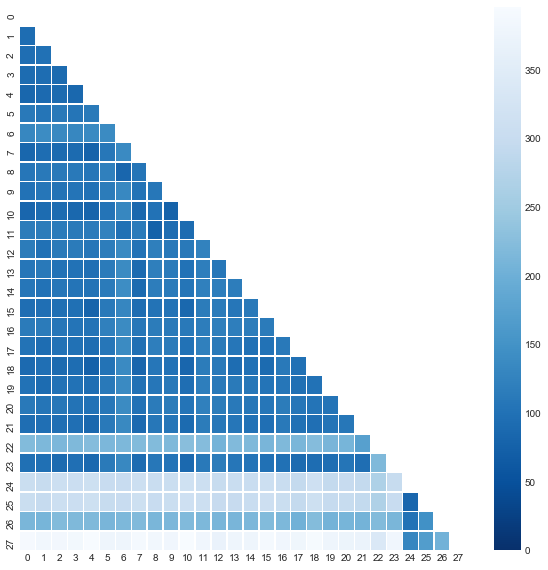


- Mean variance in prototype selection:  156.60714285714286

- Final number of prototypes:  28

# Finished in 0.7045 secs


------------   85    -------------
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

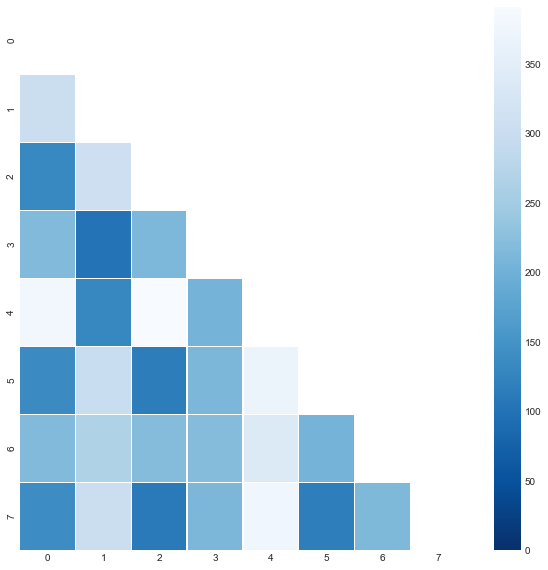


- Mean variance in prototype selection:  201.34375

- Final number of prototypes:  8

# Finished in 0.5480 secs


------------   86    -------------
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 488, 713, 492, 1168, 1015, 755, 1044, 503, 1401, 1021, 510}
Final:
[3, 1027, 518, 1542, 5

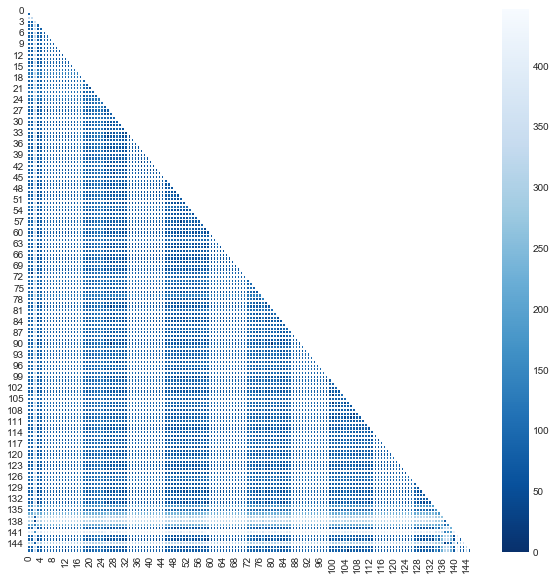


- Mean variance in prototype selection:  103.39256791151836

- Final number of prototypes:  147

# Finished in 0.9659 secs


------------   87    -------------
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 1027, 1401, 1168, 1683, 1044, 1093, 713, 842, 1373, 1120, 503, 488, 492, 883, 755, 1779, 

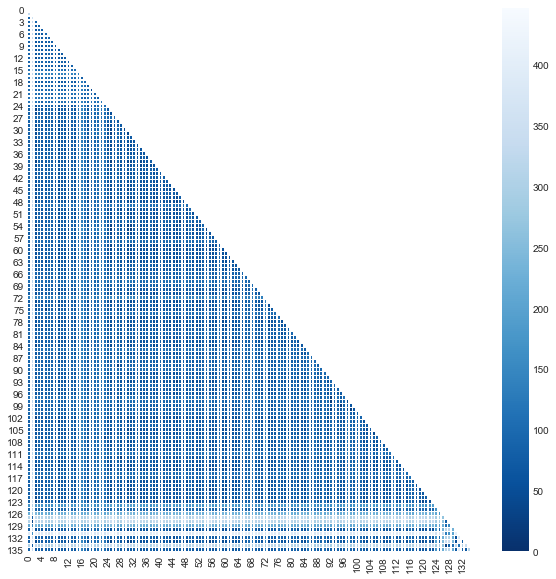


- Mean variance in prototype selection:  105.50637975778547

- Final number of prototypes:  136

# Finished in 0.9322 secs


------------   88    -------------
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 1027, 518, 1542, 1416, 1401, 1034, 1168, 1683, 1044, 1403, 1816, 1694, 418, 1192, 1320, 1

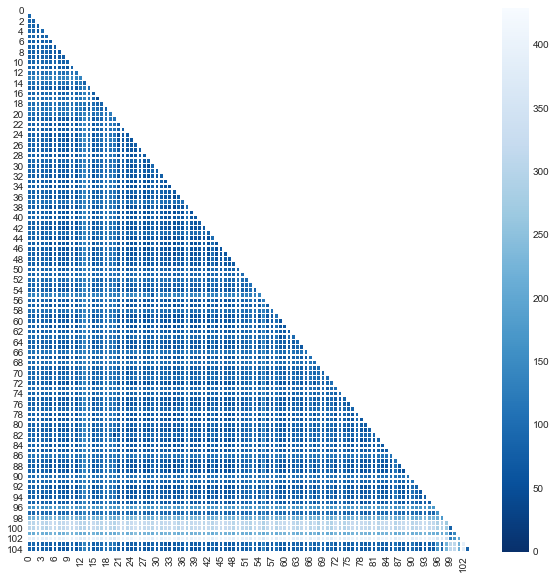


- Mean variance in prototype selection:  105.76580498866213

- Final number of prototypes:  105

# Finished in 0.9823 secs


------------   89    -------------
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{514, 1027, 1542, 518, 1034, 13, 525, 1039, 528, 531, 1044, 21, 1048, 28, 36, 40, 60, 1598, 1093, 162

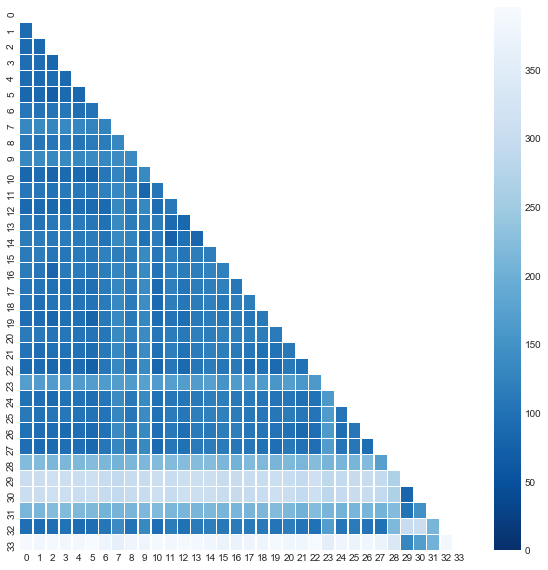


- Mean variance in prototype selection:  153.26643598615917

- Final number of prototypes:  34

# Finished in 0.6671 secs


------------   90    -------------
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{514, 1027, 1542, 518, 520, 9, 1034, 13, 525, 1039, 528, 17, 531, 1044, 21, 1048, 28, 34, 36, 38, 40,

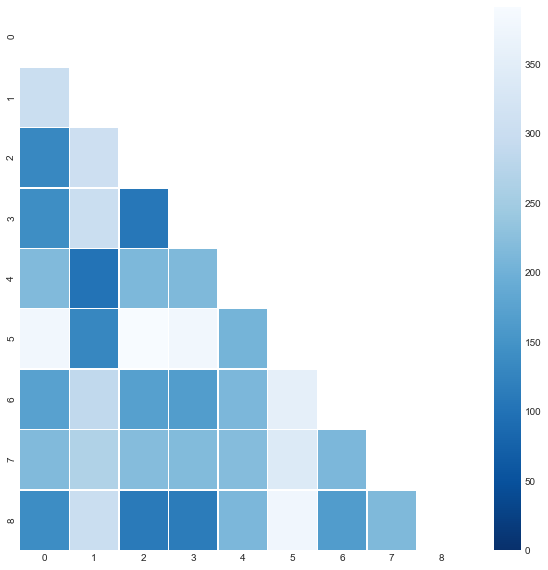


- Mean variance in prototype selection:  202.46913580246914

- Final number of prototypes:  9

# Finished in 0.4434 secs


------------   91    -------------
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

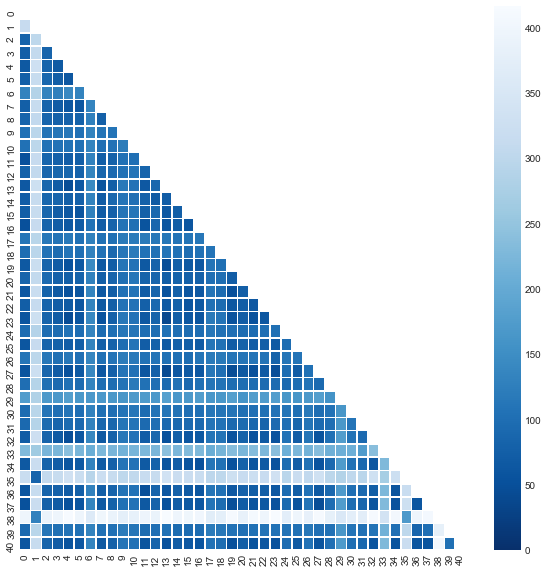


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.6985 secs


------------   92    -------------
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

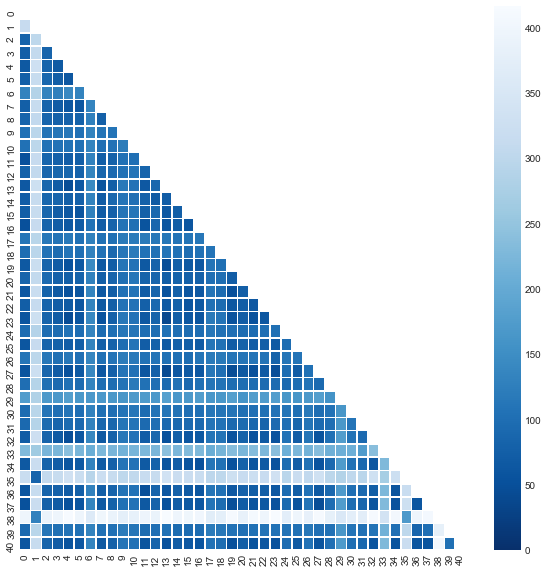


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.7485 secs


------------   93    -------------
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{1861}
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1478  457 1867  718 1870
  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitc

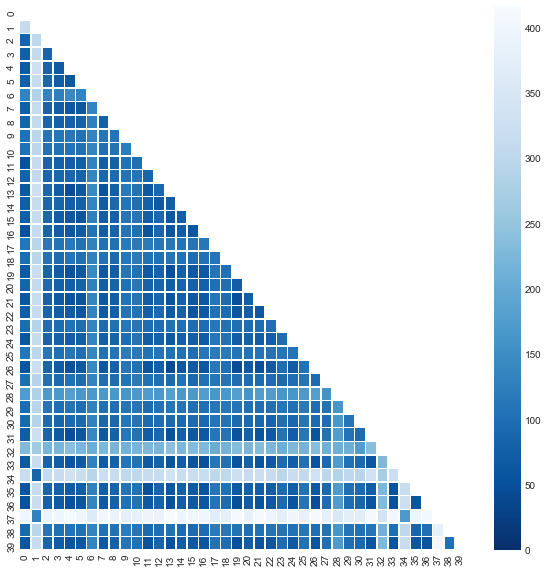


- Mean variance in prototype selection:  131.6675

- Final number of prototypes:  40

# Finished in 0.9303 secs


------------   94    -------------
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 21, 24, 28, 804, 1577, 46, 1327, 1202, 442, 1343, 707, 452, 1861, 457, 718, 1878, 1123, 1261, 751, 243}
Final:
[514, 3, 17, 1306, 1437, 30, 34, 38, 51, 1336, 1478, 1867, 1870, 467, 726, 471, 476, 488, 496, 1392]

- Prototypes selected
[ 514    3   17 1306 1437   30   34   38   51 1336 1478 1867 1870  467
  726  471  476  488  496 1392]
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de welde  w. wenzel  j. wnek  and j. zhang  the monk's problems a performance comparison of different learning algorithms. nan
3  ->  m. ahlskog  j. 

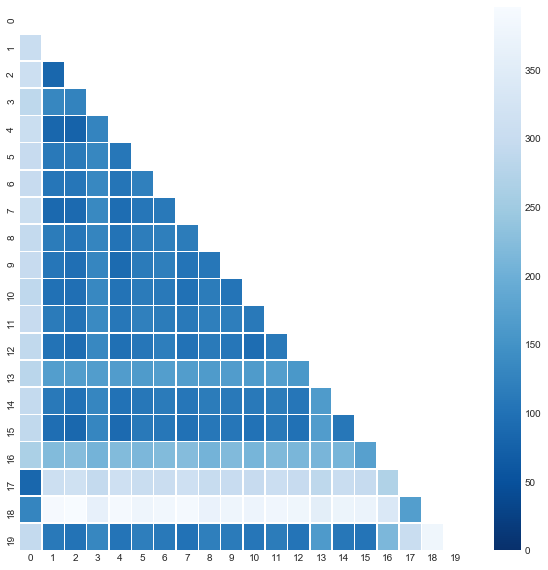


- Mean variance in prototype selection:  171.56

- Final number of prototypes:  20

# Finished in 0.3559 secs


------------   95    -------------
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 514, 17, 21, 24, 28, 1437, 804, 38, 1577, 46, 1327, 1202, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 1878, 471, 726, 1123, 1261, 751, 1392, 243}
Final:
[34, 3, 488, 496, 51, 467, 1306, 476, 30]

- Prototypes selected
[  34    3  488  496   51  467 1306  476   30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
488  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnink  b.  cheng  j.  dejong  k.a.  dzeroski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  mi

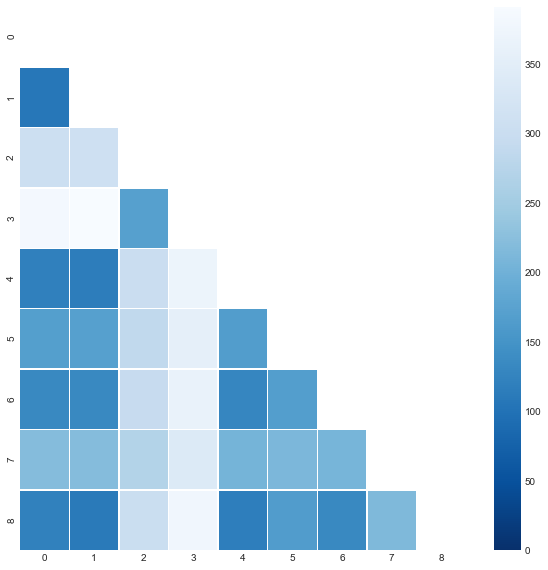


- Mean variance in prototype selection:  201.11111111111111

- Final number of prototypes:  9

# Finished in 0.2759 secs


------------   96    -------------
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  10
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

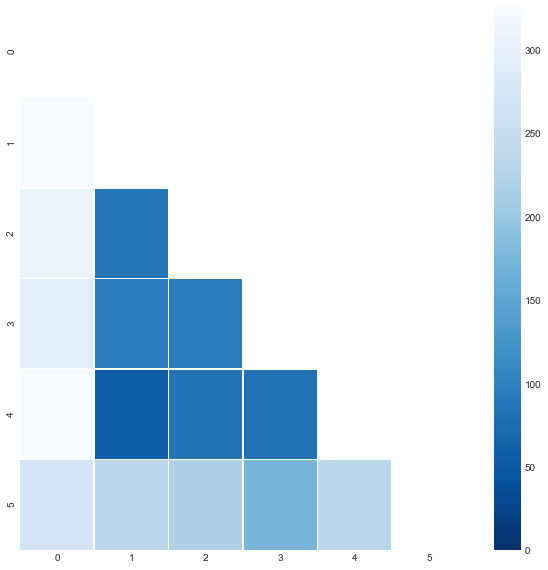


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2460 secs


------------   97    -------------
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  20
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

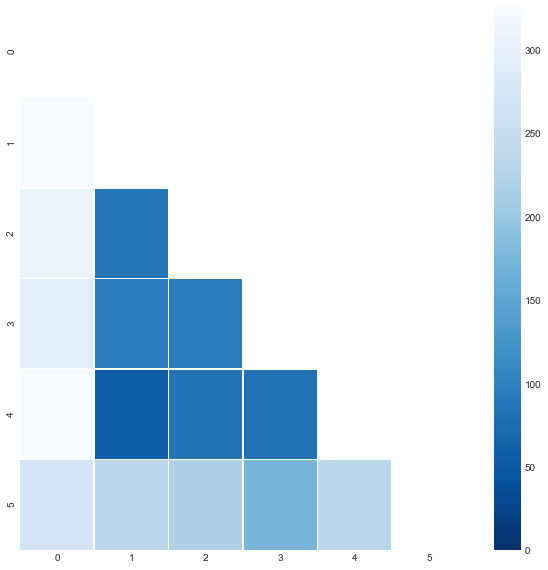


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2850 secs


------------   98    -------------
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  40
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

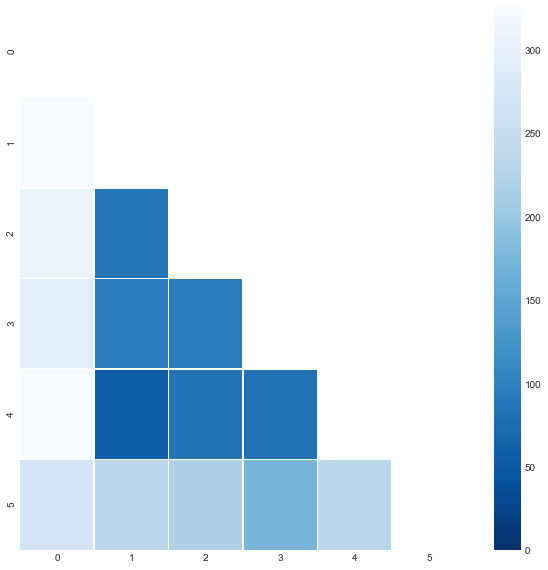


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2689 secs


------------   99    -------------
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  70
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

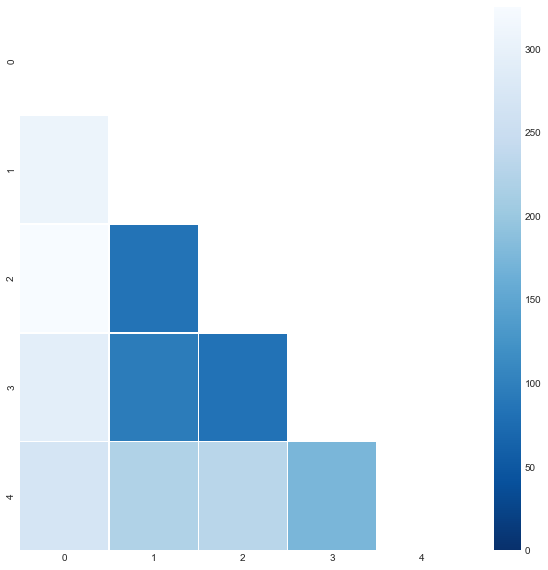


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.2520 secs


------------   100    -------------
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  3
ngramms:  False
prototypeFilter:  100
+ ------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


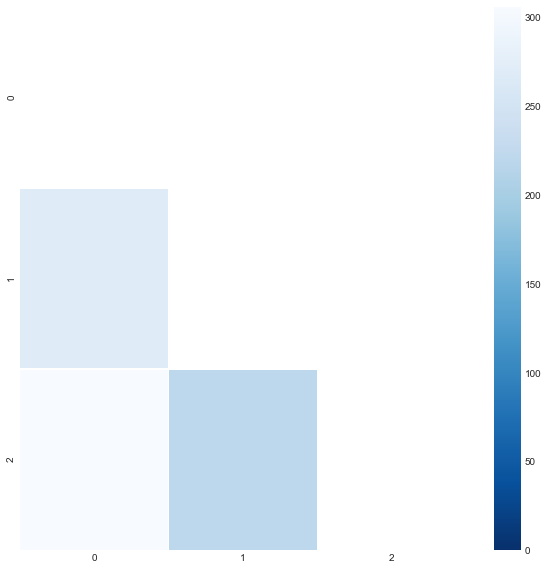


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.2330 secs





In [82]:
max_numberOf_clusters= [10,50,100,500,1000]
max_editDistance= [50,100,200,300]
prototypesFilterThr = [10,20,40,70,100]

distanceMetric= ['edit']


ngramms= [3]  
jaccard_withchars = [False] 

# ---------------- #

distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']



results_section1_edit = GridSearch_cora(
    data,true_matrix,max_numberOf_clusters,max_editDistance,
    similarityThreshold,
    windowSize,metric,similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,number_of_permutations,
    ngramms,jaccard_withchars,prototypesFilterThr
)

In [67]:
results_section1_edit[["numOfPrototypes","max_numberOf_clusters","max_editDistance","similarityThreshold","protSelectionVariance","prototypesFilterThr"]].sort_values(by=['numOfPrototypes'], ascending=False).head(20)

numOfPrototypes max_numberOf_clusters max_editDistance  \
61             157                   500               50   
81             157                  1000               50   
86             147                  1000              100   
66             147                   500              100   
67             136                   500              100   
87             136                  1000              100   
62             132                   500               50   
82             132                  1000               50   
88             105                  1000              100   
68             105                   500              100   
63              97                   500               50   
83              97                  1000               50   
46              78                   100              100   
47              74                   100              100   
48              64                   100              100   
41              47                   100               50   
42              42                   100               50   
32              41                    50              200   
91              41                  1000              200   
71              41                   500              200   

    similarityThreshold protSelectionVariance prototypesFilterThr  
61                  0.7               108.366                  10  
81                  0.7               108.366                  10  
86                  0.7               103.393                  10  
66                  0.7               103.393                  10  
67                  0.7               105.506                  20  
87                  0.7               105.506                  20  
62                  0.7               110.963                  20  
82                  0.7               110.963                  20  
88                  0.7               105.766                  40  
68                  0.7               105.766                  40  
63                  0.7               114.566                  40  
83                  0.7               114.566                  40  
46                  0.7                121.17                  10  
47                  0.7               123.533                  20  
48                  0.7               118.316                  40  
41                  0.7                161.23                  10  
42                  0.7               162.773                  20  
32                  0.7               130.256                  20  
91                  0.7               130.256                  10  
71                  0.7               130.256                  10

In [70]:
results_section1_edit[["numOfPrototypes","max_numberOf_clusters","max_editDistance","similarityThreshold","protSelectionVariance","prototypesFilterThr"]].sort_values(by=['protSelectionVariance'], ascending=False).head(50)

numOfPrototypes max_numberOf_clusters max_editDistance  \
50                9                   100              100   
70                9                   500              100   
90                9                  1000              100   
65                8                   500               50   
45                8                   100               50   
85                8                  1000               50   
55                9                   100              200   
95                9                  1000              200   
35                9                    50              200   
75                9                   500              200   
44               18                   100               50   
100               3                  1000              300   
20                3                    10              300   
40                3                    50              300   
80                3                   500              300   
60                3                   100              300   
30                7                    50              100   
94               20                  1000              200   
54               20                   100              200   
34               20                    50              200   
74               20                   500              200   
49               23                   100              100   
19                5                    10              300   
59                5                   100              300   
39                5                    50              300   
99                5                  1000              300   
79                5                   500              300   
42               42                   100               50   
41               47                   100               50   
38                6                    50              300   
56                6                   100              300   
96                6                  1000              300   
18                6                    10              300   
97                6                  1000              300   
57                6                   100              300   
36                6                    50              300   
37                6                    50              300   
58                6                   100              300   
76                6                   500              300   
77                6                   500              300   
78                6                   500              300   
16                6                    10              300   
17                6                    10              300   
98                6                  1000              300   
64               28                   500               50   
84               28                  1000               50   
43               37                   100               50   
29               18                    50              100   
89               34                  1000              100   
69               34                   500              100   

     similarityThreshold protSelectionVariance prototypesFilterThr  
50                   0.7               202.469                 100  
70                   0.7               202.469                 100  
90                   0.7               202.469                 100  
65                   0.7               201.344                 100  
45                   0.7               201.344                 100  
85                   0.7               201.344                 100  
55                   0.7               201.111                 100  
95                   0.7               201.111                 100  
35                   0.7               201.111                 100  
75                   0.7               201.111                 100  
44                   0.7               177.772                  70  
100          

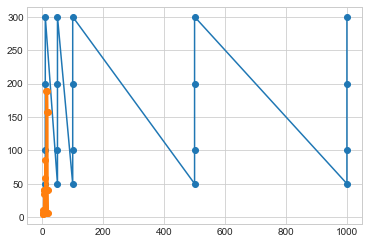

In [26]:
plt.plot(results_section1_edit[['max_numberOf_clusters']],results_section1_edit[['max_editDistance']],results_section1_edit[['numOfPrototypes']], marker='o')
# plt.ylabel('some numbers')
plt.show()

In [27]:
X = np.array(results_section1_edit[['max_numberOf_clusters']]).reshape(-1)
Y = np.array(results_section1_edit[['max_editDistance']]).reshape(-1)
Z = np.array(results_section1_edit[['numOfPrototypes']]).reshape(-1)
X.reshape(-1)

array([10, 10, 10, 10, 50, 50, 50, 50, 100, 100, 100, 100, 500, 500, 500,
       500, 1000, 1000, 1000, 1000], dtype=object)

In [28]:
X = np.array(results_section1_edit[['max_numberOf_clusters']])
Y = np.array(results_section1_edit[['max_editDistance']])
Z = np.array(results_section1_edit[['numOfPrototypes']])

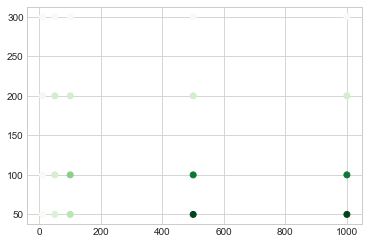

In [29]:
xx = np.ravel(X); yy = np.ravel(Y) ; zz = np.ravel(Z)
plt.scatter(xx,yy,c=zz,cmap='Greens')
plt.show()

In [ ]:
highlight_columns(results_section1_edit, rows=20, color='lightyellow', columns_to_shadow=['numOfPrototypes'], columns_to_show=[])

In [ ]:
data = pd.DataFrame(data={'x':X, 'y':Y, 'z':Z})
data = data.pivot(index='x', columns='y', values='z')
sns.heatmap(data)
plt.show()

+ ------------   1    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.1
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.3
Prototypes before:
[3, 13, 17, 21]
Not wanted:
set()
Final:
[17, 21, 3, 13]

- Prototypes selected
[17 21  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


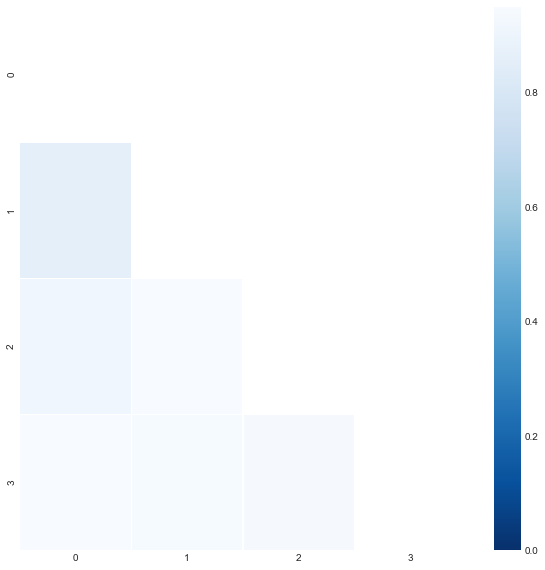


- Mean variance in prototype selection:  0.6927440808157912

- Final number of prototypes:  4

# Finished in 0.2030 secs


+ ------------   2    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.3
Prototypes before:
[3, 13, 17, 21]
Not wanted:
set()
Final:
[17, 21, 3, 13]

- Prototypes selected
[17 21  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


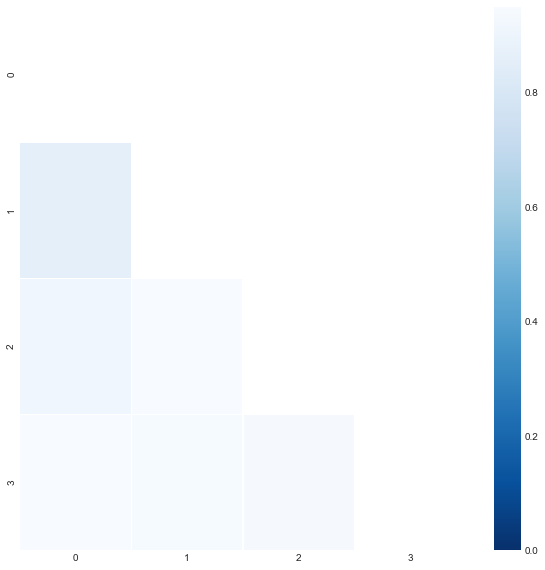


- Mean variance in prototype selection:  0.6927440808157912

- Final number of prototypes:  4

# Finished in 0.2135 secs


+ ------------   3    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.3
Prototypes before:
[3, 13, 17, 21]
Not wanted:
set()
Final:
[17, 21, 3, 13]

- Prototypes selected
[17 21  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


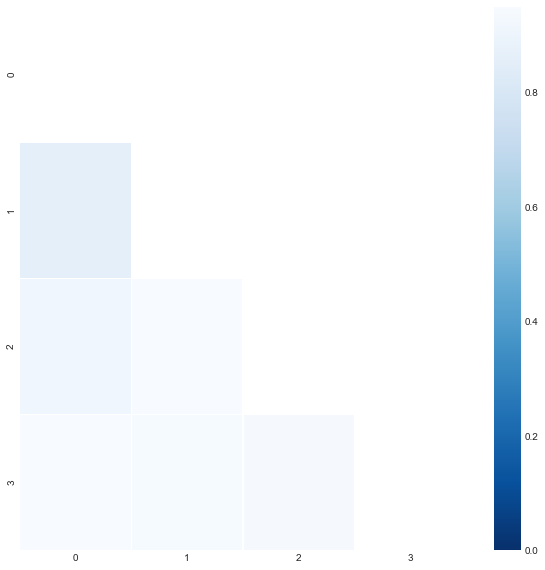


- Mean variance in prototype selection:  0.6927440808157912

- Final number of prototypes:  4

# Finished in 0.2020 secs


+ ------------   4    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.1
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.35
Prototypes before:
[3, 11, 13, 17, 21]
Not wanted:
set()
Final:
[17, 3, 21, 11, 13]

- Prototypes selected
[17  3 21 11 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
21  ->  b. buth et. al.  provably correct compiler implementation  nan
11  ->  benford  s.  bowers  j.  fahln  l.  greenhalgh  c.  and snowdon  d.  user embodiment in collaborative virtual environments  nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


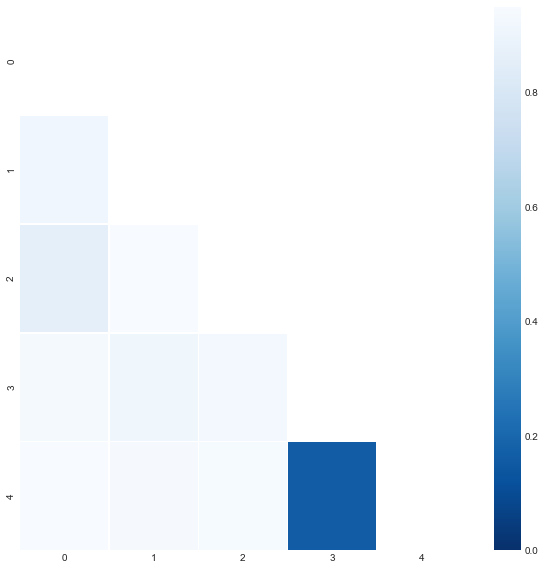


- Mean variance in prototype selection:  0.6776508740509287

- Final number of prototypes:  5

# Finished in 0.1899 secs


+ ------------   5    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.35
Prototypes before:
[3, 11, 13, 17, 21]
Not wanted:
{13}
Final:
[11, 17, 3, 21]

- Prototypes selected
[11 17  3 21]
11  ->  benford  s.  bowers  j.  fahln  l.  greenhalgh  c.  and snowdon  d.  user embodiment in collaborative virtual environments  nan
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
21  ->  b. buth et. al.  provably correct compiler implementation  nan


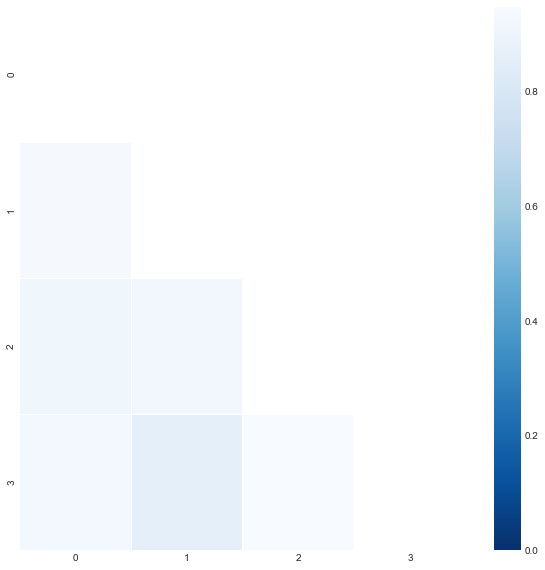


- Mean variance in prototype selection:  0.6859683800259925

- Final number of prototypes:  4

# Finished in 0.1645 secs


+ ------------   6    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.35
Prototypes before:
[3, 11, 13, 17, 21]
Not wanted:
{13}
Final:
[11, 17, 3, 21]

- Prototypes selected
[11 17  3 21]
11  ->  benford  s.  bowers  j.  fahln  l.  greenhalgh  c.  and snowdon  d.  user embodiment in collaborative virtual environments  nan
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
21  ->  b. buth et. al.  provably correct compiler implementation  nan


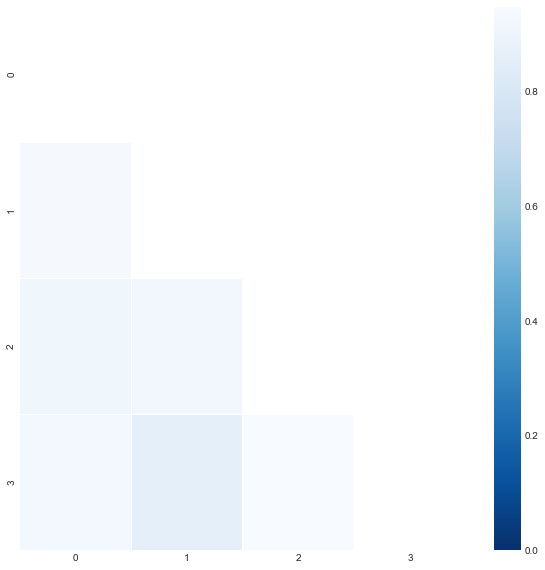


- Mean variance in prototype selection:  0.6859683800259925

- Final number of prototypes:  4

# Finished in 0.1767 secs


+ ------------   7    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.1
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.4
Prototypes before:
[3, 10, 13, 17, 21]
Not wanted:
set()
Final:
[17, 3, 21, 10, 13]

- Prototypes selected
[17  3 21 10 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
21  ->  b. buth et. al.  provably correct compiler implementation  nan
10  ->  benford  s.  and fahln  l. viewpoints  actionpoints and spatial frames for collaborative user interfaces  nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


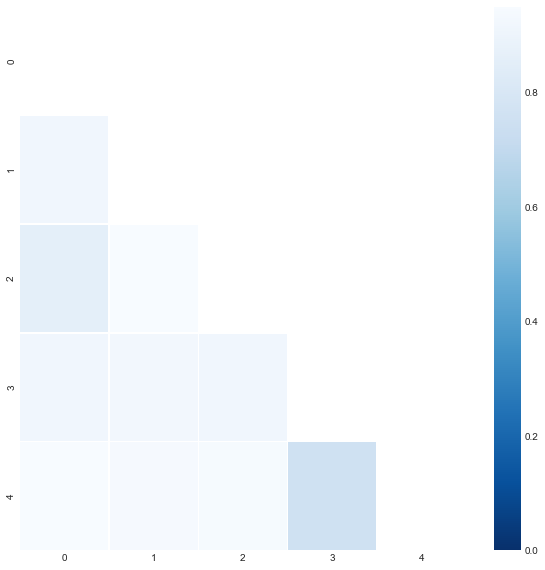


- Mean variance in prototype selection:  0.7234303540292752

- Final number of prototypes:  5

# Finished in 0.1795 secs


+ ------------   8    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.4
Prototypes before:
[3, 10, 13, 17, 21]
Not wanted:
set()
Final:
[17, 3, 21, 10, 13]

- Prototypes selected
[17  3 21 10 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
21  ->  b. buth et. al.  provably correct compiler implementation  nan
10  ->  benford  s.  and fahln  l. viewpoints  actionpoints and spatial frames for collaborative user interfaces  nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


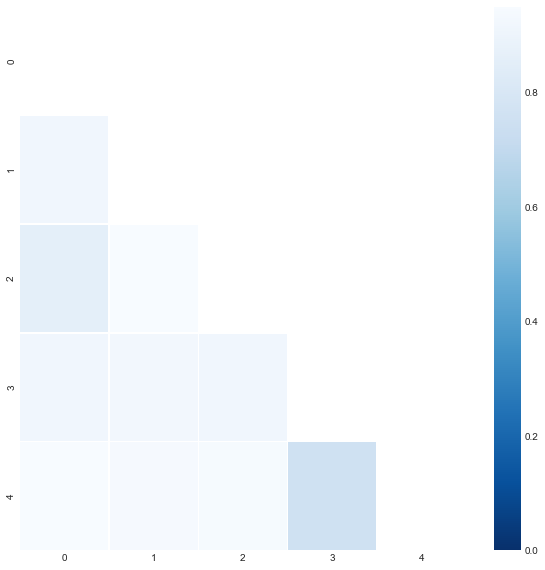


- Mean variance in prototype selection:  0.7234303540292752

- Final number of prototypes:  5

# Finished in 0.1735 secs


+ ------------   9    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.4
Prototypes before:
[3, 10, 13, 17, 21]
Not wanted:
set()
Final:
[17, 3, 21, 10, 13]

- Prototypes selected
[17  3 21 10 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
21  ->  b. buth et. al.  provably correct compiler implementation  nan
10  ->  benford  s.  and fahln  l. viewpoints  actionpoints and spatial frames for collaborative user interfaces  nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


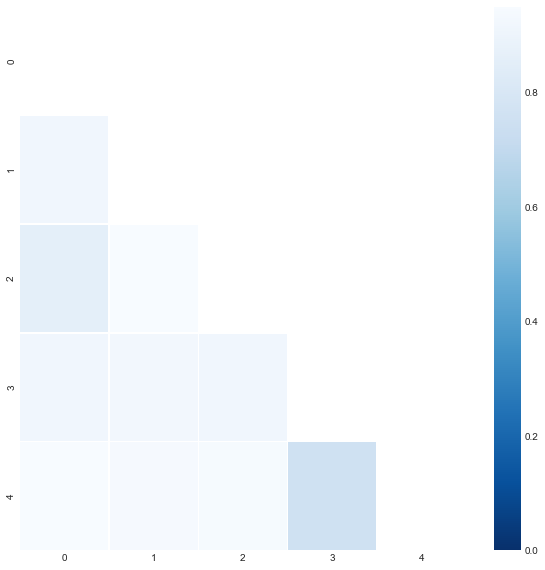


- Mean variance in prototype selection:  0.7234303540292752

- Final number of prototypes:  5

# Finished in 0.1789 secs


+ ------------   10    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.1
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.3
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 73, 88, 95, 105, 107, 109, 116, 124, 126, 130, 141, 143, 145, 154, 160, 173, 186, 190]
Not wanted:
{124, 109}
Final:
[130, 3, 13, 141, 143, 17, 145, 21, 154, 28, 30, 32, 160, 34, 40, 44, 173, 47, 51, 186, 59, 190, 65, 73, 88, 95, 105, 107, 116, 126]

- Prototypes selected
[130   3  13 141 143  17 145  21 154  28  30  32 160  34  40  44 173  47
  51 186  59 190  65  73  88  95 105 107 116 126]
130  ->  s. fahlmann  faster-learning variations on backpropagation: an empirical study  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
141  ->  s. e. fahlman (1988): faster-learning variations on back-propagation: an empirical study  nan
143  ->  fahlman  s.e. fast learning variations on backpropagation: an empir

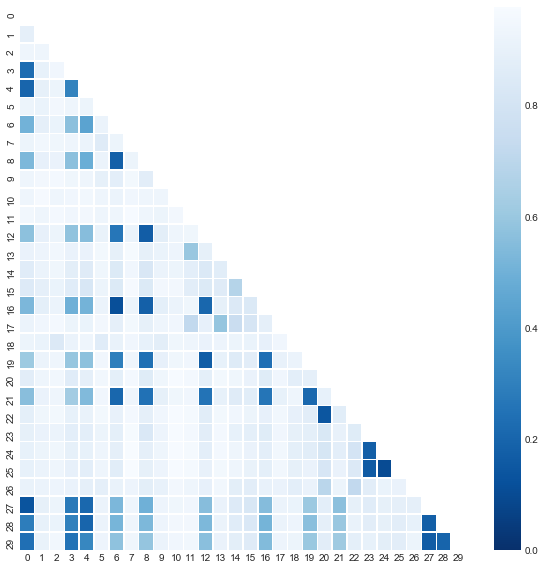


- Mean variance in prototype selection:  0.795090889191272

- Final number of prototypes:  30

# Finished in 0.6875 secs


+ ------------   11    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.3
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 73, 88, 95, 105, 107, 109, 116, 124, 126, 130, 141, 143, 145, 154, 160, 173, 186, 190]
Not wanted:
{160, 65, 130, 186, 109, 141, 173, 116, 88, 154, 124, 126, 95}
Final:
[3, 13, 143, 17, 145, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 190, 73, 105, 107]

- Prototypes selected
[  3  13 143  17 145  21  28  30  32  34  40  44  47  51  59 190  73 105
 107]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
143  ->  fahlman  s.e. fast learning variations on backpropagation: an empirical study  nan
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
145  ->  s.e. fahlman  an empirical study of learning speed in backpropagation networks  nan
21  ->  b. buth et. al

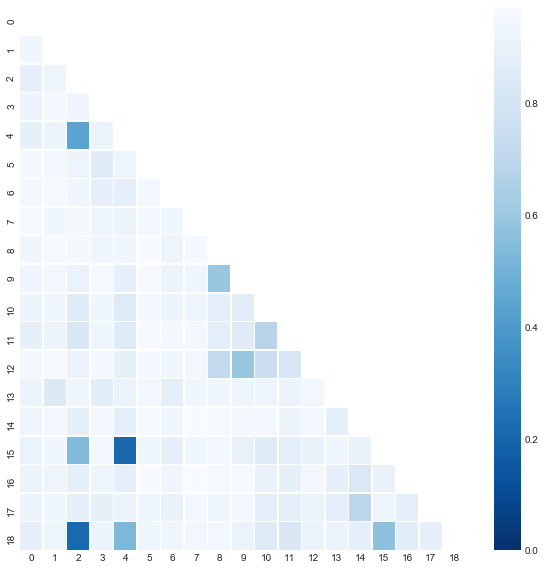


- Mean variance in prototype selection:  0.8432420315914934

- Final number of prototypes:  19

# Finished in 0.3110 secs


+ ------------   12    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.3
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 73, 88, 95, 105, 107, 109, 116, 124, 126, 130, 141, 143, 145, 154, 160, 173, 186, 190]
Not wanted:
{160, 65, 130, 186, 109, 141, 143, 173, 190, 116, 88, 154, 124, 126, 95}
Final:
[32, 34, 3, 40, 73, 105, 107, 44, 13, 47, 17, 145, 51, 21, 59, 28, 30]

- Prototypes selected
[ 32  34   3  40  73 105 107  44  13  47  17 145  51  21  59  28  30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
40  ->  fahle  m. & edelman  s. long-term learning in vernier acuity: effects of stimulus orientation  range and of feedbac

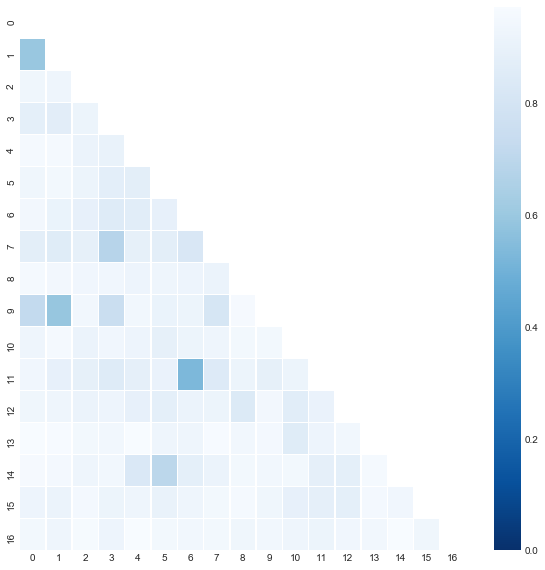


- Mean variance in prototype selection:  0.8511522066653794

- Final number of prototypes:  17

# Finished in 0.2711 secs


+ ------------   13    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.1
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.35
Prototypes before:
[3, 11, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 107, 110, 126, 145, 154, 160, 173, 186, 190, 194, 244, 246, 255, 278, 288, 313, 326]
Not wanted:
{288}
Final:
[3, 11, 13, 17, 145, 21, 278, 154, 28, 30, 32, 160, 34, 40, 44, 173, 47, 51, 313, 186, 59, 190, 65, 194, 326, 94, 105, 107, 110, 244, 246, 126, 255]

- Prototypes selected
[  3  11  13  17 145  21 278 154  28  30  32 160  34  40  44 173  47  51
 313 186  59 190  65 194 326  94 105 107 110 244 246 126 255]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
11  ->  benford  s.  bowers  j.  fahln  l.  greenhalgh  c.  and snowdon  d.  user embodiment in collaborative virtual environments  nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generat

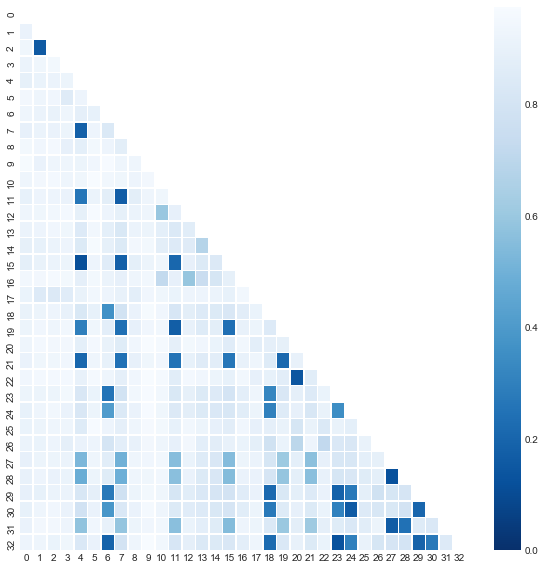


- Mean variance in prototype selection:  0.8064349908015234

- Final number of prototypes:  33

# Finished in 0.4586 secs


+ ------------   14    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.35
Prototypes before:
[3, 11, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 107, 110, 126, 145, 154, 160, 173, 186, 190, 194, 244, 246, 255, 278, 288, 313, 326]
Not wanted:
{160, 65, 288, 326, 186, 13, 110, 173, 244, 278, 313, 154, 126, 255}
Final:
[3, 11, 17, 145, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 190, 194, 94, 105, 107, 246]

- Prototypes selected
[  3  11  17 145  21  28  30  32  34  40  44  47  51  59 190 194  94 105
 107 246]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
11  ->  benford  s.  bowers  j.  fahln  l.  greenhalgh  c.  and snowdon  d.  user embodiment in collaborative virtual environments  nan
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
145  ->  s.e. fahlman  an empirical study of learning speed in backpropagation networks  nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
28  ->  nan an

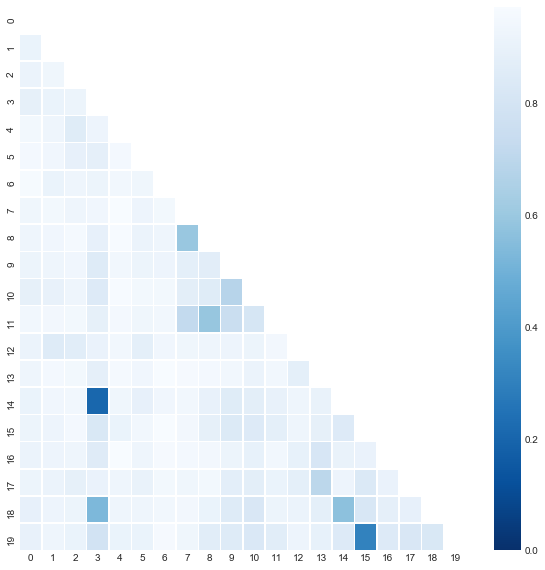


- Mean variance in prototype selection:  0.8472768116000264

- Final number of prototypes:  20

# Finished in 0.3140 secs


+ ------------   15    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.35
Prototypes before:
[3, 11, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 107, 110, 126, 145, 154, 160, 173, 186, 190, 194, 244, 246, 255, 278, 288, 313, 326]
Not wanted:
{160, 65, 288, 326, 186, 13, 110, 173, 244, 278, 246, 313, 154, 190, 126, 255}
Final:
[32, 34, 3, 194, 40, 105, 11, 44, 107, 47, 17, 145, 51, 21, 94, 59, 28, 30]

- Prototypes selected
[ 32  34   3 194  40 105  11  44 107  47  17 145  51  21  94  59  28  30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
194  ->  fahlman  s. e. & lebiere  c. the cascade-correlation learning architec ture  nan
40  ->

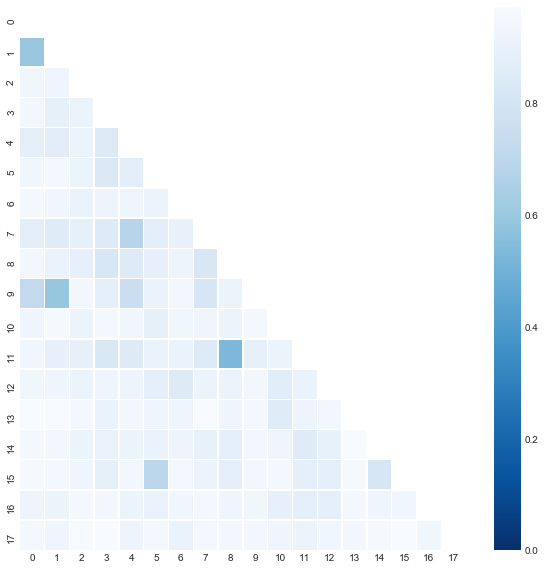


- Mean variance in prototype selection:  0.852244215332939

- Final number of prototypes:  18

# Finished in 0.3139 secs


+ ------------   16    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.1
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.4
Prototypes before:
[3, 10, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 137, 181, 190, 254, 271, 299, 334, 338, 351, 354, 376, 398, 402, 405, 415, 419, 424]
Not wanted:
{376, 338, 299, 351}
Final:
[3, 137, 10, 13, 398, 271, 17, 402, 21, 405, 28, 30, 415, 32, 34, 419, 40, 424, 44, 47, 51, 181, 59, 190, 65, 334, 94, 354, 105, 254]

- Prototypes selected
[  3 137  10  13 398 271  17 402  21 405  28  30 415  32  34 419  40 424
  44  47  51 181  59 190  65 334  94 354 105 254]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
137  ->  s. fahlman. faster-learning variations on back-propagation: an empirical study. nan
10  ->  benford  s.  and fahln  l. viewpoints  actionpoints and spatial frames for collaborative user interfaces  nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
398  ->  fahlman  s. e. the recurrent c

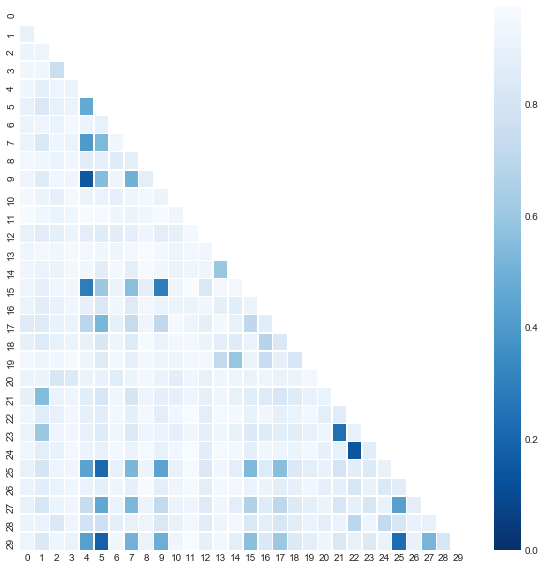


- Mean variance in prototype selection:  0.8338289134940157

- Final number of prototypes:  30

# Finished in 0.4656 secs


+ ------------   17    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.4
Prototypes before:
[3, 10, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 137, 181, 190, 254, 271, 299, 334, 338, 351, 354, 376, 398, 402, 405, 415, 419, 424]
Not wanted:
{65, 299, 271, 338, 405, 376, 351}
Final:
[3, 137, 10, 13, 398, 17, 402, 21, 28, 30, 415, 32, 34, 419, 40, 424, 44, 47, 51, 181, 59, 190, 334, 94, 354, 105, 254]

- Prototypes selected
[  3 137  10  13 398  17 402  21  28  30 415  32  34 419  40 424  44  47
  51 181  59 190 334  94 354 105 254]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
137  ->  s. fahlman. faster-learning variations on back-propagation: an empirical study. nan
10  ->  benford  s.  and fahln  l. viewpoints  actionpoints and spatial frames for collaborative user interfaces  nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
398  ->  fahlman  s. e. the recurrent cascade-corre

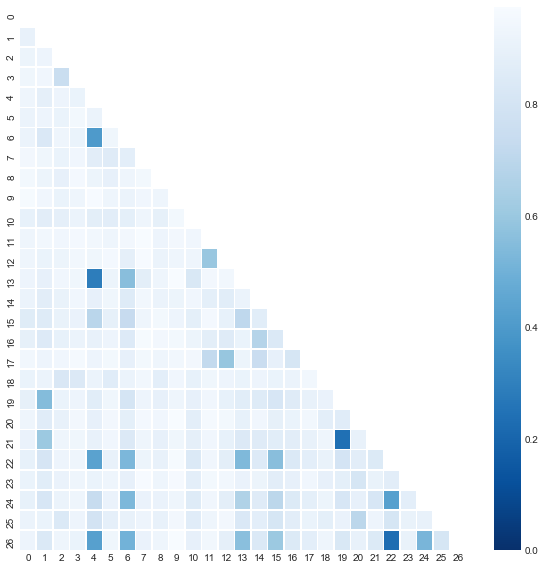


- Mean variance in prototype selection:  0.842768615053953

- Final number of prototypes:  27

# Finished in 0.4119 secs


+ ------------   18    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.4
Prototypes before:
[3, 10, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 137, 181, 190, 254, 271, 299, 334, 338, 351, 354, 376, 398, 402, 405, 415, 419, 424]
Not wanted:
{65, 419, 299, 334, 271, 338, 405, 376, 190, 351}
Final:
[3, 137, 10, 13, 398, 17, 402, 21, 28, 30, 415, 32, 34, 40, 424, 44, 47, 51, 181, 59, 94, 354, 105, 254]

- Prototypes selected
[  3 137  10  13 398  17 402  21  28  30 415  32  34  40 424  44  47  51
 181  59  94 354 105 254]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
137  ->  s. fahlman. faster-learning variations on back-propagation: an empirical study. nan
10  ->  benford  s.  and fahln  l. viewpoints  actionpoints and spatial frames for collaborative user interfaces  nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
398  ->  fahlman  s. e. the recurrent cascade-correlation archi

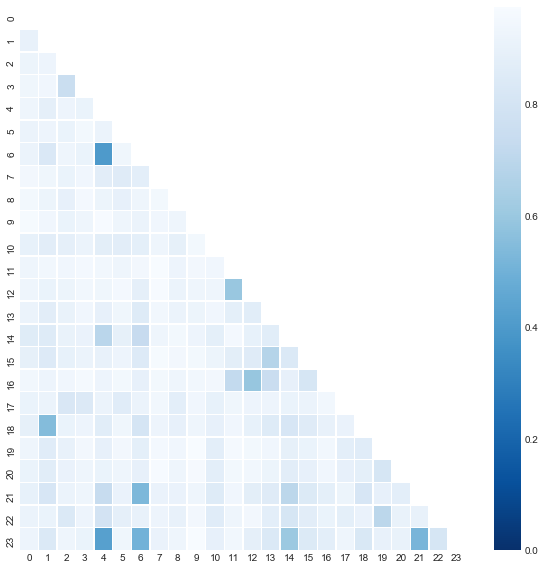


- Mean variance in prototype selection:  0.852137168103048

- Final number of prototypes:  24

# Finished in 0.3820 secs


+ ------------   19    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.1
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.3
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 73, 88, 95, 105, 107, 109, 116, 124, 126, 130, 141, 143, 145, 154, 160, 173, 186, 190, 212, 218, 223, 226, 229, 237, 241, 244, 246, 254, 269, 275, 286, 310, 321, 330, 334, 336, 346, 354, 357, 368, 370, 373, 380, 384, 391, 398, 402, 405, 411, 415, 419, 424, 426, 432, 440, 448, 451, 453, 456]
Not wanted:
{384, 321, 357, 391, 269, 109, 334, 275, 244, 373, 310, 254, 380, 218, 411, 124, 286}
Final:
[3, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 73, 330, 336, 88, 346, 95, 354, 105, 107, 368, 370, 116, 126, 130, 141, 398, 143, 145, 402, 405, 154, 415, 160, 419, 424, 426, 173, 432, 440, 186, 190, 448, 451, 453, 456, 212, 223, 226, 229, 237, 241, 246]

- Prototypes selected
[  3  13  17  21  28  30  32  34  40  44  47  51  59  65  73 330 336  88
 346  95 354 105 107 368 370 116 126 130 141 398 143 145 402 405 154 415
 160 419 424 426 173 432 440 186 190 448 451 453 456 212 223 226 229 237
 241 246]
3  ->  m

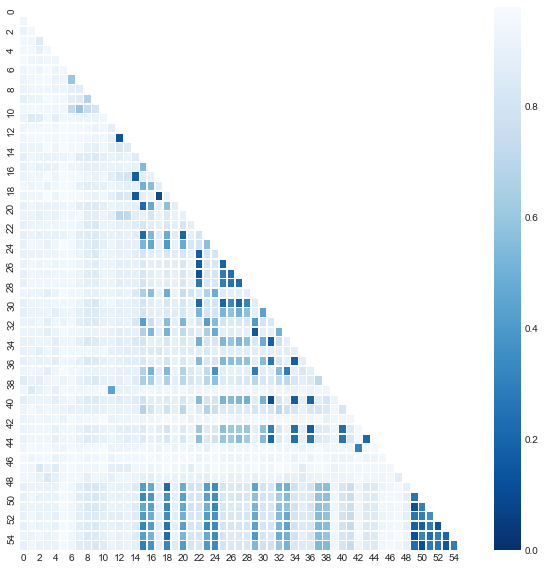


- Mean variance in prototype selection:  0.8122765003971334

- Final number of prototypes:  56

# Finished in 0.4939 secs


+ ------------   20    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.3
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 73, 88, 95, 105, 107, 109, 116, 124, 126, 130, 141, 143, 145, 154, 160, 173, 186, 190, 212, 218, 223, 226, 229, 237, 241, 244, 246, 254, 269, 275, 286, 310, 321, 330, 334, 336, 346, 354, 357, 368, 370, 373, 380, 384, 391, 398, 402, 405, 411, 415, 419, 424, 426, 432, 440, 448, 451, 453, 456]
Not wanted:
{384, 130, 391, 141, 269, 275, 405, 154, 411, 286, 160, 173, 310, 186, 65, 321, 334, 88, 218, 95, 226, 357, 109, 237, 241, 116, 244, 246, 373, 380, 126, 124, 254}
Final:
[3, 13, 398, 143, 17, 145, 402, 21, 28, 30, 415, 32, 34, 419, 40, 424, 426, 44, 47, 432, 51, 440, 59, 190, 448, 451, 453, 456, 73, 330, 336, 212, 346, 223, 354, 229, 105, 107, 368, 370]

- Prototypes selected
[  3  13 398 143  17 145 402  21  28  30 415  32  34 419  40 424 426  44
  47 432  51 440  59 190 448 451 453 456  73 330 336 212 346 223 354 229
 105 107 368 370]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. in

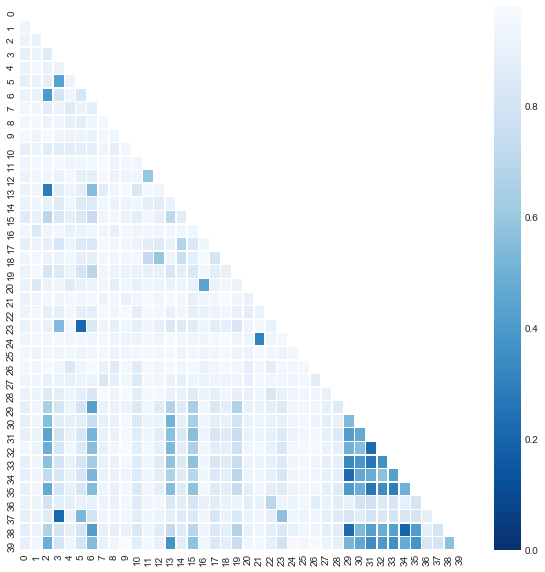


- Mean variance in prototype selection:  0.8356249787823669

- Final number of prototypes:  40

# Finished in 0.5759 secs


+ ------------   21    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.3
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 73, 88, 95, 105, 107, 109, 116, 124, 126, 130, 141, 143, 145, 154, 160, 173, 186, 190, 212, 218, 223, 226, 229, 237, 241, 244, 246, 254, 269, 275, 286, 310, 321, 330, 334, 336, 346, 354, 357, 368, 370, 373, 380, 384, 391, 398, 402, 405, 411, 415, 419, 424, 426, 432, 440, 448, 451, 453, 456]
Not wanted:
{384, 130, 391, 141, 269, 143, 275, 405, 154, 411, 286, 160, 419, 173, 310, 186, 190, 65, 321, 330, 334, 88, 218, 346, 223, 95, 226, 354, 229, 357, 109, 237, 368, 241, 116, 244, 246, 254, 380, 373, 124, 126}
Final:
[3, 13, 398, 17, 145, 402, 21, 28, 30, 415, 32, 34, 40, 424, 426, 44, 47, 432, 51, 440, 59, 448, 451, 453, 456, 73, 336, 212, 105, 107, 370]

- Prototypes selected
[  3  13 398  17 145 402  21  28  30 415  32  34  40 424 426  44  47 432
  51 440  59 448 451 453 456  73 336 212 105 107 370]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl.

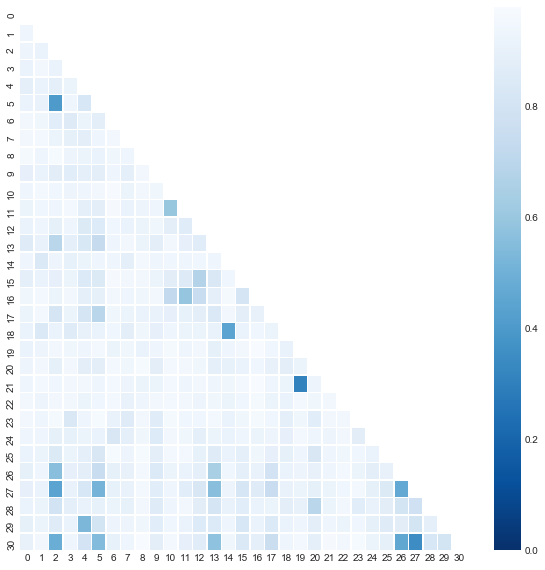


- Mean variance in prototype selection:  0.8654416203606269

- Final number of prototypes:  31

# Finished in 0.4700 secs


+ ------------   22    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.1
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.35
Prototypes before:
[3, 11, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 107, 110, 126, 145, 154, 160, 173, 186, 190, 194, 244, 246, 255, 278, 288, 313, 326, 329, 333, 336, 346, 354, 357, 368, 370, 373, 384, 391, 398, 402, 405, 415, 419, 424, 426, 432, 442, 451, 453, 456, 462, 467, 472, 476, 489, 496, 514, 525, 536, 552, 561, 577]
Not wanted:
{288, 384, 357}
Final:
[514, 3, 11, 13, 525, 17, 21, 278, 536, 28, 30, 32, 34, 40, 552, 44, 47, 561, 51, 313, 59, 65, 577, 326, 329, 333, 336, 346, 94, 354, 105, 107, 110, 368, 370, 373, 126, 391, 398, 145, 402, 405, 154, 415, 160, 419, 424, 426, 173, 432, 186, 442, 190, 194, 451, 453, 456, 462, 467, 472, 476, 489, 496, 244, 246, 255]

- Prototypes selected
[514   3  11  13 525  17  21 278 536  28  30  32  34  40 552  44  47 561
  51 313  59  65 577 326 329 333 336 346  94 354 105 107 110 368 370 373
 126 391 398 145 402 405 154 415 160 419 424 426 173 432 186 442 190 194
 451 453 456 462 467 472 476 489 496 244 246 255]
514  

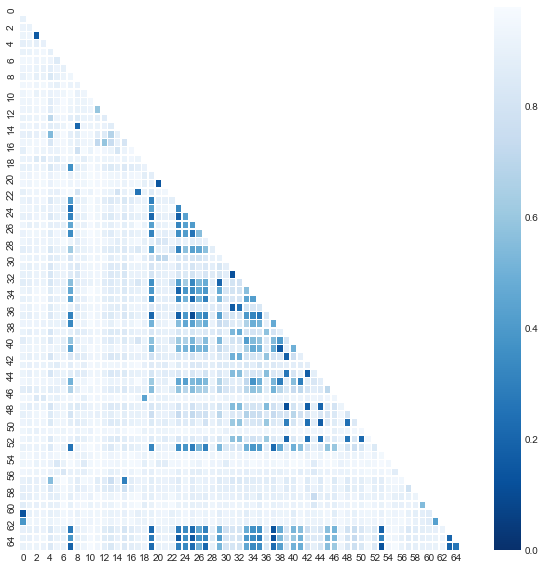


- Mean variance in prototype selection:  0.8295166302916679

- Final number of prototypes:  66

# Finished in 0.5740 secs


+ ------------   23    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.35
Prototypes before:
[3, 11, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 107, 110, 126, 145, 154, 160, 173, 186, 190, 194, 244, 246, 255, 278, 288, 313, 326, 329, 333, 336, 346, 354, 357, 368, 370, 373, 384, 391, 398, 402, 405, 415, 419, 424, 426, 432, 442, 451, 453, 456, 462, 467, 472, 476, 489, 496, 514, 525, 536, 552, 561, 577]
Not wanted:
{384, 514, 391, 13, 405, 278, 154, 160, 288, 173, 313, 186, 65, 326, 333, 357, 110, 370, 244, 126, 255}
Final:
[3, 11, 525, 398, 17, 145, 402, 21, 536, 28, 30, 415, 32, 34, 419, 40, 424, 426, 552, 44, 47, 432, 561, 51, 442, 59, 190, 577, 194, 451, 453, 456, 329, 462, 336, 467, 472, 346, 476, 94, 354, 105, 489, 107, 368, 496, 373, 246]

- Prototypes selected
[  3  11 525 398  17 145 402  21 536  28  30 415  32  34 419  40 424 426
 552  44  47 432 561  51 442  59 190 577 194 451 453 456 329 462 336 467
 472 346 476  94 354 105 489 107 368 496 373 246]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas

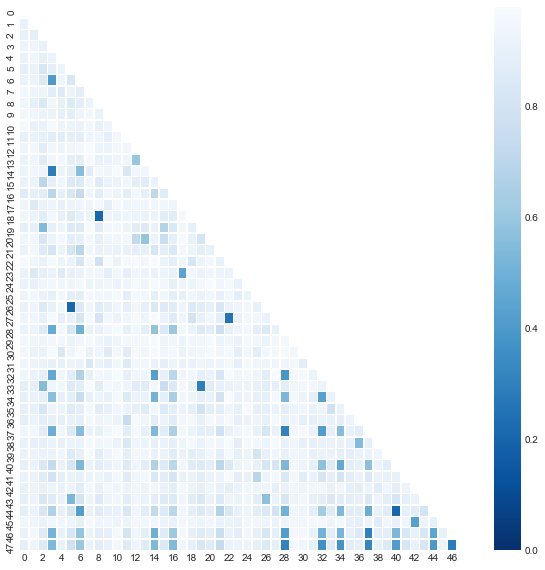


- Mean variance in prototype selection:  0.8603081972160803

- Final number of prototypes:  48

# Finished in 0.5719 secs


+ ------------   24    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.35
Prototypes before:
[3, 11, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 107, 110, 126, 145, 154, 160, 173, 186, 190, 194, 244, 246, 255, 278, 288, 313, 326, 329, 333, 336, 346, 354, 357, 368, 370, 373, 384, 391, 398, 402, 405, 415, 419, 424, 426, 432, 442, 451, 453, 456, 462, 467, 472, 476, 489, 496, 514, 525, 536, 552, 561, 577]
Not wanted:
{384, 514, 391, 13, 405, 278, 154, 160, 288, 419, 552, 173, 313, 186, 190, 65, 577, 326, 329, 333, 462, 346, 357, 110, 368, 370, 244, 373, 246, 126, 255}
Final:
[3, 11, 525, 398, 17, 145, 402, 21, 536, 28, 30, 415, 32, 34, 40, 424, 426, 44, 47, 432, 561, 51, 442, 59, 194, 451, 453, 456, 336, 467, 472, 476, 94, 354, 105, 489, 107, 496]

- Prototypes selected
[  3  11 525 398  17 145 402  21 536  28  30 415  32  34  40 424 426  44
  47 432 561  51 442  59 194 451 453 456 336 467 472 476  94 354 105 489
 107 496]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


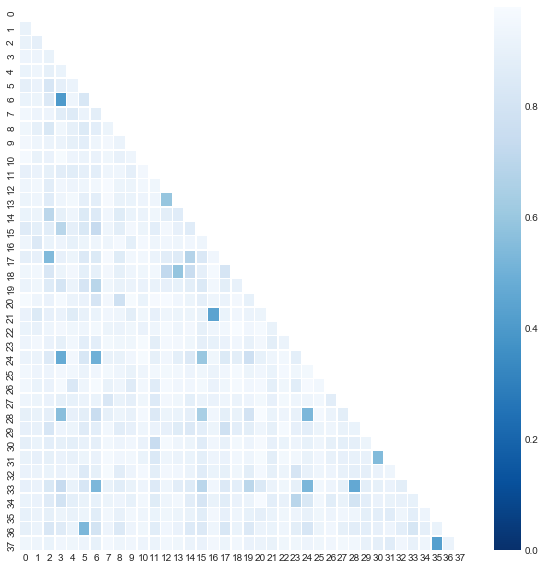


- Mean variance in prototype selection:  0.8750958540927612

- Final number of prototypes:  38

# Finished in 0.5600 secs


+ ------------   25    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.1
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.4
Prototypes before:
[3, 10, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 137, 181, 190, 254, 271, 299, 334, 338, 351, 354, 376, 398, 402, 405, 415, 419, 424, 426, 432, 442, 451, 453, 456, 462, 467, 472, 476, 489, 499, 513, 525, 531, 561, 577, 599, 661, 674, 686, 689, 692, 695, 702, 707, 711, 713, 716, 725, 729, 731]
Not wanted:
{513, 713, 299, 338, 695, 376, 351}
Final:
[3, 10, 13, 525, 271, 17, 531, 21, 28, 30, 32, 34, 40, 44, 47, 561, 51, 59, 65, 577, 334, 599, 94, 354, 105, 137, 398, 402, 405, 661, 415, 674, 419, 424, 426, 686, 432, 689, 692, 181, 442, 190, 702, 451, 707, 453, 711, 456, 716, 462, 467, 725, 472, 729, 731, 476, 489, 499, 254]

- Prototypes selected
[  3  10  13 525 271  17 531  21  28  30  32  34  40  44  47 561  51  59
  65 577 334 599  94 354 105 137 398 402 405 661 415 674 419 424 426 686
 432 689 692 181 442 190 702 451 707 453 711 456 716 462 467 725 472 729
 731 476 489 499 254]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlm

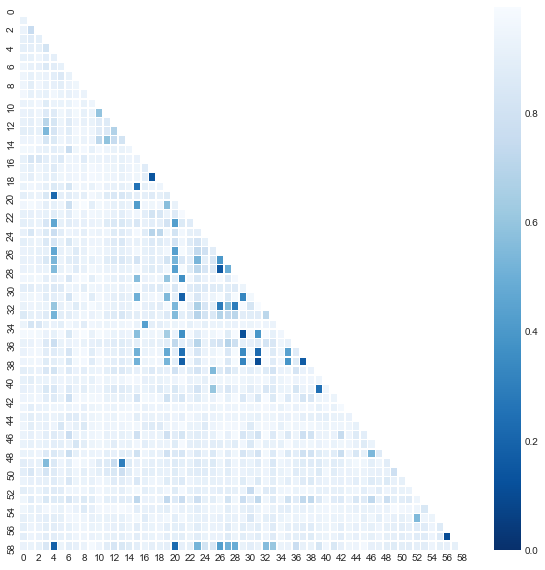


- Mean variance in prototype selection:  0.8754146170977916

- Final number of prototypes:  59

# Finished in 0.5448 secs


+ ------------   26    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.4
Prototypes before:
[3, 10, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 137, 181, 190, 254, 271, 299, 334, 338, 351, 354, 376, 398, 402, 405, 415, 419, 424, 426, 432, 442, 451, 453, 456, 462, 467, 472, 476, 489, 499, 513, 525, 531, 561, 577, 599, 661, 674, 686, 689, 692, 695, 702, 707, 711, 713, 716, 725, 729, 731]
Not wanted:
{65, 513, 674, 713, 299, 686, 271, 338, 499, 692, 405, 695, 376, 351}
Final:
[3, 10, 13, 525, 17, 531, 21, 28, 30, 32, 34, 40, 44, 47, 561, 51, 59, 577, 334, 599, 94, 354, 105, 137, 398, 402, 661, 415, 419, 424, 426, 432, 689, 181, 442, 190, 702, 451, 707, 453, 711, 456, 716, 462, 467, 725, 472, 729, 731, 476, 489, 254]

- Prototypes selected
[  3  10  13 525  17 531  21  28  30  32  34  40  44  47 561  51  59 577
 334 599  94 354 105 137 398 402 661 415 419 424 426 432 689 181 442 190
 702 451 707 453 711 456 716 462 467 725 472 729 731 476 489 254]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. ander

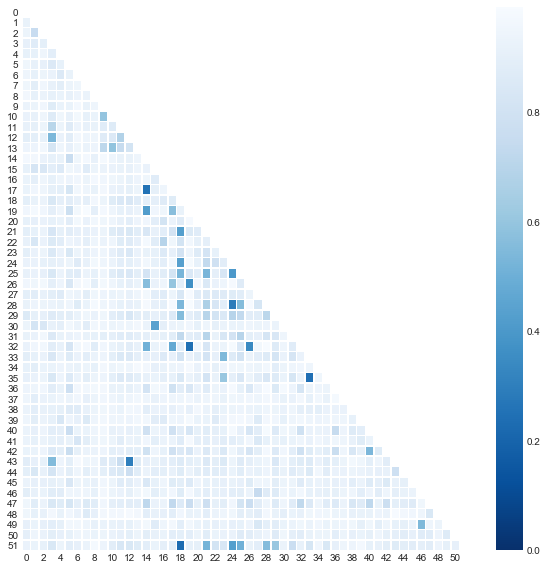


- Mean variance in prototype selection:  0.8799942995808983

- Final number of prototypes:  52

# Finished in 0.6711 secs


+ ------------   27    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.4
Prototypes before:
[3, 10, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 137, 181, 190, 254, 271, 299, 334, 338, 351, 354, 376, 398, 402, 405, 415, 419, 424, 426, 432, 442, 451, 453, 456, 462, 467, 472, 476, 489, 499, 513, 525, 531, 561, 577, 599, 661, 674, 686, 689, 692, 695, 702, 707, 711, 713, 716, 725, 729, 731]
Not wanted:
{513, 271, 405, 674, 419, 299, 686, 689, 692, 695, 190, 65, 577, 713, 462, 334, 338, 351, 499, 376}
Final:
[3, 137, 10, 13, 398, 525, 17, 402, 531, 21, 661, 28, 30, 415, 32, 34, 40, 424, 426, 44, 47, 432, 561, 51, 181, 442, 59, 702, 451, 707, 453, 711, 456, 716, 467, 725, 599, 472, 729, 731, 476, 94, 354, 105, 489, 254]

- Prototypes selected
[  3 137  10  13 398 525  17 402 531  21 661  28  30 415  32  34  40 424
 426  44  47 432 561  51 181 442  59 702 451 707 453 711 456 716 467 725
 599 472 729 731 476  94 354 105 489 254]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 

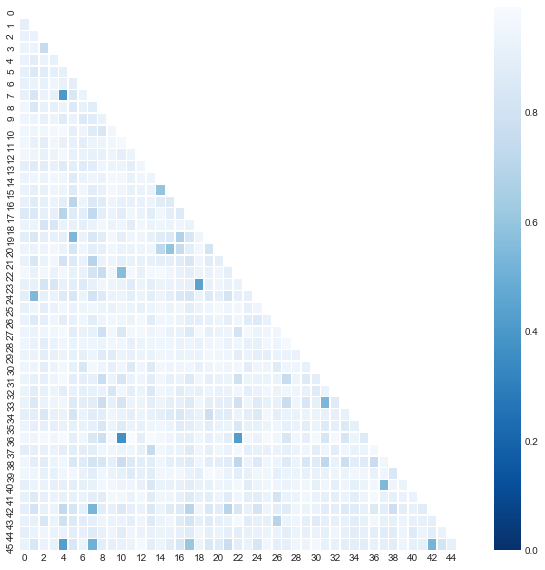


- Mean variance in prototype selection:  0.884505711120248

- Final number of prototypes:  46

# Finished in 0.5650 secs


+ ------------   28    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.1
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.3
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 73, 88, 95, 105, 107, 109, 116, 124, 126, 130, 141, 143, 145, 154, 160, 173, 186, 190, 212, 218, 223, 226, 229, 237, 241, 244, 246, 254, 269, 275, 286, 310, 321, 330, 334, 336, 346, 354, 357, 368, 370, 373, 380, 384, 391, 398, 402, 405, 411, 415, 419, 424, 426, 432, 440, 448, 451, 453, 456, 462, 467, 472, 476, 489, 496, 514, 525, 536, 551, 563, 577, 582, 584, 588, 596, 613, 644, 653, 661, 671, 677, 686, 689, 691, 696, 699, 702, 707, 711, 713, 716, 725, 729, 731, 744, 759, 772, 774, 778, 783, 788, 792, 796, 801, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 911, 934, 937, 941, 963, 972, 982, 988, 998, 1004, 1006, 1009, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1066, 1098, 1110, 1114, 1119, 1121, 1132, 1147, 1158, 1163, 1166, 1168, 1170, 1179, 1194, 1201, 1208, 1216, 1222, 1230, 1244, 1254, 1257, 1265, 1270, 1273, 1279, 1288, 1293, 1296, 1306, 1319, 1325, 1329, 1335, 1340, 1344, 1348, 1352, 13

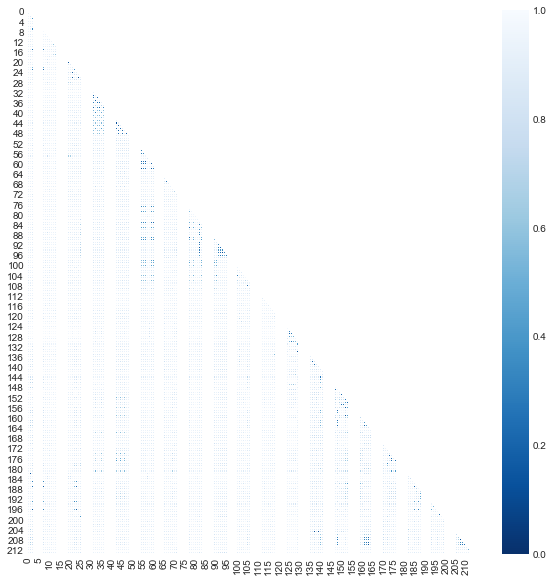


- Mean variance in prototype selection:  0.8929257727955353

- Final number of prototypes:  214

# Finished in 1.5999 secs


+ ------------   29    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.3
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 73, 88, 95, 105, 107, 109, 116, 124, 126, 130, 141, 143, 145, 154, 160, 173, 186, 190, 212, 218, 223, 226, 229, 237, 241, 244, 246, 254, 269, 275, 286, 310, 321, 330, 334, 336, 346, 354, 357, 368, 370, 373, 380, 384, 391, 398, 402, 405, 411, 415, 419, 424, 426, 432, 440, 448, 451, 453, 456, 462, 467, 472, 476, 489, 496, 514, 525, 536, 551, 563, 577, 582, 584, 588, 596, 613, 644, 653, 661, 671, 677, 686, 689, 691, 696, 699, 702, 707, 711, 713, 716, 725, 729, 731, 744, 759, 772, 774, 778, 783, 788, 792, 796, 801, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 911, 934, 937, 941, 963, 972, 982, 988, 998, 1004, 1006, 1009, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1066, 1098, 1110, 1114, 1119, 1121, 1132, 1147, 1158, 1163, 1166, 1168, 1170, 1179, 1194, 1201, 1208, 1216, 1222, 1230, 1244, 1254, 1257, 1265, 1270, 1273, 1279, 1288, 1293, 1296, 1306, 1319, 1325, 1329, 1335, 1340, 1344, 1348, 1352, 13

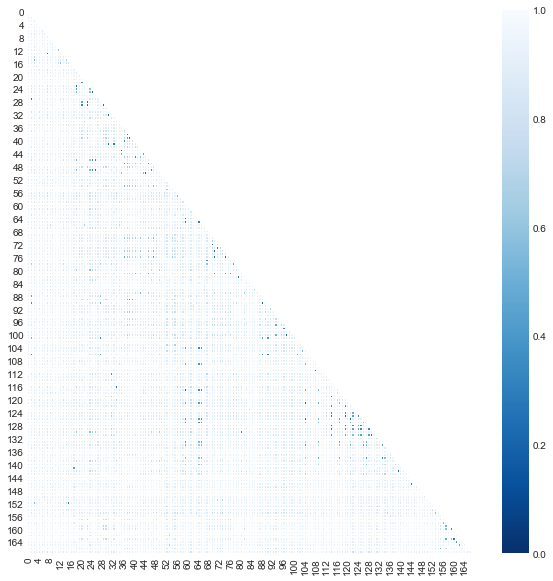


- Mean variance in prototype selection:  0.8997540129421264

- Final number of prototypes:  168

# Finished in 1.3195 secs


+ ------------   30    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.3
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 73, 88, 95, 105, 107, 109, 116, 124, 126, 130, 141, 143, 145, 154, 160, 173, 186, 190, 212, 218, 223, 226, 229, 237, 241, 244, 246, 254, 269, 275, 286, 310, 321, 330, 334, 336, 346, 354, 357, 368, 370, 373, 380, 384, 391, 398, 402, 405, 411, 415, 419, 424, 426, 432, 440, 448, 451, 453, 456, 462, 467, 472, 476, 489, 496, 514, 525, 536, 551, 563, 577, 582, 584, 588, 596, 613, 644, 653, 661, 671, 677, 686, 689, 691, 696, 699, 702, 707, 711, 713, 716, 725, 729, 731, 744, 759, 772, 774, 778, 783, 788, 792, 796, 801, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 911, 934, 937, 941, 963, 972, 982, 988, 998, 1004, 1006, 1009, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1066, 1098, 1110, 1114, 1119, 1121, 1132, 1147, 1158, 1163, 1166, 1168, 1170, 1179, 1194, 1201, 1208, 1216, 1222, 1230, 1244, 1254, 1257, 1265, 1270, 1273, 1279, 1288, 1293, 1296, 1306, 1319, 1325, 1329, 1335, 1340, 1344, 1348, 1352, 13

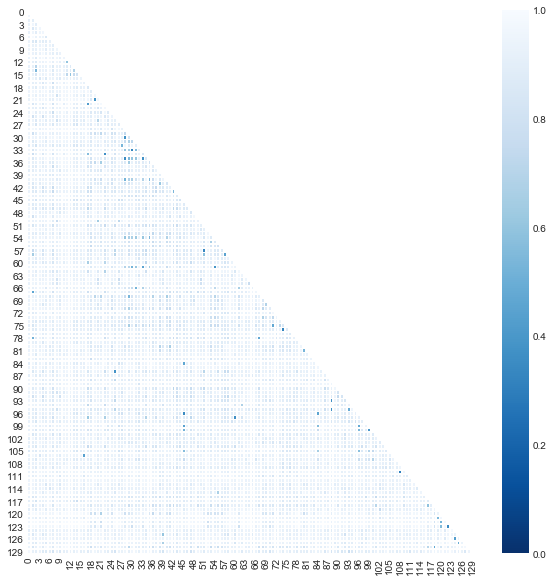


- Mean variance in prototype selection:  0.9049214734307778

- Final number of prototypes:  130

# Finished in 1.2335 secs


+ ------------   31    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.1
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.35
Prototypes before:
[3, 11, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 107, 110, 126, 145, 154, 160, 173, 186, 190, 194, 244, 246, 255, 278, 288, 313, 326, 329, 333, 336, 346, 354, 357, 368, 370, 373, 384, 391, 398, 402, 405, 415, 419, 424, 426, 432, 442, 451, 453, 456, 462, 467, 472, 476, 489, 496, 514, 525, 536, 552, 561, 577, 583, 611, 645, 661, 673, 684, 686, 689, 691, 699, 702, 707, 711, 713, 716, 725, 729, 731, 755, 774, 778, 783, 788, 792, 796, 801, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 929, 972, 982, 995, 1000, 1003, 1006, 1009, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1067, 1098, 1102, 1110, 1114, 1119, 1121, 1132, 1146, 1160, 1163, 1166, 1168, 1170, 1179, 1201, 1208, 1216, 1223, 1230, 1244, 1254, 1257, 1267, 1276, 1279, 1288, 1293, 1296, 1306, 1319, 1324, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1366, 1375, 1385, 1391, 1395, 1398, 1401, 1406, 1412, 1416, 1421, 1429, 1440, 1446, 1453, 1464, 1473, 1480, 1487, 1490, 1494, 1498, 15

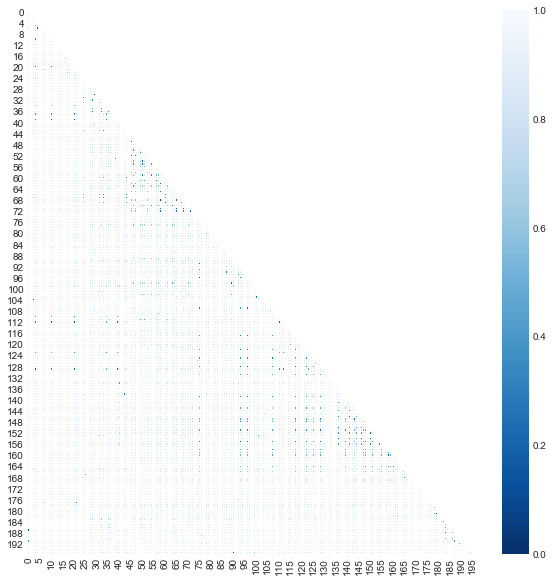


- Mean variance in prototype selection:  0.8936739822627106

- Final number of prototypes:  196

# Finished in 1.2810 secs


+ ------------   32    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.35
Prototypes before:
[3, 11, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 107, 110, 126, 145, 154, 160, 173, 186, 190, 194, 244, 246, 255, 278, 288, 313, 326, 329, 333, 336, 346, 354, 357, 368, 370, 373, 384, 391, 398, 402, 405, 415, 419, 424, 426, 432, 442, 451, 453, 456, 462, 467, 472, 476, 489, 496, 514, 525, 536, 552, 561, 577, 583, 611, 645, 661, 673, 684, 686, 689, 691, 699, 702, 707, 711, 713, 716, 725, 729, 731, 755, 774, 778, 783, 788, 792, 796, 801, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 929, 972, 982, 995, 1000, 1003, 1006, 1009, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1067, 1098, 1102, 1110, 1114, 1119, 1121, 1132, 1146, 1160, 1163, 1166, 1168, 1170, 1179, 1201, 1208, 1216, 1223, 1230, 1244, 1254, 1257, 1267, 1276, 1279, 1288, 1293, 1296, 1306, 1319, 1324, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1366, 1375, 1385, 1391, 1395, 1398, 1401, 1406, 1412, 1416, 1421, 1429, 1440, 1446, 1453, 1464, 1473, 1480, 1487, 1490, 1494, 1498, 15

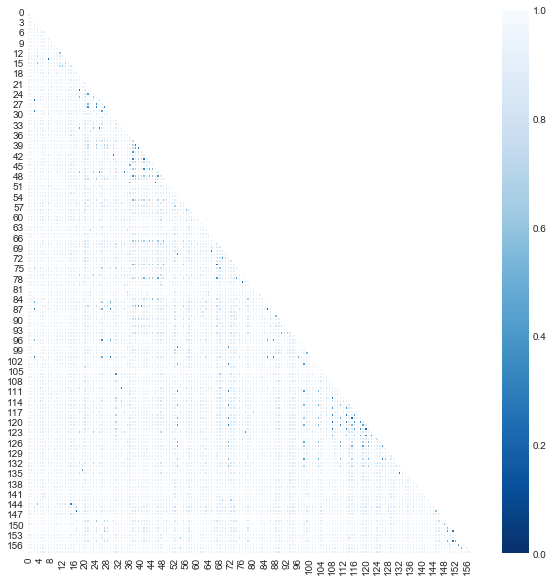


- Mean variance in prototype selection:  0.9008569066847243

- Final number of prototypes:  159

# Finished in 1.3296 secs


+ ------------   33    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.35
Prototypes before:
[3, 11, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 107, 110, 126, 145, 154, 160, 173, 186, 190, 194, 244, 246, 255, 278, 288, 313, 326, 329, 333, 336, 346, 354, 357, 368, 370, 373, 384, 391, 398, 402, 405, 415, 419, 424, 426, 432, 442, 451, 453, 456, 462, 467, 472, 476, 489, 496, 514, 525, 536, 552, 561, 577, 583, 611, 645, 661, 673, 684, 686, 689, 691, 699, 702, 707, 711, 713, 716, 725, 729, 731, 755, 774, 778, 783, 788, 792, 796, 801, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 929, 972, 982, 995, 1000, 1003, 1006, 1009, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1067, 1098, 1102, 1110, 1114, 1119, 1121, 1132, 1146, 1160, 1163, 1166, 1168, 1170, 1179, 1201, 1208, 1216, 1223, 1230, 1244, 1254, 1257, 1267, 1276, 1279, 1288, 1293, 1296, 1306, 1319, 1324, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1366, 1375, 1385, 1391, 1395, 1398, 1401, 1406, 1412, 1416, 1421, 1429, 1440, 1446, 1453, 1464, 1473, 1480, 1487, 1490, 1494, 1498, 15

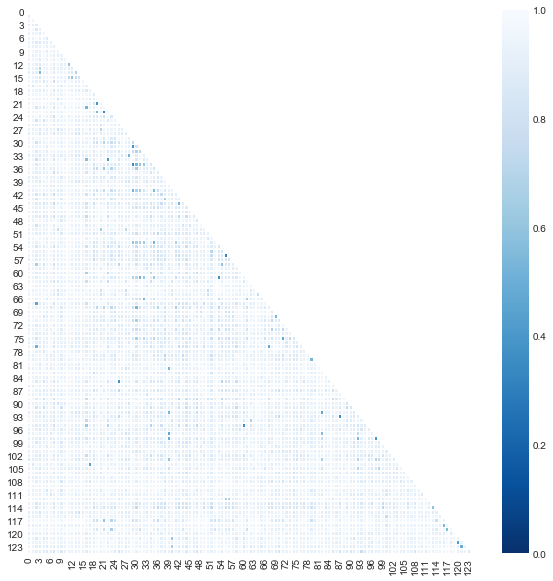


- Mean variance in prototype selection:  0.9048768815265451

- Final number of prototypes:  125

# Finished in 1.1726 secs


+ ------------   34    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.1
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.4
Prototypes before:
[3, 10, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 137, 181, 190, 254, 271, 299, 334, 338, 351, 354, 376, 398, 402, 405, 415, 419, 424, 426, 432, 442, 451, 453, 456, 462, 467, 472, 476, 489, 499, 513, 525, 531, 561, 577, 599, 661, 674, 686, 689, 692, 695, 702, 707, 711, 713, 716, 725, 729, 731, 755, 774, 778, 783, 788, 792, 794, 796, 801, 822, 840, 847, 852, 857, 860, 864, 874, 883, 888, 948, 1006, 1009, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1067, 1099, 1107, 1114, 1119, 1121, 1132, 1146, 1160, 1163, 1166, 1168, 1170, 1179, 1200, 1212, 1216, 1223, 1230, 1244, 1254, 1257, 1269, 1279, 1292, 1296, 1306, 1319, 1324, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1366, 1382, 1398, 1412, 1414, 1416, 1421, 1429, 1440, 1452, 1464, 1473, 1480, 1487, 1490, 1494, 1498, 1502, 1506, 1510, 1515, 1519, 1534, 1552, 1569, 1581, 1591, 1594, 1603, 1611, 1613, 1621, 1647, 1655, 1659, 1661, 1663, 1677, 1694, 1724, 1732, 1768, 1774, 1780, 1793, 1804, 1823

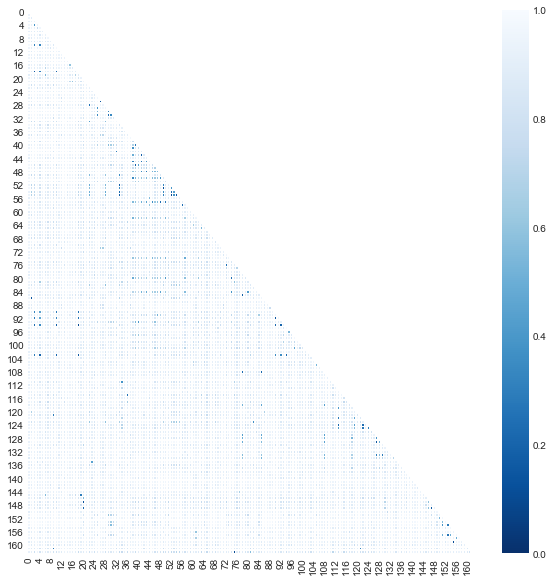


- Mean variance in prototype selection:  0.8987686373990812

- Final number of prototypes:  163

# Finished in 1.4117 secs


+ ------------   35    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.4
Prototypes before:
[3, 10, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 137, 181, 190, 254, 271, 299, 334, 338, 351, 354, 376, 398, 402, 405, 415, 419, 424, 426, 432, 442, 451, 453, 456, 462, 467, 472, 476, 489, 499, 513, 525, 531, 561, 577, 599, 661, 674, 686, 689, 692, 695, 702, 707, 711, 713, 716, 725, 729, 731, 755, 774, 778, 783, 788, 792, 794, 796, 801, 822, 840, 847, 852, 857, 860, 864, 874, 883, 888, 948, 1006, 1009, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1067, 1099, 1107, 1114, 1119, 1121, 1132, 1146, 1160, 1163, 1166, 1168, 1170, 1179, 1200, 1212, 1216, 1223, 1230, 1244, 1254, 1257, 1269, 1279, 1292, 1296, 1306, 1319, 1324, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1366, 1382, 1398, 1412, 1414, 1416, 1421, 1429, 1440, 1452, 1464, 1473, 1480, 1487, 1490, 1494, 1498, 1502, 1506, 1510, 1515, 1519, 1534, 1552, 1569, 1581, 1591, 1594, 1603, 1611, 1613, 1621, 1647, 1655, 1659, 1661, 1663, 1677, 1694, 1724, 1732, 1768, 1774, 1780, 1793, 1804, 1823

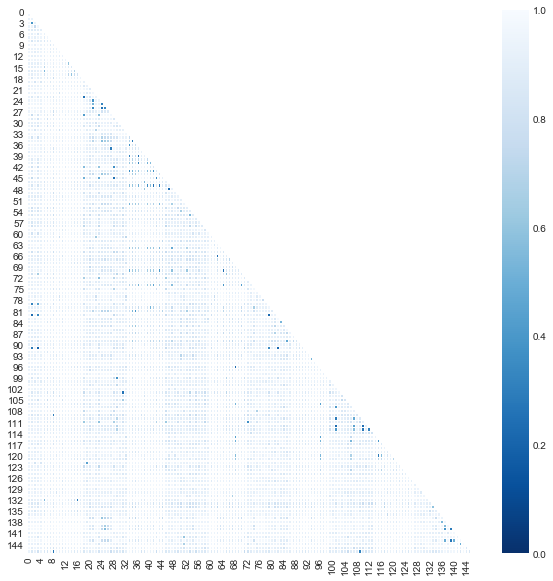


- Mean variance in prototype selection:  0.9013095905109612

- Final number of prototypes:  147

# Finished in 1.0785 secs


+ ------------   36    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.4
Prototypes before:
[3, 10, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 137, 181, 190, 254, 271, 299, 334, 338, 351, 354, 376, 398, 402, 405, 415, 419, 424, 426, 432, 442, 451, 453, 456, 462, 467, 472, 476, 489, 499, 513, 525, 531, 561, 577, 599, 661, 674, 686, 689, 692, 695, 702, 707, 711, 713, 716, 725, 729, 731, 755, 774, 778, 783, 788, 792, 794, 796, 801, 822, 840, 847, 852, 857, 860, 864, 874, 883, 888, 948, 1006, 1009, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1067, 1099, 1107, 1114, 1119, 1121, 1132, 1146, 1160, 1163, 1166, 1168, 1170, 1179, 1200, 1212, 1216, 1223, 1230, 1244, 1254, 1257, 1269, 1279, 1292, 1296, 1306, 1319, 1324, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1366, 1382, 1398, 1412, 1414, 1416, 1421, 1429, 1440, 1452, 1464, 1473, 1480, 1487, 1490, 1494, 1498, 1502, 1506, 1510, 1515, 1519, 1534, 1552, 1569, 1581, 1591, 1594, 1603, 1611, 1613, 1621, 1647, 1655, 1659, 1661, 1663, 1677, 1694, 1724, 1732, 1768, 1774, 1780, 1793, 1804, 1823

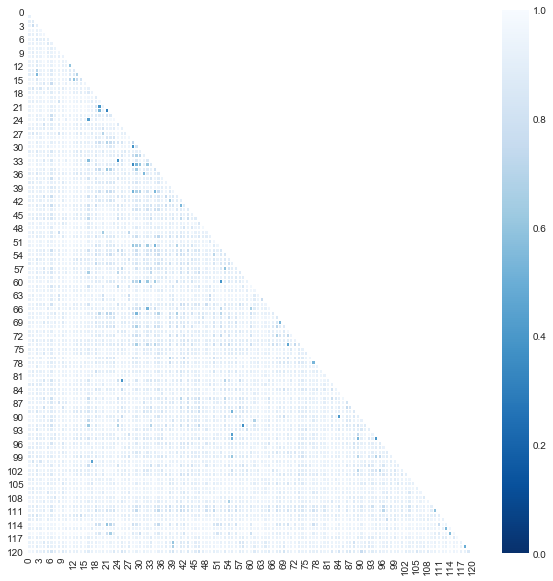


- Mean variance in prototype selection:  0.9049957682254092

- Final number of prototypes:  121

# Finished in 0.9608 secs


+ ------------   37    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.1
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.3
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 73, 88, 95, 105, 107, 109, 116, 124, 126, 130, 141, 143, 145, 154, 160, 173, 186, 190, 212, 218, 223, 226, 229, 237, 241, 244, 246, 254, 269, 275, 286, 310, 321, 330, 334, 336, 346, 354, 357, 368, 370, 373, 380, 384, 391, 398, 402, 405, 411, 415, 419, 424, 426, 432, 440, 448, 451, 453, 456, 462, 467, 472, 476, 489, 496, 514, 525, 536, 551, 563, 577, 582, 584, 588, 596, 613, 644, 653, 661, 671, 677, 686, 689, 691, 696, 699, 702, 707, 711, 713, 716, 725, 729, 731, 744, 759, 772, 774, 778, 783, 788, 792, 796, 801, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 911, 934, 937, 941, 963, 972, 982, 988, 998, 1004, 1006, 1009, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1066, 1098, 1110, 1114, 1119, 1121, 1132, 1147, 1158, 1163, 1166, 1168, 1170, 1179, 1194, 1201, 1208, 1216, 1222, 1230, 1244, 1254, 1257, 1265, 1270, 1273, 1279, 1288, 1293, 1296, 1306, 1319, 1325, 1329, 1335, 1340, 1344, 1348, 1352, 13

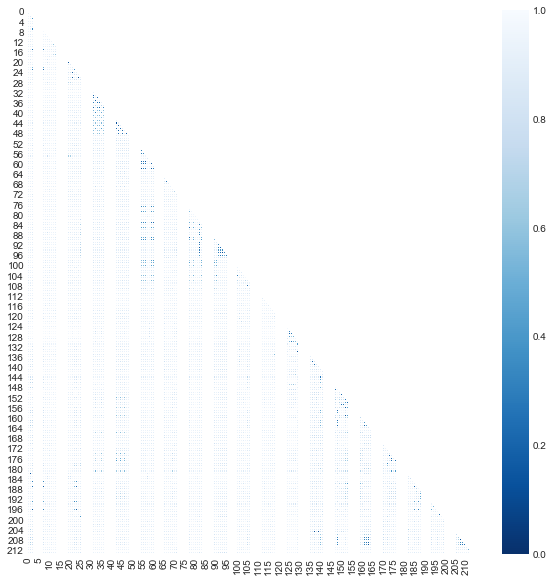


- Mean variance in prototype selection:  0.8929257727955353

- Final number of prototypes:  214

# Finished in 1.6465 secs


+ ------------   38    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.3
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 73, 88, 95, 105, 107, 109, 116, 124, 126, 130, 141, 143, 145, 154, 160, 173, 186, 190, 212, 218, 223, 226, 229, 237, 241, 244, 246, 254, 269, 275, 286, 310, 321, 330, 334, 336, 346, 354, 357, 368, 370, 373, 380, 384, 391, 398, 402, 405, 411, 415, 419, 424, 426, 432, 440, 448, 451, 453, 456, 462, 467, 472, 476, 489, 496, 514, 525, 536, 551, 563, 577, 582, 584, 588, 596, 613, 644, 653, 661, 671, 677, 686, 689, 691, 696, 699, 702, 707, 711, 713, 716, 725, 729, 731, 744, 759, 772, 774, 778, 783, 788, 792, 796, 801, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 911, 934, 937, 941, 963, 972, 982, 988, 998, 1004, 1006, 1009, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1066, 1098, 1110, 1114, 1119, 1121, 1132, 1147, 1158, 1163, 1166, 1168, 1170, 1179, 1194, 1201, 1208, 1216, 1222, 1230, 1244, 1254, 1257, 1265, 1270, 1273, 1279, 1288, 1293, 1296, 1306, 1319, 1325, 1329, 1335, 1340, 1344, 1348, 1352, 13

845  ->  m. pazzani and d. kibler  "the utility of knowledge in inductive learning " machine learning 
1357  ->  r.a. mccallum. overcoming incomplete perception with utile distinction memory. nan
1871  ->  r.c. yee  s. saxena  p.e. utgoff  and a.g. barto. explaining temporal differences to create useful concepts for evaluating states. nan
336  ->  s. fahlman and c. libiere  "the cascade correlation architecture"  nan
1362  ->  a. mehra  z. wang  and k. shin  "self-parameterizing protocol stacks for guaranteed quality of service " nan
1874  ->  richard c. yee  sharad saxena  paul e. utgoff  and andrew c. barto. explaining temporal-differences to create useful concepts for evaluating states. nan
852  ->  porter  b. w.  & kibler  d. f. experimental goal regression: a method for learning problem-solving. machine learning 
1364  ->  minton  s.  drummond  m.  bresina  j. l.  & phillips  a. b. total order vs. partial order planning: factors influencing performance. nan
1366  ->  mitchell  t.m

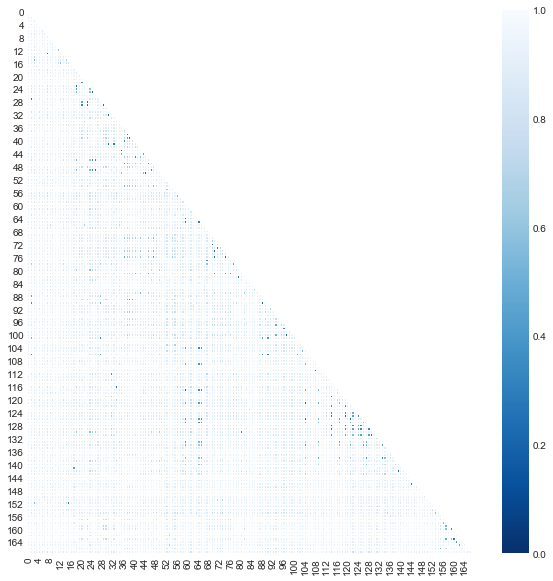


- Mean variance in prototype selection:  0.8997540129421264

- Final number of prototypes:  168

# Finished in 1.3910 secs


+ ------------   39    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.6
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.3
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 73, 88, 95, 105, 107, 109, 116, 124, 126, 130, 141, 143, 145, 154, 160, 173, 186, 190, 212, 218, 223, 226, 229, 237, 241, 244, 246, 254, 269, 275, 286, 310, 321, 330, 334, 336, 346, 354, 357, 368, 370, 373, 380, 384, 391, 398, 402, 405, 411, 415, 419, 424, 426, 432, 440, 448, 451, 453, 456, 462, 467, 472, 476, 489, 496, 514, 525, 536, 551, 563, 577, 582, 584, 588, 596, 613, 644, 653, 661, 671, 677, 686, 689, 691, 696, 699, 702, 707, 711, 713, 716, 725, 729, 731, 744, 759, 772, 774, 778, 783, 788, 792, 796, 801, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 911, 934, 937, 941, 963, 972, 982, 988, 998, 1004, 1006, 1009, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1066, 1098, 1110, 1114, 1119, 1121, 1132, 1147, 1158, 1163, 1166, 1168, 1170, 1179, 1194, 1201, 1208, 1216, 1222, 1230, 1244, 1254, 1257, 1265, 1270, 1273, 1279, 1288, 1293, 1296, 1306, 1319, 1325, 1329, 1335, 1340, 1344, 1348, 1352, 13

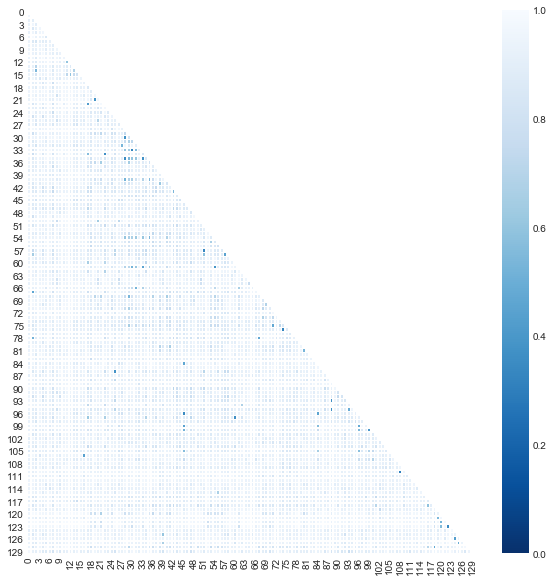


- Mean variance in prototype selection:  0.9049214734307778

- Final number of prototypes:  130

# Finished in 1.3074 secs


+ ------------   40    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.1
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.35
Prototypes before:
[3, 11, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 107, 110, 126, 145, 154, 160, 173, 186, 190, 194, 244, 246, 255, 278, 288, 313, 326, 329, 333, 336, 346, 354, 357, 368, 370, 373, 384, 391, 398, 402, 405, 415, 419, 424, 426, 432, 442, 451, 453, 456, 462, 467, 472, 476, 489, 496, 514, 525, 536, 552, 561, 577, 583, 611, 645, 661, 673, 684, 686, 689, 691, 699, 702, 707, 711, 713, 716, 725, 729, 731, 755, 774, 778, 783, 788, 792, 796, 801, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 929, 972, 982, 995, 1000, 1003, 1006, 1009, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1067, 1098, 1102, 1110, 1114, 1119, 1121, 1132, 1146, 1160, 1163, 1166, 1168, 1170, 1179, 1201, 1208, 1216, 1223, 1230, 1244, 1254, 1257, 1267, 1276, 1279, 1288, 1293, 1296, 1306, 1319, 1324, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1366, 1375, 1385, 1391, 1395, 1398, 1401, 1406, 1412, 1416, 1421, 1429, 1440, 1446, 1453, 1464, 1473, 1480, 1487, 1490, 1494, 1498, 15

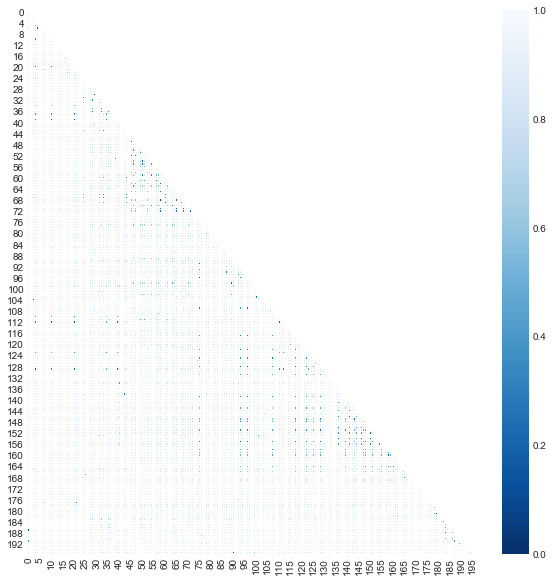


- Mean variance in prototype selection:  0.8936739822627106

- Final number of prototypes:  196

# Finished in 1.3234 secs


+ ------------   41    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.35
Prototypes before:
[3, 11, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 107, 110, 126, 145, 154, 160, 173, 186, 190, 194, 244, 246, 255, 278, 288, 313, 326, 329, 333, 336, 346, 354, 357, 368, 370, 373, 384, 391, 398, 402, 405, 415, 419, 424, 426, 432, 442, 451, 453, 456, 462, 467, 472, 476, 489, 496, 514, 525, 536, 552, 561, 577, 583, 611, 645, 661, 673, 684, 686, 689, 691, 699, 702, 707, 711, 713, 716, 725, 729, 731, 755, 774, 778, 783, 788, 792, 796, 801, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 929, 972, 982, 995, 1000, 1003, 1006, 1009, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1067, 1098, 1102, 1110, 1114, 1119, 1121, 1132, 1146, 1160, 1163, 1166, 1168, 1170, 1179, 1201, 1208, 1216, 1223, 1230, 1244, 1254, 1257, 1267, 1276, 1279, 1288, 1293, 1296, 1306, 1319, 1324, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1366, 1375, 1385, 1391, 1395, 1398, 1401, 1406, 1412, 1416, 1421, 1429, 1440, 1446, 1453, 1464, 1473, 1480, 1487, 1490, 1494, 1498, 15

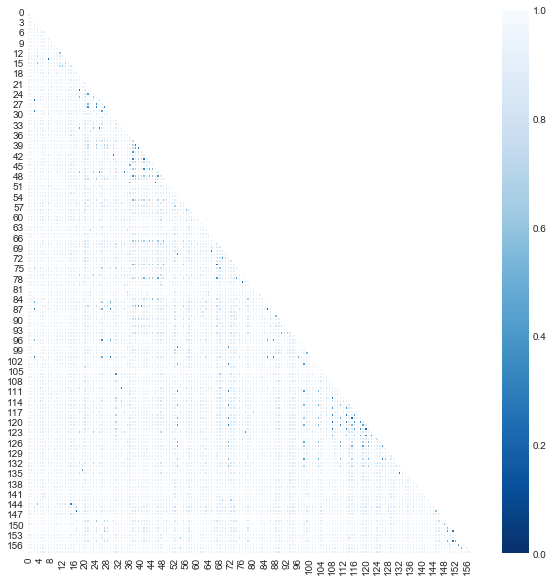


- Mean variance in prototype selection:  0.9008569066847243

- Final number of prototypes:  159

# Finished in 1.2840 secs


+ ------------   42    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.7
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.35
Prototypes before:
[3, 11, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 107, 110, 126, 145, 154, 160, 173, 186, 190, 194, 244, 246, 255, 278, 288, 313, 326, 329, 333, 336, 346, 354, 357, 368, 370, 373, 384, 391, 398, 402, 405, 415, 419, 424, 426, 432, 442, 451, 453, 456, 462, 467, 472, 476, 489, 496, 514, 525, 536, 552, 561, 577, 583, 611, 645, 661, 673, 684, 686, 689, 691, 699, 702, 707, 711, 713, 716, 725, 729, 731, 755, 774, 778, 783, 788, 792, 796, 801, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 929, 972, 982, 995, 1000, 1003, 1006, 1009, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1067, 1098, 1102, 1110, 1114, 1119, 1121, 1132, 1146, 1160, 1163, 1166, 1168, 1170, 1179, 1201, 1208, 1216, 1223, 1230, 1244, 1254, 1257, 1267, 1276, 1279, 1288, 1293, 1296, 1306, 1319, 1324, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1366, 1375, 1385, 1391, 1395, 1398, 1401, 1406, 1412, 1416, 1421, 1429, 1440, 1446, 1453, 1464, 1473, 1480, 1487, 1490, 1494, 1498, 15

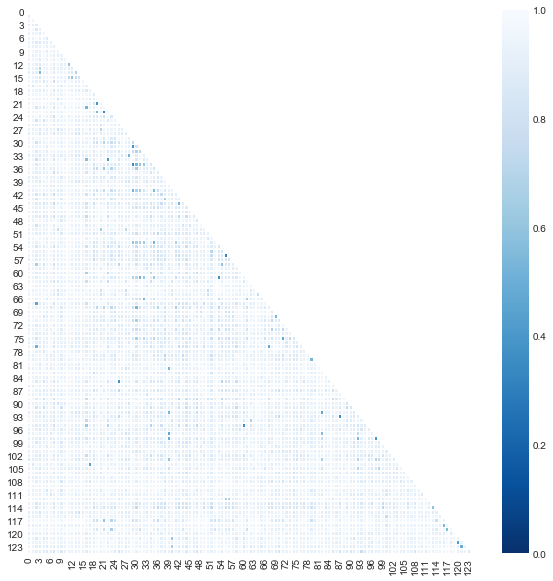


- Mean variance in prototype selection:  0.9048768815265451

- Final number of prototypes:  125

# Finished in 1.0802 secs


+ ------------   43    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.1
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.4
Prototypes before:
[3, 10, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 137, 181, 190, 254, 271, 299, 334, 338, 351, 354, 376, 398, 402, 405, 415, 419, 424, 426, 432, 442, 451, 453, 456, 462, 467, 472, 476, 489, 499, 513, 525, 531, 561, 577, 599, 661, 674, 686, 689, 692, 695, 702, 707, 711, 713, 716, 725, 729, 731, 755, 774, 778, 783, 788, 792, 794, 796, 801, 822, 840, 847, 852, 857, 860, 864, 874, 883, 888, 948, 1006, 1009, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1067, 1099, 1107, 1114, 1119, 1121, 1132, 1146, 1160, 1163, 1166, 1168, 1170, 1179, 1200, 1212, 1216, 1223, 1230, 1244, 1254, 1257, 1269, 1279, 1292, 1296, 1306, 1319, 1324, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1366, 1382, 1398, 1412, 1414, 1416, 1421, 1429, 1440, 1452, 1464, 1473, 1480, 1487, 1490, 1494, 1498, 1502, 1506, 1510, 1515, 1519, 1534, 1552, 1569, 1581, 1591, 1594, 1603, 1611, 1613, 1621, 1647, 1655, 1659, 1661, 1663, 1677, 1694, 1724, 1732, 1768, 1774, 1780, 1793, 1804, 1823

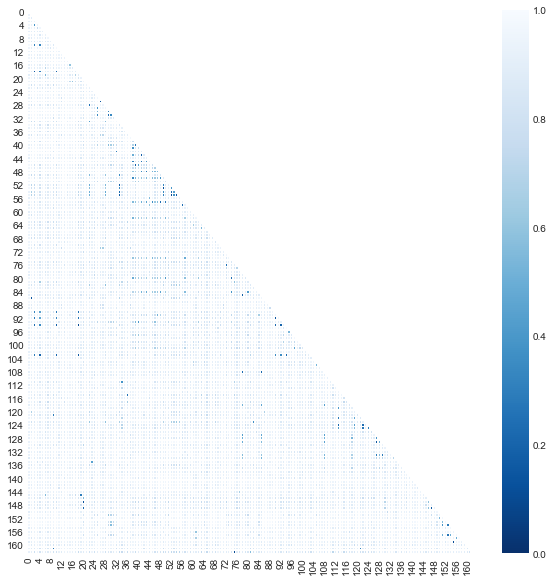


- Mean variance in prototype selection:  0.8987686373990812

- Final number of prototypes:  163

# Finished in 1.1147 secs


+ ------------   44    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.2
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.4
Prototypes before:
[3, 10, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 137, 181, 190, 254, 271, 299, 334, 338, 351, 354, 376, 398, 402, 405, 415, 419, 424, 426, 432, 442, 451, 453, 456, 462, 467, 472, 476, 489, 499, 513, 525, 531, 561, 577, 599, 661, 674, 686, 689, 692, 695, 702, 707, 711, 713, 716, 725, 729, 731, 755, 774, 778, 783, 788, 792, 794, 796, 801, 822, 840, 847, 852, 857, 860, 864, 874, 883, 888, 948, 1006, 1009, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1067, 1099, 1107, 1114, 1119, 1121, 1132, 1146, 1160, 1163, 1166, 1168, 1170, 1179, 1200, 1212, 1216, 1223, 1230, 1244, 1254, 1257, 1269, 1279, 1292, 1296, 1306, 1319, 1324, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1366, 1382, 1398, 1412, 1414, 1416, 1421, 1429, 1440, 1452, 1464, 1473, 1480, 1487, 1490, 1494, 1498, 1502, 1506, 1510, 1515, 1519, 1534, 1552, 1569, 1581, 1591, 1594, 1603, 1611, 1613, 1621, 1647, 1655, 1659, 1661, 1663, 1677, 1694, 1724, 1732, 1768, 1774, 1780, 1793, 1804, 1823

778  ->  d. kibler and d. aha. comparing instance-averaging with instance-filtering learn ing algorithms. nan
1292  ->  m. w. craven and j. w. shavlik. learning symbolic rules using artificial neural networks. nan
1804  ->  paul e. utgoff and carla e. brodley. linear machine decision trees. nan
783  ->  kibler  d. aha  d. w. & albert  m. instance-based prediction of real-valued attributes. computational intelligence 
1296  ->  danyluk  a. & provost  f. small disjuncts in action: learning to diagnose errors in the telephone network local loop  nan
788  ->  nilsson  n. j. "teleo-reactive programs for agent control"  journal of artificial intelligence research 1 
792  ->  norvig  p. paradigms of artificial intelligence programming: case studies in common lisp. nan
794  ->  pazzani  m. j.  kibler  d. the utility of knowledge in inductive learning. nan
1306  ->  b. a. draper  carla e. brodley  and paul e. utgoff. goal-directed classification using linear machine decision trees. ieee transac

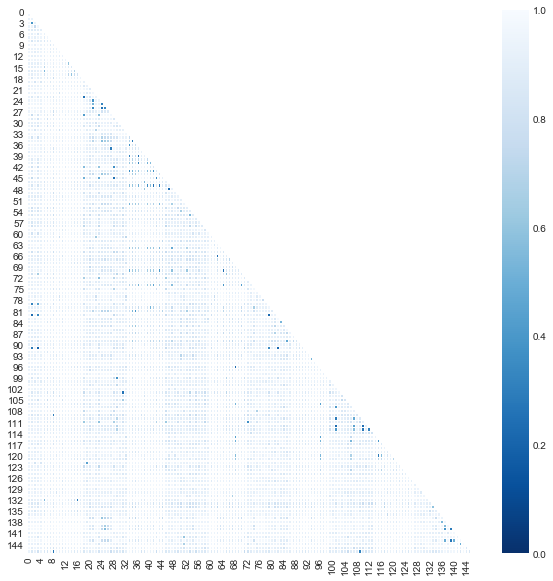


- Mean variance in prototype selection:  0.9013095905109612

- Final number of prototypes:  147

# Finished in 1.0785 secs


+ ------------   45    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  0.8
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  jaccard
number_of_permutations:  5
withchars:  True
ngramms:  3
prototypeFilter:  0.3
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.4
Prototypes before:
[3, 10, 13, 17, 21, 28, 30, 32, 34, 40, 44, 47, 51, 59, 65, 94, 105, 137, 181, 190, 254, 271, 299, 334, 338, 351, 354, 376, 398, 402, 405, 415, 419, 424, 426, 432, 442, 451, 453, 456, 462, 467, 472, 476, 489, 499, 513, 525, 531, 561, 577, 599, 661, 674, 686, 689, 692, 695, 702, 707, 711, 713, 716, 725, 729, 731, 755, 774, 778, 783, 788, 792, 794, 796, 801, 822, 840, 847, 852, 857, 860, 864, 874, 883, 888, 948, 1006, 1009, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1067, 1099, 1107, 1114, 1119, 1121, 1132, 1146, 1160, 1163, 1166, 1168, 1170, 1179, 1200, 1212, 1216, 1223, 1230, 1244, 1254, 1257, 1269, 1279, 1292, 1296, 1306, 1319, 1324, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1366, 1382, 1398, 1412, 1414, 1416, 1421, 1429, 1440, 1452, 1464, 1473, 1480, 1487, 1490, 1494, 1498, 1502, 1506, 1510, 1515, 1519, 1534, 1552, 1569, 1581, 1591, 1594, 1603, 1611, 1613, 1621, 1647, 1655, 1659, 1661, 1663, 1677, 1694, 1724, 1732, 1768, 1774, 1780, 1793, 1804, 1823

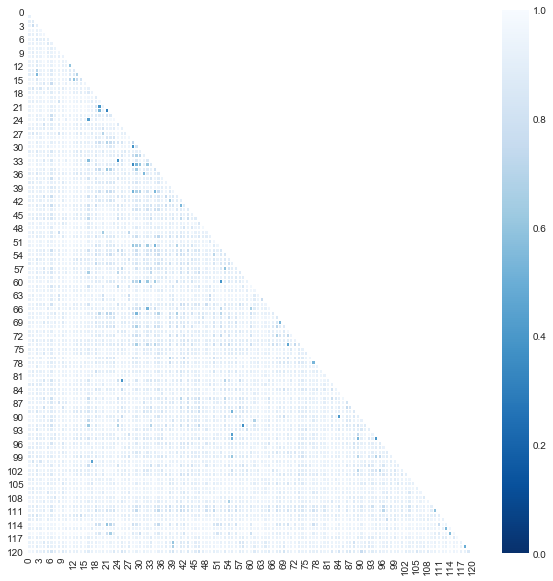


- Mean variance in prototype selection:  0.9049957682254092

- Final number of prototypes:  121

# Finished in 1.1547 secs





In [93]:
max_numberOf_clusters= [10,50,100,500,1000]
max_editDistance= [0.6,0.7,0.8]
prototypesFilterThr = [0.1,0.2,0.3]

distanceMetric= ['jaccard']


ngramms= [3]  
jaccard_withchars = [True] 

# ---------------- #

distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']


results_section1_jac = GridSearch_cora(
    data,true_matrix,max_numberOf_clusters,max_editDistance,
    similarityThreshold,
    windowSize,metric,similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,number_of_permutations,
    ngramms,jaccard_withchars,prototypesFilterThr
)

In [90]:
results_section1_jac[["numOfPrototypes","max_numberOf_clusters","max_editDistance","similarityThreshold","protSelectionVariance","prototypesFilterThr"]].sort_values(by=['numOfPrototypes'], ascending=False).head(20)

numOfPrototypes max_numberOf_clusters  max_editDistance  \
40             177                  1000               0.5   
31             177                   500               0.5   
37             168                  1000               0.2   
43             159                  1000               0.7   
34             159                   500               0.7   
44             103                  1000               0.7   
35             103                   500               0.7   
32              99                   500               0.5   
41              99                  1000               0.5   
38              92                  1000               0.2   
28              88                   500               0.2   
36              72                   500               0.7   
45              72                  1000               0.7   
42              70                  1000               0.5   
33              70                   500               0.5   
39              66                  1000               0.2   
29              49                   500               0.2   
25              48                   100               0.7   
30              39                   500               0.2   
26              31                   100               0.7   

    similarityThreshold  protSelectionVariance  prototypesFilterThr  
40                  0.7               0.899365                  0.2  
31                  0.7               0.899365                  0.2  
37                  0.7               0.899578                  0.2  
43                  0.7               0.900857                  0.2  
34                  0.7               0.900857                  0.2  
44                  0.7               0.906422                  0.5  
35                  0.7               0.906422                  0.5  
32                  0.7               0.906285                  0.5  
41                  0.7               0.906285                  0.5  
38                  0.7               0.905960                  0.5  
28                  0.7               0.886701                  0.2  
36                  0.7               0.906616                  0.7  
45                  0.7               0.906616                  0.7  
42                  0.7               0.907453                  0.7  
33                  0.7               0.907453                  0.7  
39                  0.7               0.908082                  0.7  
29                  0.7               0.894649                  0.5  
25                  0.7               0.860308                  0.2  
30                  0.7               0.896026                  0.7  
26                  0.7               0.878659                  0.5

In [92]:
results_section1_jac[["numOfPrototypes","max_numberOf_clusters","max_editDistance","similarityThreshold","protSelectionVariance","prototypesFilterThr"]].sort_values(by=['protSelectionVariance']).head(50)

numOfPrototypes max_numberOf_clusters  max_editDistance  \
1                3                    10               0.2   
2                3                    10               0.2   
3                3                    10               0.2   
7                4                    10               0.7   
8                4                    10               0.7   
9                4                    10               0.7   
4                4                    10               0.5   
5                4                    10               0.5   
6                4                    10               0.5   
22              29                   100               0.5   
13              20                    50               0.5   
19              18                   100               0.2   
12              11                    50               0.2   
15              12                    50               0.5   
16              20                    50               0.7   
21              12                   100               0.2   
10              14                    50               0.2   
11              13                    50               0.2   
24              13                   100               0.5   
18              13                    50               0.7   
20              14                   100               0.2   
14              16                    50               0.5   
23              17                   100               0.5   
17              17                    50               0.7   
25              48                   100               0.7   
26              31                   100               0.7   
27              23                   100               0.7   
28              88                   500               0.2   
29              49                   500               0.2   
30              39                   500               0.2   
31             177                   500               0.5   
40             177                  1000               0.5   
37             168                  1000               0.2   
43             159                  1000               0.7   
34             159                   500               0.7   
38              92                  1000               0.2   
41              99                  1000               0.5   
32              99                   500               0.5   
44             103                  1000               0.7   
35             103                   500               0.7   
36              72                   500               0.7   
45              72                  1000               0.7   
33              70                   500               0.5   
42              70                  1000               0.5   
39              66                  1000               0.2   

    similarityThreshold  protSelectionVariance  prototypesFilterThr  
1                   0.7               0.621945                  0.2  
2                   0.7               0.621945                  0.5  
3                   0.7               0.621945                  0.7  
7                   0.7               0.685968                  0.2  
8                   0.7               0.685968                  0.5  
9                   0.7               0.685968                  0.7  
4                   0.7               0.692744                  0.2  
5                   0.7               0.692744                  0.5  
6                   0.7               0.692744                  0.7  
22                  0.7               0.812770                  0.2  
13                  0.7               0.834712                  0.2  
19                  0.7               0.837959                  0.2  
12                  0.7               0.844176                  0.7  
15                  0.7               0.846873                  0.7  
16                  0.7               0.847277                  0.2  
21                  0.7       

## Performance details

### Embeddings

In [ ]:
pcaComponents = PCA_SpaceVisualization(model.Embeddings)

In [ ]:
pcaComponents = PCA_SpaceVisualization(model.rankedVectors)

### Grid Search

In [ ]:
max_numberOf_clusters= [5,10,20]
max_editDistance= [50,100,200,300]
windowSize= [3, 5, 10, 15]
similarityThreshold= [0.6,0.7,0.8]
metric= ['kendal', 'customKendal','jaccard','pearson']
similarityVectors= ['ranked','initial']
distanceMetric= ['edit']
distanceMetricEmbedding = ['edit','euclidean']
number_of_permutations = [1,3,5,7]


# results = GridSearch_cora(data,true_matrix,max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations)

In [ ]:
# results.sort_values(by=['Accuracy'],ascending=False)

---

# References

1.   [The dissimilarity representation for pattern recognition, a tutorial
Robert P.W. Duin and Elzbieta Pekalska Delft University of Technology, The Netherlands School of Computer Science, University of Manchester, United Kingdom](http://homepage.tudelft.nl/a9p19/presentations/DisRep_Tutorial_doc.pdf)